In [1]:
!pip install seaborn
!pip install keras
!pip install tensorflow-gpu

    100% |████████████████████████████████| 184kB 2.5MB/s 
  Running setup.py bdist_wheel for seaborn ... - \ done
  Stored in directory: /home/carnd/.cache/pip/wheels/59/10/63/af632c81af65a5acca29220158270dc767927a81650acffcb5
Successfully built seaborn
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 235kB 3.4MB/s 
  Running setup.py bdist_wheel for keras ... - \ done
  Stored in directory: /home/carnd/.cache/pip/wheels/c2/80/ba/2beab8c2131e2dcc391ee8a2f55e648af66348115c245e0839
Successfully built keras
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 89.2MB 14kB/s 
    100% |████████████████████████████████| 317kB 4.4MB/s 
    100% |████████████████████████████████| 5.7MB 241kB/s 
    100% |███████████

In [1]:
from Constants import ROOT_DIR, \
    H5_DIR_FULLYCONNECTED_MULTIPLE_RELU,\
    H5_DIR_FULLYCONNECTED_MULTIPLE_ELU,\
    H5_DIR_COVNET_MULTIPLE_RELU,\
    H5_DIR_COVNET_MULTIPLE_ELU,\
    H5_DIR_COVNET_JUMP_SIGMA,\
    H5_DIR_COVNET_JUMP_MU,\
    H5_DIR_COVNET_LAMBDA,\
    H5_DIR_ENSEMBLING,\
    HISTORY_DIR_FEEDFORWARD_RELU,\
    PREDICTIONS_DIR_FEEDFORWARD_RELU

In [2]:
import numpy as np
import math
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pylab

from scipy import stats
from numpy import random as nrand

%matplotlib inline

# Optional:
import seaborn as sns
sns.set(color_codes=True)
sns.set_style(style='white')
sns.set(font_scale=1.6)

In [3]:
import tensorflow as tf
import keras
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, Flatten, LSTM, Convolution2D, MaxPooling2D, Input
from keras.optimizers import Adam
from keras import backend as K

Using TensorFlow backend.


In [4]:
from Merton_Jump_Diffusion_SDE_Utilities import \
    ModelParameters, \
    random_model_params, \
    geometric_brownian_motion_jump_diffusion_log_returns
    
from Models import \
    fullyconnected_multiple_output, \
    covnet_multiple_8_layers, \
    covnet_single_ReLUs_6_layers, \
    fullyconnected_single_output

In [5]:
def test_set_model_params():
    return ModelParameters(
        all_time=2000,
        all_delta=0.00396825396,
        all_sigma = 0.1,
        gbm_mu = 0.05,
        jumps_sigma=0.07,
        jumps_mu=0.05,
        jumps_lamda=0.02)

def standard_convolutional_test_set(sample_size = 1000, dim = (40, 50), mp = None):
    if mp == None:
        mp = test_set_model_params()
        
    test_set = []
    for i in range(sample_size):
        if (i%100 == 0):
            print(i)
        test_set.append(geometric_brownian_motion_jump_diffusion_log_returns(mp))

    test_set_pred = np.reshape(np.array(test_set), (sample_size, dim[0], dim[1], 1))
    return test_set_pred

def convolutional_batch_generator(all_time = 2000, paramset_size = 32, paths_p_paramset = 5):
    while True:
        RETURNS_ = []
        PARAMS_ = []
        
        for i in range(paramset_size):
            mp = random_model_params()
            mp.all_time = all_time
            
            for j in range(paths_p_paramset):
                PARAMS_.append(mp)
                RETURNS_.append(geometric_brownian_motion_jump_diffusion_log_returns(mp))
        
        train_data = np.reshape(np.array(RETURNS_), (paramset_size*paths_p_paramset, 40, 50, 1))
        sigmas = np.array([[mp.all_sigma] for mp in PARAMS_])
        mus = np.array([[mp.gbm_mu] for mp in PARAMS_])
        jump_sigmas = np.array([[mp.jumps_sigma] for mp in PARAMS_])
        jump_mus = np.array([[mp.jumps_mu] for mp in PARAMS_])
        lambdas = np.array([[mp.lamda] for mp in PARAMS_])
        
        yield train_data, [sigmas, mus, jump_sigmas, jump_mus, lambdas]

def standard_fullyconnected_test_set(sample_size = 1000):
    test_set = []
    for i in range(sample_size):
        if (i%100 == 0):
            print(i)
        test_set.append(geometric_brownian_motion_jump_diffusion_log_returns(test_set_model_params()))

    train_moments = [np.append(stats.moment(example, moment = range(2,20)), np.mean(example)) for example in test_set]
    train_statistics = np.array([np.append(train_moments[i], 
                                  sm.tsa.stattools.acf(test_set[i])) 
                        for i in range(len(test_set))])
    return train_statistics


def standard_test_sets(sample_size = 1000, dim = (40, 50)):
    test_set = []
    for i in range(sample_size):
        if (i%100 == 0):
            print(i)
        test_set.append(geometric_brownian_motion_jump_diffusion_log_returns(test_set_model_params()))

    test_set_pred = np.reshape(np.array(test_set), (sample_size, dim[0], dim[1], 1))
    
    train_moments = [np.append(stats.moment(example, moment = range(2,20)), np.mean(example)) for example in test_set]
    train_statistics = np.array([np.append(train_moments[i], 
                                  sm.tsa.stattools.acf(test_set[i])) 
                        for i in range(len(test_set))])
    return test_set_pred, train_statistics

def fullyconnected_batch_generator(all_time = 2000, paramset_size = 32, paths_p_paramset = 5, single_parameter=None):
    while True:
        RETURNS_ = []
        PARAMS_ = []
        
        for i in range(paramset_size):
            mp = random_model_params()
            mp.all_time = all_time
            
            for j in range(paths_p_paramset):
                PARAMS_.append(mp)
                RETURNS_.append(geometric_brownian_motion_jump_diffusion_log_returns(mp))
        
        train_moments = [np.append(stats.moment(example, moment = range(2,20)), np.mean(example)) for example in RETURNS_]

        train_statistics = np.array([np.append(train_moments[i], 
                              sm.tsa.stattools.acf(RETURNS_[i])) 
                    for i in range(len(RETURNS_))])
        
        sigmas = np.array([[mp.all_sigma] for mp in PARAMS_])
        mus = np.array([[mp.gbm_mu] for mp in PARAMS_])
        jump_sigmas = np.array([[mp.jumps_sigma] for mp in PARAMS_])
        jump_mus = np.array([[mp.jumps_mu] for mp in PARAMS_])
        lambdas = np.array([[mp.lamda] for mp in PARAMS_])
        
        if single_parameter == None:
            yield train_statistics, [sigmas, mus, jump_sigmas, jump_mus, lambdas]
        
        if single_parameter == 'sigma':
            yield train_statistics, sigmas
            
        if single_parameter == 'mu':
            yield train_statistics, mus
            
        if single_parameter == 'jumps_sigma':
            yield train_statistics, jump_sigmas
            
        if single_parameter == 'jumps_mu':
            yield train_statistics, jump_mus
            
        if single_parameter == 'lambda':
            yield train_statistics, lambdas

# Fully Connected Multiple ReLUs

In [6]:
feedforward = fullyconnected_multiple_output(activation='relu')
#feedforward.load_weights(H5_DIR_FULLYCONNECTED_MULTIPLE_RELU)

/Users/Rayno/Stochastic-Process-Calibration-Dissertation/Source_Code/Models.py:82: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`
  feedforward = Model(input = input_1, output=[output1, output2, output3, output4, output5])


In [7]:
test_set = standard_fullyconnected_test_set()

0
100
200
300
400
500
600
700
800
900


In [8]:
#feedforward_relu_histories = np.load(HISTORY_DIR_FEEDFORWARD_RELU).tolist()
#feedforward_relu_predictions = np.load(PREDICTIONS_DIR_FEEDFORWARD_RELU).tolist()
feedforward_relu_histories = []
feedforward_relu_predictions = []

In [11]:
train_gen = fullyconnected_batch_generator(paramset_size=2000, paths_p_paramset=1)

In [16]:
!git pull

remote: Counting objects: 22, done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 22 (delta 6), reused 22 (delta 6), pack-reused 0
Unpacking objects: 100% (22/22), done.
From https://github.com/RWMostert/Stochastic-Process-Calibration-Dissertation
   5c99d74..80960ab  master     -> origin/master


In [12]:
for i in range(1000):
    history = feedforward.fit_generator(train_gen, steps_per_epoch = 10, epochs = 1)
    feedforward_relu_histories.append(history.history)
    feedforward_relu_predictions.append(feedforward.predict(test_set))
    
    feedforward.save_weights(H5_DIR_FULLYCONNECTED_MULTIPLE_RELU)

    np.save(HISTORY_DIR_FEEDFORWARD_RELU, feedforward_relu_histories)
    np.save(PREDICTIONS_DIR_FEEDFORWARD_RELU, feedforward_relu_predictions)

    if i%5 == 0:
        !git config --global user.email "rwmmostert@gmail.com"
        !git config --global user.name "RWMostert"
        !git add --all
        !git commit -am "updated history, predictions and model" 
        !git push -u origin master --quiet -f

Epoch 1/1
 1/10 [==>...........................] - ETA: 299s - loss: 0.4369 - sigma_loss: 0.0073 - mu_loss: 0.3302 - jump_sigma_loss: 0.0034 - jump_mu_loss: 0.0898 - lambda_loss: 0.0062 - sigma_r2: -1.2429 - sigma_mean_absolute_percentage_error: 357.6799 - mu_r2: -0.0160 - mu_mean_absolute_percentage_error: 150.5280 - jump_sigma_r2: -0.0011 - jump_sigma_mean_absolute_percentage_error: 203.1402 - jump_mu_r2: -0.0774 - jump_mu_mean_absolute_percentage_error: 772.1553 - lambda_r2: -121.0594 - lambda_mean_absolute_percentage_error: 1821.2078

KeyboardInterrupt: 

# Fully Connected Multiple ELUs

In [15]:
feedforward = fullyconnected_multiple_output()
#feedforward = load_model("FULL_FEEDFORWARD_NETWORK.h5", compile=False)

/Users/Rayno/Stochastic-Process-Calibration-Dissertation/Source_Code/Models.py:49: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`
  feedforward = Model(input = input_1, output=[output1, output2, output3, output4, output5])


In [9]:
def r2(y_true, y_pred):
    """
    returns the correlation coefficient of y_pred against y_true.

    :param y_true: the true values (independent variable)
    :param y_pred: the predicted values (dependent variable)
    """
    
    SSE = K.sum(K.square(y_true-y_pred))
    SST = K.sum(K.square(y_true-K.mean(y_true)))
    
    return 1-SSE/SST

feedforward.compile(loss='mean_squared_error', optimizer='adam', metrics=[r2, 'mean_absolute_percentage_error'])

NameError: name 'feedforward' is not defined

In [8]:
test_set = standard_fullyconnected_test_set()

0
100
200
300
400
500
600
700
800
900


In [17]:
#histories2 = np.load("FULL_feedforward_mo_histories.npy").tolist()
#ff_predicts = np.load("FULL_ff_predicts.npy").tolist()
histories2 = []
ff_predicts = []

In [26]:
train_gen = fullyconnected_batch_generator(paramset_size=2000, paths_p_paramset=1)

In [14]:
from keras.optimizers import Adam
adam = Adam(lr=0.001)

In [18]:
lowest_loss = 20

In [27]:
for i in range(100000):
    history = feedforward.fit_generator(train_gen, steps_per_epoch = 10, epochs = 1)
    histories2.append(history.history)
    ff_predicts.append(feedforward.predict(test_set))
    
    if history.history['loss'][0] < lowest_loss:
        feedforward.save("FULL_FEEDFORWARD_NETWORK2.h5")
        np.save("FULL_feedforward_mo_histories2.npy", histories2)
        np.save("FULL_ff_predicts2.npy", ff_predicts)
    

Epoch 1/1
10/10 [==============================] - 277s - loss: 0.0422 - sigma_loss: 0.0035 - mu_loss: 0.0251 - jump_sigma_loss: 0.0033 - jump_mu_loss: 0.0101 - lambda_loss: 2.6643e-04 - sigma_r2: -0.0649 - sigma_mean_absolute_percentage_error: 198.4326 - mu_r2: 0.9255 - mu_mean_absolute_percentage_error: 802.9107 - jump_sigma_r2: -0.0169 - jump_sigma_mean_absolute_percentage_error: 190.5406 - jump_mu_r2: 0.8796 - jump_mu_mean_absolute_percentage_error: 202.6226 - lambda_r2: -4.2020 - lambda_mean_absolute_percentage_error: 272.6104    
Epoch 1/1
10/10 [==============================] - 284s - loss: 0.0409 - sigma_loss: 0.0034 - mu_loss: 0.0235 - jump_sigma_loss: 0.0033 - jump_mu_loss: 0.0105 - lambda_loss: 2.0153e-04 - sigma_r2: -0.0254 - sigma_mean_absolute_percentage_error: 189.2731 - mu_r2: 0.9294 - mu_mean_absolute_percentage_error: 211.8642 - jump_sigma_r2: -7.1414e-04 - jump_sigma_mean_absolute_percentage_error: 187.9626 - jump_mu_r2: 0.8742 - jump_mu_mean_absolute_percentage_err

KeyboardInterrupt: 

In [16]:
history.history['loss'][0] < 0.3

False

# Fully Connected Single Ouput ELUs

In [9]:
#feedforward = fullyconnected_single_output()
feedforward = load_model("FULL_FEEDFORWARD_NETWORK2.h5", custom_objects={"r2":r2})

In [8]:
def r2(y_true, y_pred):
    """
    returns the correlation coefficient of y_pred against y_true.

    :param y_true: the true values (independent variable)
    :param y_pred: the predicted values (dependent variable)
    """
    
    SSE = K.sum(K.square(y_true-y_pred))
    SST = K.sum(K.square(y_true-K.mean(y_true)))
    
    return 1-SSE/SST

feedforward.compile(loss='mean_squared_error', optimizer='adam', metrics=[r2, 'mean_absolute_percentage_error'])

NameError: name 'feedforward' is not defined

In [8]:
test_set = standard_fullyconnected_test_set()

0
100
200
300
400
500
600
700
800
900


In [27]:
#histories2 = np.load("FULL_feedforward_mo_histories.npy").tolist()
#ff_predicts = np.load("FULL_ff_predicts.npy").tolist()
histories2 = []
ff_predicts = []

In [31]:
train_gen = fullyconnected_batch_generator(paramset_size=2000, paths_p_paramset=1, single_parameter='lambda')

In [29]:
lowest_loss = 20

In [32]:
for i in range(100000):
    history = feedforward.fit_generator(train_gen, steps_per_epoch = 10, epochs = 1)
    histories2.append(history.history)
    ff_predicts.append(feedforward.predict(test_set))
    
    if history.history['loss'][0] < lowest_loss:
        feedforward.save("FULL_FEEDFORWARD_SINGLE.h5")
        np.save("FULL_feedforward_single_histories.npy", histories2)
        np.save("FULL_feedforward_single_predicts.npy", ff_predicts)
    

Epoch 1/1
10/10 [==============================] - 288s - loss: 7.2323e-05 - r2: -0.3935 - mean_absolute_percentage_error: 215.4057    
Epoch 1/1
10/10 [==============================] - 282s - loss: 5.4939e-05 - r2: -0.0589 - mean_absolute_percentage_error: 207.9625    
Epoch 1/1
10/10 [==============================] - 279s - loss: 9.7436e-05 - r2: -0.8542 - mean_absolute_percentage_error: 209.5798    
Epoch 1/1
10/10 [==============================] - 281s - loss: 5.3906e-05 - r2: -0.0395 - mean_absolute_percentage_error: 212.4736    
Epoch 1/1
10/10 [==============================] - 284s - loss: 5.4860e-05 - r2: -0.0500 - mean_absolute_percentage_error: 211.1402    
Epoch 1/1
10/10 [==============================] - 281s - loss: 2.0929e-04 - r2: -3.0483 - mean_absolute_percentage_error: 208.7687    
Epoch 1/1
10/10 [==============================] - 283s - loss: 5.5378e-05 - r2: -0.0590 - mean_absolute_percentage_error: 212.5033    
Epoch 1/1
10/10 [==============================]

KeyboardInterrupt: 

# Covnet Multiple Output with ELUs

In [10]:
covnet_mo_elu = load_model("FULLMODEL_10LAYERS_COVNET.h5", custom_objects={"r2":r2})#("FULLMODEL_RELAXED_ELU_COVNET.h5") #covnet_multiple_ELUs_8_layers()
#covnet_mo_elu.load_weights(H5_DIR_COVNET_MULTIPLE_ELU)

In [ ]:
#covnet_mo_elu.save(H5_DIR_COVNET_MULTIPLE_ELU)

In [11]:
train_gen = convolutional_batch_generator(paramset_size=100, paths_p_paramset=1)

In [ ]:
test_set_pred = standard_convolutional_test_set()

0
100
200


In [22]:
histories_elu = []#np.load("covnet_histories_elu.npy").tolist()
covnet_mo_elu_predictions = []#np.load("covnet_mo_elu_predictions.npy").tolist()

In [36]:
for i in range(150000):
    history = covnet_mo_elu.fit_generator(train_gen, samples_per_epoch = 10, nb_epoch = 1)
    """
    histories_elu.append(history.history)
    
    predictions_elu = covnet_mo_elu.predict(test_set_pred)
    
    covnet_mo_elu_predictions.append(predictions_elu)
    
    covnet_mo_elu.save_weights(H5_DIR_COVNET_MULTIPLE_ELU)
    
    np.save("covnet_histories_elu.npy", histories_elu)
    np.save("covnet_mo_elu_predictions.npy", covnet_mo_elu_predictions)
    
    !git config --global user.email "rwmmostert@gmail.com"
    !git config --global user.name "RWMostert"
    !git add --all
    !git commit -am "updated history, predictions and model"
    !git push -u origin master --quiet"""

/Users/Rayno/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  from ipykernel import kernelapp as app
/Users/Rayno/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=10, epochs=1)`
  from ipykernel import kernelapp as app


Epoch 1/1
 2/10 [=====>........................] - ETA: 113s - loss: 0.0084 - sigma_loss: 5.2148e-05 - mu_loss: 0.0046 - jump_sigma_loss: 0.0013 - jump_mu_loss: 0.0024 - lambda_loss: 1.2542e-04 - sigma_mean_absolute_percentage_error: 23.3527 - mu_mean_absolute_percentage_error: 72.8444 - jump_sigma_mean_absolute_percentage_error: 82.5296 - jump_mu_mean_absolute_percentage_error: 57.4059 - lambda_mean_absolute_percentage_error: 156.5415

KeyboardInterrupt: 

# Covnet Single Output Prediction - Lambda Smaller

In [11]:
covnet_lambda = covnet_single_ReLUs_6_layers()

In [7]:
covnet_lambda.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 40, 50, 32)        4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 50, 32)        147488    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 25, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 25, 64)        73792     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 20, 25, 64)        147520    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7680)              0         
__________

In [16]:
def lambda_batch_generator(all_time = 2000, paramset_size = 32, paths_p_paramset = 5):
    while True:
        RETURNS_ = []
        PARAMS_ = []
        
        for i in range(paramset_size):
            mp = random_model_params()
            mp.all_time = all_time
            
            for j in range(paths_p_paramset):
                PARAMS_.append(mp)
                RETURNS_.append(geometric_brownian_motion_jump_diffusion_log_returns(mp))
        
        train_data = np.reshape(np.array(RETURNS_), (paramset_size*paths_p_paramset, 40, 50, 1))
        
        lambdas = np.array([[mp.lamda] for mp in PARAMS_])
        
        yield train_data, lambdas

lambda_train_gen = lambda_batch_generator(paramset_size=1500, paths_p_paramset=1)

In [9]:
test_set_pred = standard_convolutional_test_set()

0
100
200
300
400
500
600
700
800
900


In [12]:
covnet_lambda.load_weights(H5_DIR_COVNET_LAMBDA)

In [10]:
histories_lambda = np.load("Lambda_histories.npy").tolist()
preds_lambda = np.load("preds_lambda.npy").tolist()

In [25]:
!git config --global user.email "rwmmostert@gmail.com"
!git config --global user.name "RWMostert"

In [17]:
for i in range(15000):
    history = covnet_lambda.fit_generator(lambda_train_gen, steps_per_epoch = 10, epochs = 1)
    
    histories_lambda.append(history.history)
    preds_lambda.append(covnet_lambda.predict(test_set_pred))
    
    covnet_lambda.save_weights(H5_DIR_COVNET_LAMBDA)
    if i%10 == 0:
        np.save("Lambda_histories.npy", histories_lambda)
        np.save("preds_lambda.npy", preds_lambda)
        !git add --all
        !git commit -am "Model trained"
        !git push --quiet

Epoch 1/1
10/10 [==============================] - 154s - loss: 8.1381e-06 - mean_absolute_percentage_error: 36.5599 - r2: 0.8421    
[master 0983384] Model trained
 4 files changed, 2 insertions(+), 27 deletions(-)
Git 2.0 from 'matching' to 'simple'. To squelch this message
and maintain the traditional behavior, use:

  git config --global push.default matching

To squelch this message and adopt the new behavior now, use:

  git config --global push.default simple

When push.default is set to 'matching', git will push local branches
to the remote branches that already exist with the same name.

Since Git 2.0, Git defaults to the more conservative 'simple'
behavior, which only pushes the current branch to the corresponding
remote branch that 'git pull' uses to update the current branch.

See 'git help config' and search for 'push.default' for further information.
(the 'simple' mode was introduced in Git 1.7.11. Use the similar mode
'current' instead of 'simple' if you sometimes use ol

KeyboardInterrupt: 

# Convnet Single Output Prediction - Jump Mu

In [13]:
covnet_jump_mu = covnet_single_ReLUs_6_layers()

In [49]:
def jump_mu_batch_generator(all_time = 2000, paramset_size = 32, paths_p_paramset = 5):
    while True:
        RETURNS_ = []
        PARAMS_ = []
        
        for i in range(paramset_size):
            mp = random_model_params()
            mp.all_time = all_time
            
            for j in range(paths_p_paramset):
                PARAMS_.append(mp)
                RETURNS_.append(geometric_brownian_motion_jump_diffusion_log_returns(mp))
        
        train_data = np.reshape(np.array(RETURNS_), (paramset_size*paths_p_paramset, 40, 50, 1))
        
        jumps_mus = np.array([[mp.jumps_mu] for mp in PARAMS_])
        
        yield train_data, jumps_mus

jump_mu_train_gen = jump_mu_batch_generator(paramset_size=1000, paths_p_paramset=1)

In [ ]:
test_set_pred = standard_convolutional_test_set()

In [14]:
covnet_jump_mu.load_weights(H5_DIR_COVNET_JUMP_MU)

In [47]:
histories_covnet_jump_mu = np.load("histories_covnet_jump_mu.npy").tolist()
predictions_covnet_jump_mu = np.load("predictions_covnet_jump_mu.npy").tolist()

In [50]:
for i in range(150000000):
    history = covnet_jump_mu.fit_generator(jump_mu_train_gen, steps_per_epoch = 10, epochs = 1)
    histories_covnet_jump_mu.append(history.history)
    predictions_covnet_jump_mu.append(covnet_jump_mu.predict(test_set_pred))
    covnet_jump_mu.save_weights(H5_DIR_COVNET_JUMP_MU)
    
    if (i%10 == 0):
        np.save("histories_covnet_jump_mu.npy", histories_covnet_jump_mu)
        np.save("predictions_covnet_jump_mu.npy", predictions_covnet_jump_mu)

        !git add --all
        !git commit -am "Model trained"
        !git push --quiet

Epoch 1/1


KeyboardInterrupt: 

# Convnet Single Output Prediction - Jump Sigma

In [15]:
covnet_jump_sigma = covnet_single_ReLUs_6_layers()
covnet_jump_sigma.load_weights(H5_DIR_COVNET_JUMP_SIGMA)

In [15]:
def jump_sigma_batch_generator(all_time = 2000, paramset_size = 32, paths_p_paramset = 5):
    while True:
        RETURNS_ = []
        PARAMS_ = []
        
        for i in range(paramset_size):
            mp = random_model_params()
            mp.all_time = all_time
            
            for j in range(paths_p_paramset):
                PARAMS_.append(mp)
                RETURNS_.append(geometric_brownian_motion_jump_diffusion_log_returns(mp))
        
        train_data = np.reshape(np.array(RETURNS_), (paramset_size*paths_p_paramset, 40, 50, 1))
        
        jumps_sigmas = np.array([[mp.jumps_sigma] for mp in PARAMS_])
        
        yield train_data, jumps_sigmas

jump_sigma_train_gen = jump_sigma_batch_generator(paramset_size=50, paths_p_paramset=1)

In [16]:
covnet_jump_sigma.load_weights(H5_DIR_COVNET_JUMP_SIGMA)

In [17]:
test_set_pred = standard_convolutional_test_set()

0
100
200
300
400
500
600
700
800
900


In [18]:
histories_covnet_jump_sigma = np.load("histories_covnet_jump_sigma.npy").tolist()
predictions_covnet_jump_sigma = np.load("predictions_covnet_jump_sigma.npy").tolist()
    
#histories_covnet_jump_sigma = []
#predictions_covnet_jump_sigma = []

FileNotFoundError: [Errno 2] No such file or directory: 'histories_covnet_jump_sigma.npy'

In [20]:
for i in range(100000):
    
    history = covnet_jump_sigma.fit_generator(jump_sigma_train_gen, steps_per_epoch = 30, epochs = 1)
    histories_covnet_jump_sigma.append(history.history)
    predictions_covnet_jump_sigma.append(covnet_jump_sigma.predict(test_set_pred))
    covnet_jump_sigma.save_weights(H5_DIR_COVNET_JUMP_SIGMA)
    
    np.save("histories_covnet_jump_sigma.npy", histories_covnet_jump_sigma)
    np.save("predictions_covnet_jump_sigma.npy", predictions_covnet_jump_sigma)
    
    if i % 5 == 0:
        !cd ..
        !git config --global user.email "rwmmostert@gmail.com"
        !git config --global user.name "RWMostert"
        !git add --all
        !git commit -am "updated history, predictions and model"
        !git push -u origin master --quiet

Epoch 1/1
30/30 [==============================] - 167s - loss: 0.0018 - mean_absolute_percentage_error: 110.4811 - r2: 0.4457   


NameError: name 'histories_covnet_jump_sigma' is not defined

# Ensembling Network

In [13]:
ff_ensembling = Sequential()
ff_ensembling.add(Dense(128, input_dim = 8, activation='relu'))
ff_ensembling.add(Dense(256, activation='relu'))
ff_ensembling.add(Dense(128, activation='relu'))
ff_ensembling.add(Dense(64, activation='relu'))
ff_ensembling.add(Dense(32, activation='relu'))
ff_ensembling.add(Dense(5))

ff_ensembling.compile('adam', 'mean_squared_error', metrics=['mean_absolute_percentage_error', r2])

In [47]:
all_time = 2000
paramset_size = 1
paths_p_paramset = 1

RETURNS_ = []
PARAMS_ = []
        
for i in range(paramset_size):
    mp = random_model_params()
    mp.all_time = all_time
            
    for j in range(paths_p_paramset):
        PARAMS_.append([mp.all_sigma, mp.gbm_mu, mp.jumps_sigma, mp.jumps_mu, mp.lamda])
        RETURNS_.append(geometric_brownian_motion_jump_diffusion_log_returns(mp))
        
train_data = np.reshape(np.array(RETURNS_), (paramset_size*paths_p_paramset, 40, 50, 1))
                
predictions = []
for return_set in train_data:
    output1 = covnet_mo.predict(np.array([return_set]))
    output2 = covnet_lambda.predict(np.array([return_set]))
    output3 = covnet_jump_mu.predict(np.array([return_set]))
    output4 = covnet_jump_sigma.predict(np.array([return_set]))
    for output in output1:
        predictions.append(output[0][0])
    predictions.append(output2[0][0])
    predictions.append(output3[0][0])
    predictions.append(output4[0][0])
        
print(predictions)
        
print(PARAMS_)

AttributeError: 'builtin_function_or_method' object has no attribute 'uniform'

In [ ]:
def ensemble_batch_generator(all_time = 2000, paramset_size = 32, paths_p_paramset = 5):
    while True:
        RETURNS_ = []
        PARAMS_ = []
        
        for i in range(paramset_size):
            mp = random_model_params()
            mp.all_time = all_time
            
            for j in range(paths_p_paramset):
                PARAMS_.append([mp.all_sigma, mp.gbm_mu, mp.jumps_sigma, mp.jumps_mu, mp.lamda])
                RETURNS_.append(geometric_brownian_motion_jump_diffusion_log_returns(mp))
        
        train_data = np.reshape(np.array(RETURNS_), (paramset_size*paths_p_paramset, 40, 50, 1))
                
        predictionset = []
        for return_set in train_data:
            prediction = []
            output1 = covnet_mo.predict(np.array([return_set]))
            output2 = covnet_lambda.predict(np.array([return_set]))
            output3 = covnet_jump_mu.predict(np.array([return_set]))
            output4 = covnet_jump_sigma.predict(np.array([return_set]))
            for output in output1:
                prediction.append(output[0][0])
            prediction.append(output2[0][0])
            prediction.append(output3[0][0])
            prediction.append(output4[0][0])
            predictionset.append(prediction)
        
        
        yield np.array(predictionset), np.array(PARAMS_)

ensemble_batch_gen = ensemble_batch_generator(paramset_size=10, paths_p_paramset=5)

In [48]:
ff_ensembling.load_weights(H5_DIR_ENSEMBLING)

In [26]:


for i in range(150):
    ff_ensembling.fit_generator(ensemble_batch_gen, steps_per_epoch = 10, epochs = 1)
    ff_ensembling.save_weights(H5_DIR_ENSEMBLING)

Epoch 1/1
10/10 [==============================] - 12s - loss: 0.0702 - mean_absolute_percentage_error: 159.5318 - r2: 0.1603    
Epoch 1/1
10/10 [==============================] - 12s - loss: 0.0328 - mean_absolute_percentage_error: 411.3496 - r2: 0.6036    
Epoch 1/1
10/10 [==============================] - 13s - loss: 0.0150 - mean_absolute_percentage_error: 194.8047 - r2: 0.8024    
Epoch 1/1
10/10 [==============================] - 13s - loss: 0.0126 - mean_absolute_percentage_error: 189.8853 - r2: 0.8564    
Epoch 1/1
10/10 [==============================] - 13s - loss: 0.0066 - mean_absolute_percentage_error: 235.1893 - r2: 0.9176    
Epoch 1/1
10/10 [==============================] - 12s - loss: 0.0038 - mean_absolute_percentage_error: 199.7375 - r2: 0.9498    
Epoch 1/1
10/10 [==============================] - 12s - loss: 0.0032 - mean_absolute_percentage_error: 185.2724 - r2: 0.9597    
Epoch 1/1
10/10 [==============================] - 13s - loss: 0.0029 - mean_absolute_perc

KeyboardInterrupt: 

# Sensitivity Tests

### Sensitivity Test: Mu

In [41]:
mu_s = []
preds_MEAN = []
preds_Lower_16 = []
preds_Upper_84 = []


preds_SINGLE_LAMBDA_MEAN = []
preds_SINGLE_LAMBDA_Lower_16 = []
preds_SINGLE_LAMBDA_Upper_84 = []

In [49]:
covnet_mo_elu = load_model("FULLMODEL_RELAXED_ELU_COVNET.h5")

In [50]:
for j in range(100):
    #covnet_mo_elu = covnet_multiple_ELUs_8_layers()
    #covnet_mo_elu.load_weights(H5_DIR_COVNET_MULTIPLE_ELU)
    
    #covnet_lambda = covnet_single_lambda()
    #covnet_lambda.load_weights(H5_DIR_COVNET_LAMBDA)
    mp = test_set_model_params()
    mp.gbm_mu = -1 + float(j)/50
    test_set = []
    
    print(j)
    
    print("GENERATION...")
    test_set_pred = standard_convolutional_test_set(mp=mp)
    
    
    print("PREDICTION...\n")
    predictions_elu = covnet_mo_elu.predict(test_set_pred)
    
    #predictions_lambda = covnet_lambda.predict(test_set_pred)
    
    print(np.transpose(np.mean(predictions_elu, axis = 1)))
    print("   sigma,       mu,      jump_sigma,   jump_mu,    lambda")
    print("    0.1         "+str(mp.gbm_mu)+"     0.07              0.05       0.02")
    
    preds_MEAN.append(np.mean(predictions_elu, axis = 1))
    mu_s.append(mp.gbm_mu)
    preds_Upper_84.append(np.percentile(predictions_elu, 84, axis = 1))
    preds_Lower_16.append(np.percentile(predictions_elu, 16, axis = 1))
    
np.save("Sensitivity_Test-Covnet_MO_Mu_preds_Upper_84.npy", preds_Upper_84)
np.save("Sensitivity_Test-Covnet_MO_Mu_preds_Lower_16.npy", preds_Lower_16)
    
np.save("Sensitivity_Test-Covnet_MO_Mu_mu_s.npy", mu_s)
np.save("Sensitivity_Test-Covnet_MO_Mu_preds_MEAN.npy", preds_MEAN)

#np.save("Sensitivity_Test-preds_VaryingMu_SINGLE_LAMBDA_MEAN.npy", preds_SINGLE_LAMBDA_MEAN)
#np.save("Sensitivity_Test-preds_VaryingMu_preds_SINGLE_LAMBDA_Lower_16", preds_SINGLE_LAMBDA_Lower_16)
#np.save("Sensitivity_Test-preds_VaryingMu_preds_SINGLE_LAMBDA_Upper_84", preds_SINGLE_LAMBDA_Upper_84)

0
GENERATION...
0
100
200
300
400
500
600
700
800
900
PREDICTION...

[[ 0.10196339 -0.94353873  0.06549174  0.08167433  0.0233613 ]]
   sigma,       mu,      jump_sigma,   jump_mu,    lambda
    0.1         -1.0     0.07              0.05       0.02
1
GENERATION...
0
100
200
300
400
500
600
700
800
900
PREDICTION...

[[ 0.10187954 -0.92429167  0.06294756  0.08235007  0.02345199]]
   sigma,       mu,      jump_sigma,   jump_mu,    lambda
    0.1         -0.98     0.07              0.05       0.02
2
GENERATION...
0
100
200
300
400
500
600
700
800
900
PREDICTION...

[[ 0.10178395 -0.90761346  0.06362059  0.08073277  0.02361493]]
   sigma,       mu,      jump_sigma,   jump_mu,    lambda
    0.1         -0.96     0.07              0.05       0.02
3
GENERATION...
0
100
200
300
400
500
600
700
800
900
PREDICTION...

[[ 0.10176189 -0.88934606  0.06377954  0.08049064  0.02362244]]
   sigma,       mu,      jump_sigma,   jump_mu,    lambda
    0.1         -0.94     0.07              0.05       0.

In [79]:
preds_Upper_84 = np.load("Sensitivity_Test-Covnet_MO_Mu_preds_Upper_84.npy")
preds_Lower_16 = np.load("Sensitivity_Test-Covnet_MO_Mu_preds_Lower_16.npy")
    
mu_s = np.load("Sensitivity_Test-Covnet_MO_Mu_mu_s.npy")[80:]
preds_MEAN = np.load("Sensitivity_Test-Covnet_MO_Mu_preds_MEAN.npy")

In [80]:
sigmas = np.array(preds_MEAN)[:,0].reshape(100)
sigma_upper_84 = np.array(preds_Upper_84)[:,0].reshape(100)
sigma_lower_16 = np.array(preds_Lower_16)[:,0].reshape(100)

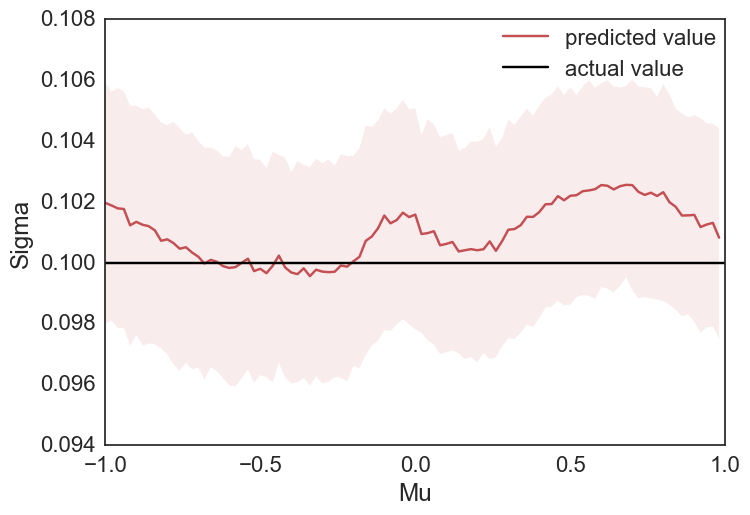

In [84]:
fig = pylab.figure()
sns.set_style("white")
pylab.plot(mu_s, sigmas, color='r', label="predicted value");
pylab.axhline(y=0.1, color='black', linestyle='-', label="actual value")
pylab.fill_between(mu_s, sigma_lower_16, sigma_upper_84, color='r', alpha=0.1, edgecolor='none')
pylab.xlabel("Mu")
pylab.ylabel("Sigma")

pylab.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0.)
pylab.show();
fig.savefig(ROOT_DIR + "/Images/Output-Sensitivity-Results/ConvolutionalNN-MultipleOutput-ELU/Varying-Mu/"+"sigma.png")

In [85]:
jump_sigmas = np.array(preds_MEAN)[:,2].reshape(100)
jump_sigmas_upper_84 = np.array(preds_Upper_84)[:,2].reshape(100)
jump_sigmas_lower_16 = np.array(preds_Lower_16)[:,2].reshape(100)

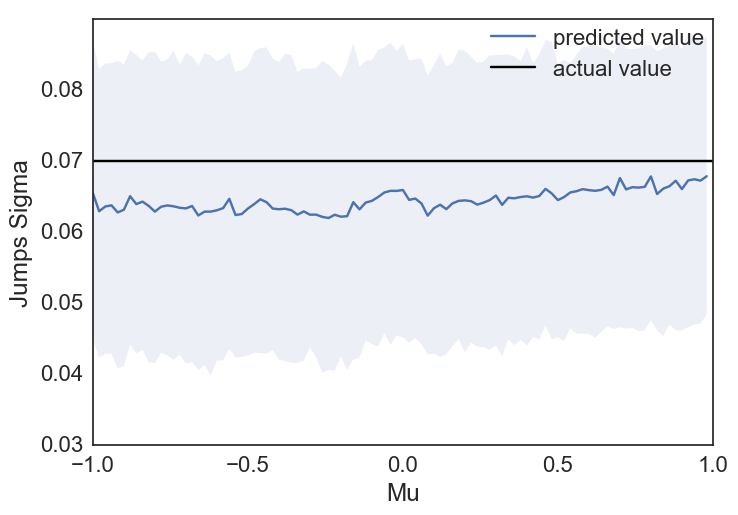

In [86]:
fig = pylab.figure()
pylab.plot(mu_s, jump_sigmas, color='b', label="predicted value");
pylab.axhline(y=0.07, color='black', linestyle='-', label="actual value")
pylab.fill_between(mu_s, jump_sigmas_lower_16, jump_sigmas_upper_84, color='b', alpha=0.1, edgecolor='none')
pylab.xlabel("Mu")
pylab.ylabel("Jumps Sigma")

pylab.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0.)
pylab.show();
fig.savefig(ROOT_DIR + "/Images/Output-Sensitivity-Results/ConvolutionalNN-MultipleOutput-ELU/Varying-Mu/"+"Jumps_Sigma.png")

In [87]:
jump_mus = np.array(preds_MEAN)[:,3].reshape(100)
jump_mus_upper_84 = np.array(preds_Upper_84)[:,3].reshape(100)
jump_mus_lower_16 = np.array(preds_Lower_16)[:,3].reshape(100)

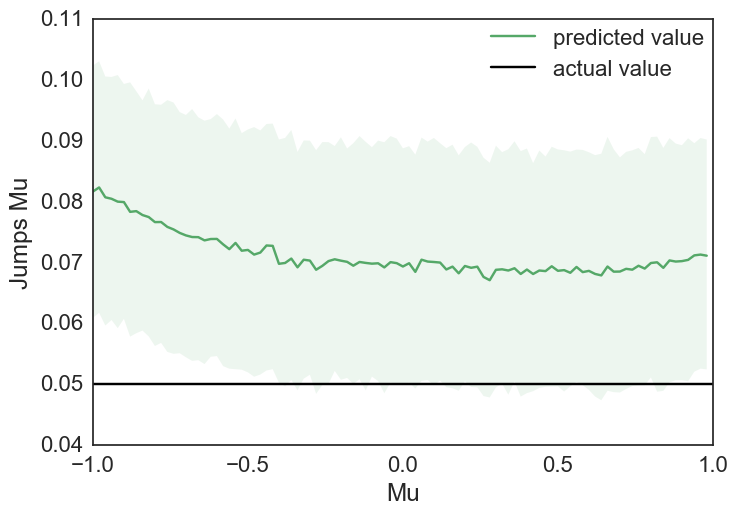

In [88]:
fig = pylab.figure()
pylab.plot(mu_s, jump_mus, color='g', label="predicted value");
pylab.axhline(y=0.05, color='black', linestyle='-', label="actual value")
pylab.fill_between(mu_s, jump_mus_lower_16, jump_mus_upper_84, color='g', alpha=0.1, edgecolor='none')
pylab.xlabel("Mu")
pylab.ylabel("Jumps Mu")

pylab.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0.)
pylab.show();
fig.savefig(ROOT_DIR + "/Images/Output-Sensitivity-Results/ConvolutionalNN-MultipleOutput-ELU/Varying-Mu/"+"Jumps_Mu.png")

In [89]:
lambdas = np.array(preds_MEAN)[:,4].reshape(100)
lambdas_upper_84 = np.array(preds_Upper_84)[:,4].reshape(100)
lambdas_lower_16 = np.array(preds_Lower_16)[:,4].reshape(100)

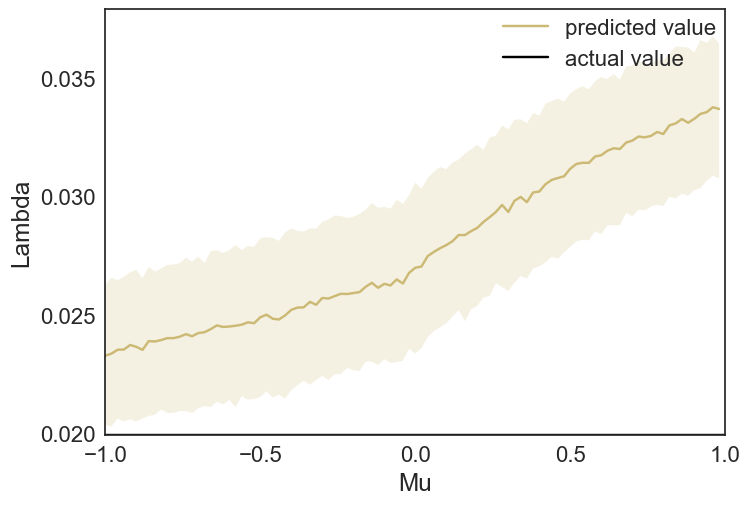

In [90]:
fig = pylab.figure()
pylab.plot(mu_s, lambdas, color='y', label="predicted value");
pylab.axhline(y=0.02, color='black', linestyle='-', label="actual value")
pylab.fill_between(mu_s, lambdas_lower_16, lambdas_upper_84, color='y', alpha=0.2, edgecolor='none')
pylab.xlabel("Mu")
pylab.ylabel("Lambda")

pylab.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0.)
pylab.show();
fig.savefig(ROOT_DIR + "/Images/Output-Sensitivity-Results/ConvolutionalNN-MultipleOutput-ELU/Varying-Mu/"+"Lambda.png")

In [91]:
mus_ = np.array(preds_MEAN)[:,1].reshape(100)
mus_upper_84 = np.array(preds_Upper_84)[:,1].reshape(100)
mus_lower_16 = np.array(preds_Lower_16)[:,1].reshape(100)

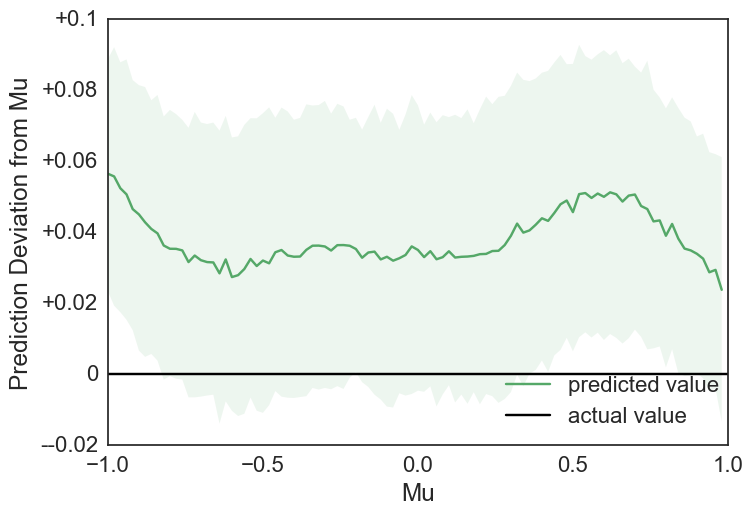

In [92]:
fig = pylab.figure()
pylab.plot(mu_s, mus_-mu_s, color='g', label="predicted value");
#pylab.plot(0, mu_s, color='black', alpha = 0.5, label="actual value");
pylab.axhline(y=0, color='black', linestyle='-', label="actual value")
pylab.fill_between(mu_s, mus_lower_16-mu_s, mus_upper_84-mu_s, color='g', alpha=0.1, edgecolor='none')
pylab.xlabel("Mu")
pylab.ylabel("Prediction Deviation from Mu")
ax = pylab.gca()
vals = ax.get_yticks()
ax.set_yticklabels(['-'+str(x) for x in vals[vals<0]] + [0] + ['+'+str(x) for x in vals[vals>0]])

pylab.legend(bbox_to_anchor=(1, 0.185), loc=1, borderaxespad=0.)
pylab.show();
fig.savefig(ROOT_DIR + "/Images/Output-Sensitivity-Results/ConvolutionalNN-MultipleOutput-ELU/Varying-Mu/"+"Mu.png")

# Sensitivity Test - Sigma

In [43]:
sigma_s = []
preds_MEAN = []
preds_Lower_16 = []
preds_Upper_84 = []
mp = test_set_model_params()

for j in range(100):
    #covnet_mo_elu = covnet_multiple_output_with_ELUs()
    #covnet_mo_elu.load_weights(H5_DIR_COVNET_MULTIPLE_ELU)
    covnet_mo_elu = load_model("FULLMODEL_RELAXED_ELU_COVNET.h5")
    
    mp.all_sigma = 0.001 + j*(0.2 - 0.001)/100
    test_set = []
    
    print(j)
    
    print("GENERATION...")
    test_set_pred = standard_convolutional_test_set()
    
    print("PREDICTION...\n")
    predictions_elu = covnet_mo_elu.predict(test_set_pred)
    
    print(np.transpose(np.mean(predictions_elu, axis = 1)))
    print("   sigma,    mu,      jump_sigma,      jump_mu,    lambda")
    print("   "+str(mp.all_sigma)+"      0.05       0.07              0.05       0.02")
    print(np.mean(predictions_elu, axis = 1)+np.std(predictions_elu, axis = 1))
    print(np.percentile(predictions_elu, 84, axis = 1))
    preds_MEAN.append(np.mean(predictions_elu, axis = 1))
    preds_Upper_84.append(np.percentile(predictions_elu, 84, axis = 1))
    preds_Lower_16.append(np.percentile(predictions_elu, 16, axis = 1))
    sigma_s.append(mp.all_sigma)
    
np.save("Sensitivity_Test-Covnet_MO_Sigma_sigma_s.npy", sigma_s)
np.save("Sensitivity_Test-Covnet_MO_Sigma_preds_MEAN.npy", preds_MEAN)
np.save("Sensitivity_Test-Covnet_MO_Sigma_preds_Upper_84.npy", preds_Upper_84)
np.save("Sensitivity_Test-Covnet_MO_Sigma_preds_Lower_16.npy", preds_Lower_16)

KeyboardInterrupt: 

In [98]:
sigma_s = np.load("Sensitivity_Test-Covnet_MO_Sigma_sigma_s.npy")
preds_MEAN = np.load("Sensitivity_Test-Covnet_MO_Sigma_preds_MEAN.npy")
preds_Upper_84 = np.load("Sensitivity_Test-Covnet_MO_Sigma_preds_Upper_84.npy")
preds_Lower_16 = np.load("Sensitivity_Test-Covnet_MO_Sigma_preds_Lower_16.npy")

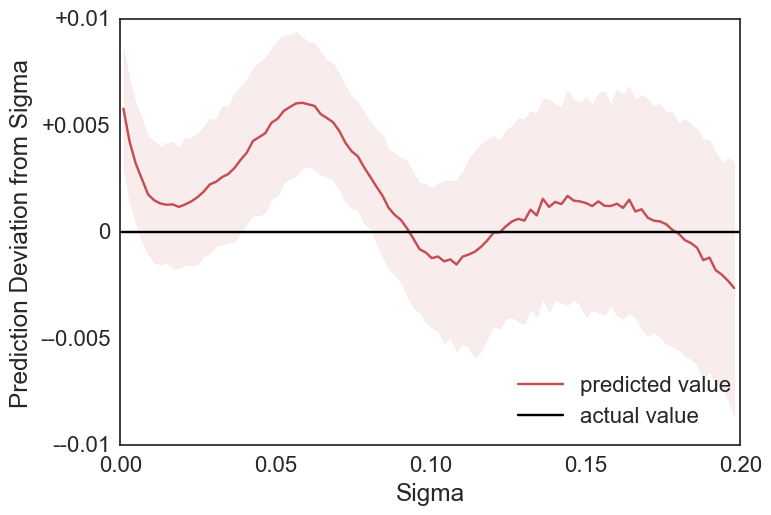

In [102]:
sigmas = np.array(preds_MEAN)[:,0].reshape(100)
sigma_upper_84 = np.array(preds_Upper_84)[:,0].reshape(100)
sigma_lower_16 = np.array(preds_Lower_16)[:,0].reshape(100)

fig = pylab.figure()
pylab.plot(sigma_s, sigmas-sigma_s, color='r', label="predicted value");
#pylab.plot(sigma_s, sigma_s, color='black', label="actual value");
pylab.axhline(y=0, color='black', linestyle='-', label="actual value")
pylab.fill_between(sigma_s, sigma_lower_16-sigma_s, sigma_upper_84-sigma_s, color='r', alpha=0.1, edgecolor='none')
pylab.xlabel("Sigma")
pylab.ylabel("Prediction Deviation from Sigma")
ax = pylab.gca()
vals = ax.get_yticks()
ax.set_yticklabels(['-'+str(x) for x in vals[vals<0]] + [0] + ['+'+str(x) for x in vals[vals>0]])


pylab.legend(bbox_to_anchor=(1, 0.185), loc=0, borderaxespad=0.)
pylab.show();
fig.savefig(ROOT_DIR + "/Images/Output-Sensitivity-Results/ConvolutionalNN-MultipleOutput-ELU/Varying-Sigma/"+"Sigma.png")

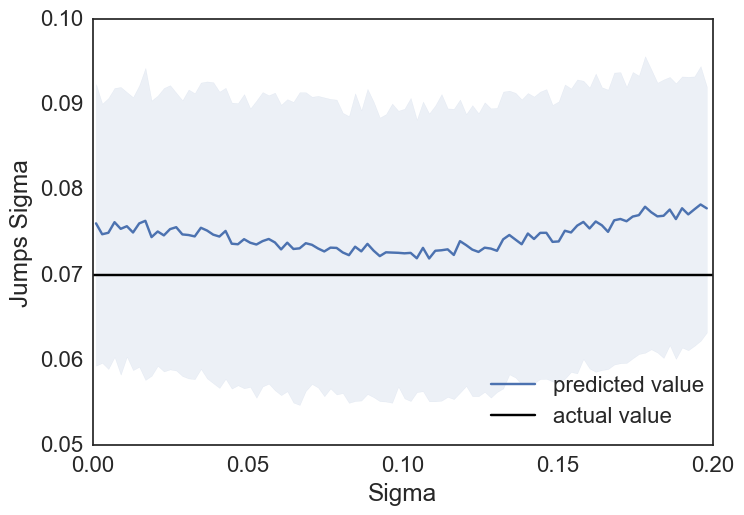

In [103]:
jump_sigmas = np.array(preds_MEAN)[:,2].reshape(100)
jump_sigmas_upper_84 = np.array(preds_Upper_84)[:,2].reshape(100)
jump_sigmas_lower_16 = np.array(preds_Lower_16)[:,2].reshape(100)

fig = pylab.figure()
pylab.plot(sigma_s, jump_sigmas, color='b', label="predicted value");
pylab.axhline(y=0.07, color='black', linestyle='-', label="actual value")
pylab.fill_between(sigma_s, jump_sigmas_lower_16, jump_sigmas_upper_84, color='b', alpha=0.1, edgecolor='none')
pylab.xlabel("Sigma")
pylab.ylabel("Jumps Sigma")

pylab.legend(bbox_to_anchor=(1, 0.185), loc=1, borderaxespad=0.)
pylab.show();
fig.savefig(ROOT_DIR + "/Images/Output-Sensitivity-Results/ConvolutionalNN-MultipleOutput-ELU/Varying-Sigma/"+"Jumps_Sigma.png")

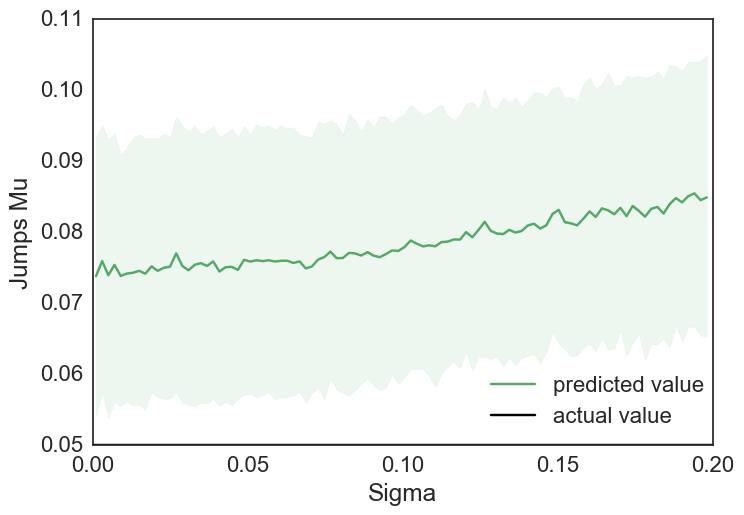

In [104]:
jump_mus = np.array(preds_MEAN)[:,3].reshape(100)
jump_mus_upper_84 = np.array(preds_Upper_84)[:,3].reshape(100)
jump_mus_lower_16 = np.array(preds_Lower_16)[:,3].reshape(100)

fig = pylab.figure()
pylab.plot(sigma_s, jump_mus, color='g', label="predicted value");
pylab.axhline(y=0.05, color='black', linestyle='-', label="actual value")
pylab.fill_between(sigma_s, jump_mus_lower_16, jump_mus_upper_84, color='g', alpha=0.1, edgecolor='none')
pylab.xlabel("Sigma")
pylab.ylabel("Jumps Mu")

pylab.legend(bbox_to_anchor=(1, 0.185), loc=1, borderaxespad=0.)
pylab.show();
fig.savefig(ROOT_DIR + "/Images/Output-Sensitivity-Results/ConvolutionalNN-MultipleOutput-ELU/Varying-Sigma/"+"Jumps_Mu.png")

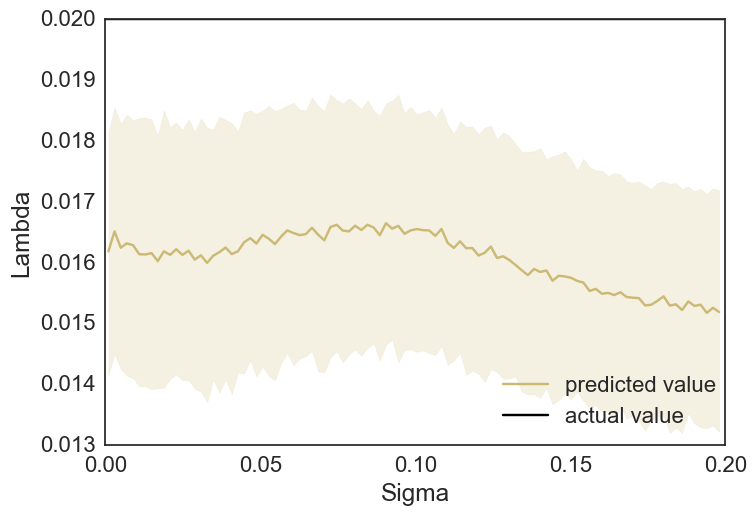

In [105]:
lambdas = np.array(preds_MEAN)[:,4].reshape(100)
lambdas_upper_84 = np.array(preds_Upper_84)[:,4].reshape(100)
lambdas_lower_16 = np.array(preds_Lower_16)[:,4].reshape(100)

fig = pylab.figure()
pylab.plot(sigma_s, lambdas, color='y', label="predicted value");
pylab.axhline(y=0.02, color='black', linestyle='-', label="actual value")
pylab.fill_between(sigma_s, lambdas_lower_16, lambdas_upper_84, color='y', alpha=0.2, edgecolor='none')
pylab.xlabel("Sigma")
pylab.ylabel("Lambda")

pylab.legend(bbox_to_anchor=(1, 0.185), loc=1, borderaxespad=0.)
pylab.show();
fig.savefig(ROOT_DIR + "/Images/Output-Sensitivity-Results/ConvolutionalNN-MultipleOutput-ELU/Varying-Sigma/"+"Lambda.png")

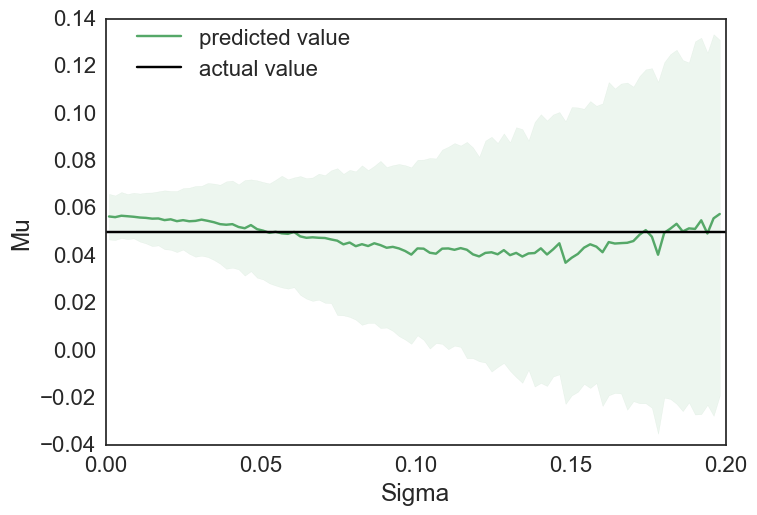

In [106]:
mus_ = np.array(preds_MEAN)[:,1].reshape(100)
mus_upper_84 = np.array(preds_Upper_84)[:,1].reshape(100)
mus_lower_16 = np.array(preds_Lower_16)[:,1].reshape(100)

fig = pylab.figure()
pylab.plot(sigma_s, mus_, color='g', label="predicted value");
pylab.axhline(y=0.05, color='black', linestyle='-', label="actual value")
pylab.fill_between(sigma_s, mus_lower_16, mus_upper_84, color='g', alpha=0.1, edgecolor='none')
pylab.xlabel("Sigma")
pylab.ylabel("Mu")

pylab.legend(bbox_to_anchor=(0.4085, 1), loc=1, borderaxespad=0.)
pylab.show();
fig.savefig(ROOT_DIR + "/Images/Output-Sensitivity-Results/ConvolutionalNN-MultipleOutput-ELU/Varying-Sigma/"+"Mu.png")

# Sensitivity Test - Jumps Sigma

In [44]:
jump_sigma_s = []
preds_MEAN = []
preds_Lower_16 = []
preds_Upper_84 = []

mp = test_set_model_params()

for j in range(100):
    #covnet_mo_elu = covnet_multiple_output_with_ELUs()
    #covnet_mo_elu.load_weights(H5_DIR_COVNET_MULTIPLE_ELU)
    covnet_mo_elu = load_model("FULLMODEL_RELAXED_ELU_COVNET.h5")
    
    mp.jumps_sigma = 0.001 + j*(0.2 - 0.001)/100
    test_set = []
    
    print(str(j) + " out of "+str(100))
    
    print("GENERATION...")
    test_set_pred = standard_convolutional_test_set()
    
    
    print("PREDICTION...\n")
    predictions_elu = covnet_mo_elu.predict(test_set_pred)
    
    print(np.transpose(np.mean(predictions_elu, axis = 1)))
    print("   sigma,    mu,      jump_sigma,      jump_mu,    lambda")
    print("   0.1      0.05       "+str(mp.jumps_sigma)+"              0.05       0.02")
    preds_MEAN.append(np.mean(predictions_elu, axis = 1))
    jump_sigma_s.append(mp.jumps_sigma)
    preds_Upper_84.append(np.percentile(predictions_elu, 84, axis = 1))
    preds_Lower_16.append(np.percentile(predictions_elu, 16, axis = 1))
    
np.save("Sensitivity_Test-Covnet_MO_JumpSigma_preds_Upper_84.npy", preds_Upper_84)
np.save("Sensitivity_Test-Covnet_MO_JumpSigma_preds_Lower_16.npy", preds_Lower_16)
np.save("Sensitivity_Test-Covnet_MO_JumpSigma_jump_sigma_s.npy", jump_sigma_s)
np.save("Sensitivity_Test-Covnet_MO_JumpSigma_preds_MEAN.npy", preds_MEAN)

0 out of 100
GENERATION...
0
100
200
300
400
500
600
700


KeyboardInterrupt: 

In [108]:
preds_Upper_84 = np.load("Sensitivity_Test-Covnet_MO_JumpSigma_preds_Upper_84.npy")
preds_Lower_16 = np.load("Sensitivity_Test-Covnet_MO_JumpSigma_preds_Lower_16.npy")
jump_sigma_s = np.load("Sensitivity_Test-Covnet_MO_JumpSigma_jump_sigma_s.npy")
preds_MEAN = np.load("Sensitivity_Test-Covnet_MO_JumpSigma_preds_MEAN.npy")

In [ ]:
def sensitivity_plot_w_true_value(x_values, predictions, true_value, upper_confidence_predictions, lower_confidence_predictions, 
                                  x_name, y_name, line_color = 'b', save_dir = None, legend_anchor = (1,1)):
    fig = pylab.figure()
    pylab.plot(x_values, predictions, color=line_color, label="predicted value");
    pylab.axhline(y=true_value, color='black', linestyle='-', label="actual value")
    pylab.fill_between(x_values, mus_lower_16, mus_upper_84, color=line_color, alpha=0.1, edgecolor='none')
    pylab.xlabel(x_name)
    pylab.ylabel(y_name)

    pylab.legend(bbox_to_anchor=legend_anchor, loc=1, borderaxespad=0.)
    if save_dir != None:
        fig.savefig(save_dir)
    
    return fig

In [ ]:
mus_ = np.array(preds_MEAN)[:,1].reshape(100)
mus_upper_84 = np.array(preds_Upper_84)[:,1].reshape(100)
mus_lower_16 = np.array(preds_Lower_16)[:,1].reshape(100)
save_dir = ROOT_DIR + "/Images/Output-Sensitivity-Results/ConvolutionalNN-MultipleOutput-ELU/Varying-Jumps_sigma/"+"Mu.png"

sensitivity_plot_w_true_value(jump_sigma_s, mus_, test_set_model_params().jumps_sigma, mus_upper_84, mus_lower_16, 
                              "Jumps Mu", "Mu", line_color = 'g', save_dir = "./Mu.png")

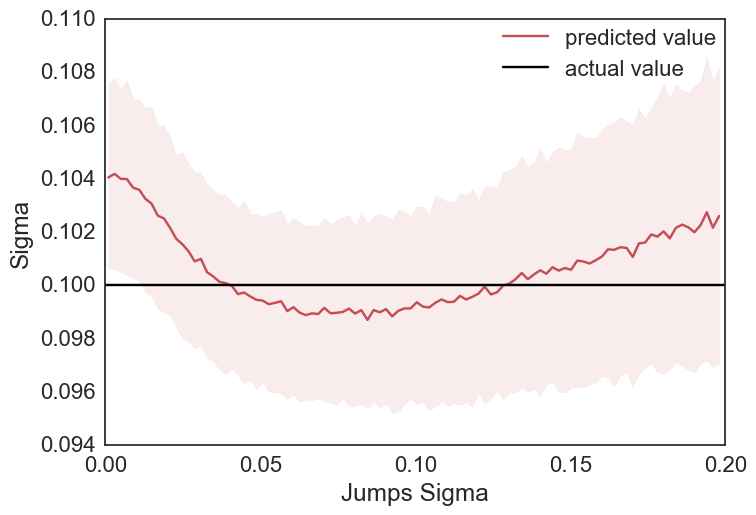

In [111]:
sigmas = np.array(preds_MEAN)[:,0].reshape(100)
sigmas_upper_84 = np.array(preds_Upper_84)[:,0].reshape(100)
sigmas_lower_16 = np.array(preds_Lower_16)[:,0].reshape(100)

fig = pylab.figure()
pylab.plot(jump_sigma_s, sigmas, color='r', label="predicted value");
pylab.axhline(y=0.1, color='black', linestyle='-', label="actual value")
pylab.fill_between(jump_sigma_s, sigmas_lower_16, sigmas_upper_84, color='r', alpha=0.1, edgecolor='none')
pylab.xlabel("Jumps Sigma")
pylab.ylabel("Sigma")

pylab.legend(bbox_to_anchor=(1, 1), loc=0, borderaxespad=0.)
pylab.show();
fig.savefig(ROOT_DIR + "/Images/Output-Sensitivity-Results/ConvolutionalNN-MultipleOutput-ELU/Varying-Jumps_sigma/"+"Sigma.png")

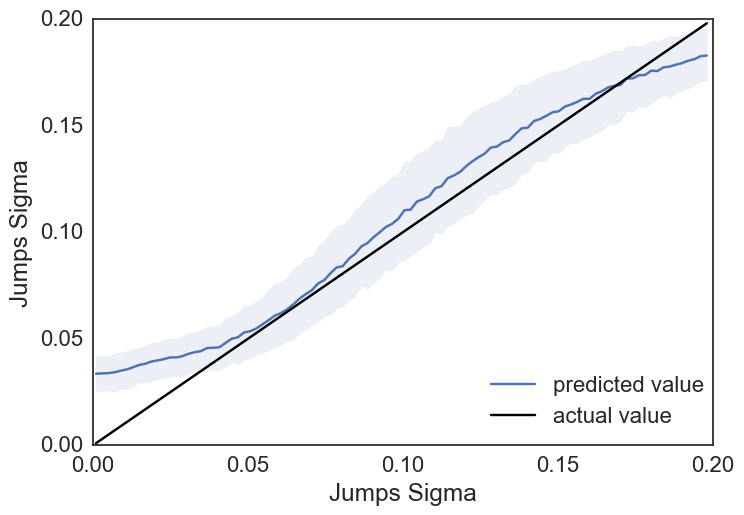

In [112]:
jump_sigmas = np.array(preds_MEAN)[:,2].reshape(100)
jump_sigmas_upper_84 = np.array(preds_Upper_84)[:,2].reshape(100)
jump_sigmas_lower_16 = np.array(preds_Lower_16)[:,2].reshape(100)

fig = pylab.figure()
pylab.plot(jump_sigma_s, jump_sigmas, color='b', label="predicted value");
pylab.plot(jump_sigma_s, jump_sigma_s, color='black', label="actual value");
pylab.fill_between(jump_sigma_s, jump_sigmas_lower_16, jump_sigmas_upper_84, color='b', alpha=0.1, edgecolor='none')
pylab.xlabel("Jumps Sigma")
pylab.ylabel("Jumps Sigma")

pylab.legend(bbox_to_anchor=(1, 0.185), loc=1, borderaxespad=0.)
pylab.show();
fig.savefig(ROOT_DIR + "/Images/Output-Sensitivity-Results/ConvolutionalNN-MultipleOutput-ELU/Varying-Jumps_sigma/"+"Jumps_Sigma.png")

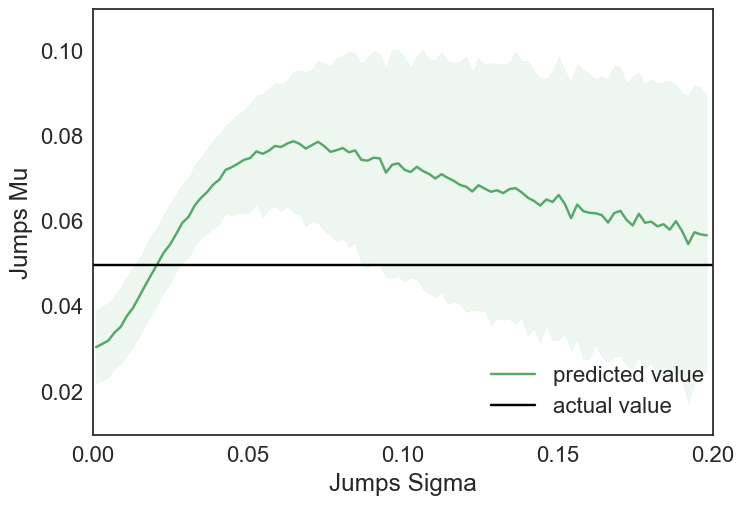

In [113]:
jump_mus = np.array(preds_MEAN)[:,3].reshape(100)
jump_mus_upper_84 = np.array(preds_Upper_84)[:,3].reshape(100)
jump_mus_lower_16 = np.array(preds_Lower_16)[:,3].reshape(100)

fig = pylab.figure()
pylab.plot(jump_sigma_s, jump_mus, color='g', label="predicted value");
pylab.axhline(y=0.05, color='black', linestyle='-', label="actual value")
pylab.fill_between(jump_sigma_s, jump_mus_lower_16, jump_mus_upper_84, color='g', alpha=0.1, edgecolor='none')
pylab.xlabel("Jumps Sigma")
pylab.ylabel("Jumps Mu")

pylab.legend(bbox_to_anchor=(1, 0.185), loc=1, borderaxespad=0.)
pylab.show();
fig.savefig(ROOT_DIR + "/Images/Output-Sensitivity-Results/ConvolutionalNN-MultipleOutput-ELU/Varying-Jumps_sigma/"+"Jumps_Mu.png")

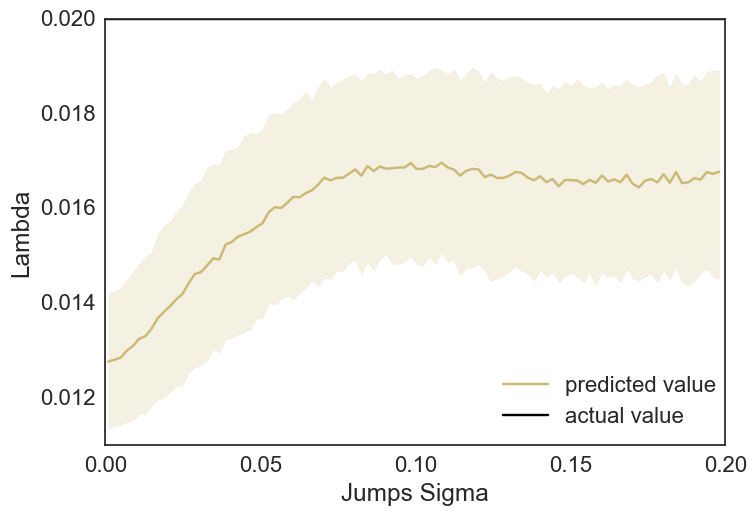

In [114]:
lambdas = np.array(preds_MEAN)[:,4].reshape(100)
lambdas_upper_84 = np.array(preds_Upper_84)[:,4].reshape(100)
lambdas_lower_16 = np.array(preds_Lower_16)[:,4].reshape(100)

fig = pylab.figure()
pylab.plot(jump_sigma_s, lambdas, color='y', label="predicted value");
pylab.axhline(y=0.02, color='black', linestyle='-', label="actual value")
pylab.fill_between(jump_sigma_s, lambdas_lower_16, lambdas_upper_84, color='y', alpha=0.2, edgecolor='none')
pylab.xlabel("Jumps Sigma")
pylab.ylabel("Lambda")

pylab.legend(bbox_to_anchor=(1, 0.185), loc=1, borderaxespad=0.)
pylab.show();
fig.savefig(ROOT_DIR + "/Images/Output-Sensitivity-Results/ConvolutionalNN-MultipleOutput-ELU/Varying-Jumps_sigma/"+"Lambda.png")

# Sensitivity Test - Jumps Mu

In [17]:
jump_mu_s = []
preds_MEAN = []
preds_Upper_84 = []
preds_Lower_16 = []

mp = test_set_model_params()

for j in range(100):
    #covnet_mo_elu = covnet_multiple_output_with_ELUs()
    #covnet_mo_elu.load_weights(H5_DIR_COVNET_MULTIPLE_ELU)
    covnet_mo_elu = load_model("FULLMODEL_RELAXED_ELU_COVNET.h5")
    
    mp.jumps_mu = -0.5 + j/100
    test_set = []
    
    print(j)
    
    print("GENERATION...")
    test_set_pred = standard_convolutional_test_set()
    
    
    print("PREDICTION...\n")
    predictions_elu = covnet_mo_elu.predict(test_set_pred)
    
    print(np.transpose(np.mean(predictions_elu, axis = 1)))
    print("   sigma,    mu,      jump_sigma,      jump_mu,    lambda")
    print("   0.1      0.05       0.07              "+str(mp.jumps_mu)+"       0.02")
    preds_MEAN.append(np.mean(predictions_elu, axis = 1))
    jump_mu_s.append(mp.jumps_mu)
    preds_Upper_84.append(np.percentile(predictions_elu, 84, axis = 1))
    preds_Lower_16.append(np.percentile(predictions_elu, 16, axis = 1))
    
np.save("Sensitivity_Test-Covnet_MO_JumpMu_preds_Upper_84.npy", preds_Upper_84)
np.save("Sensitivity_Test-Covnet_MO_JumpMu_preds_Lower_16.npy", preds_Lower_16)
    
np.save("Sensitivity_Test-Covnet_MO_JumpMu_jump_mu_s.npy", jump_mu_s)
np.save("Sensitivity_Test-Covnet_MO_JumpMu_preds_MEAN.npy", preds_MEAN)

0
GENERATION...
PREDICTION...

[[ 0.09415717  0.0217211   0.10640576 -0.48272899  0.01864377]]
   sigma,    mu,      jump_sigma,      jump_mu,    lambda
   0.1      0.05       0.07              -0.5       0.02
1
GENERATION...
PREDICTION...

[[ 0.09432612  0.02213568  0.10422052 -0.47505498  0.01850742]]
   sigma,    mu,      jump_sigma,      jump_mu,    lambda
   0.1      0.05       0.07              -0.49       0.02
2
GENERATION...
PREDICTION...

[[ 0.09516995  0.02178272  0.10276531 -0.4663873   0.0184858 ]]
   sigma,    mu,      jump_sigma,      jump_mu,    lambda
   0.1      0.05       0.07              -0.48       0.02
3
GENERATION...
PREDICTION...

[[ 0.09545214  0.02336014  0.09926561 -0.45826158  0.018472  ]]
   sigma,    mu,      jump_sigma,      jump_mu,    lambda
   0.1      0.05       0.07              -0.47       0.02
4
GENERATION...
PREDICTION...

[[ 0.09564953  0.02211424  0.09690157 -0.44979483  0.01844982]]
   sigma,    mu,      jump_sigma,      jump_mu,    lambda
   0

In [242]:
preds_Upper_84 = np.load("Sensitivity_Test-Covnet_MO_JumpMu_preds_Upper_84.npy")
preds_Lower_16 = np.load("Sensitivity_Test-Covnet_MO_JumpMu_preds_Lower_16.npy")
    
jump_mu_s = np.load("Sensitivity_Test-Covnet_MO_JumpMu_jump_mu_s.npy")
preds_MEAN = np.load("Sensitivity_Test-Covnet_MO_JumpMu_preds_MEAN.npy")

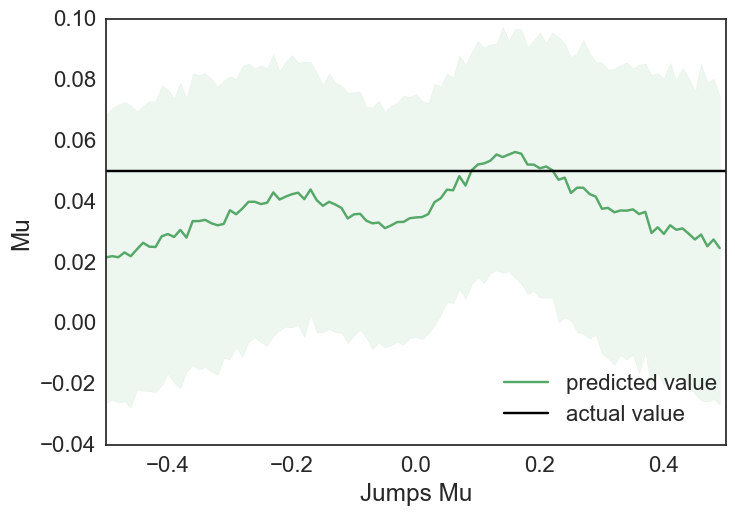

In [243]:
mus_ = np.array(preds_MEAN)[:,1].reshape(100)
mus_upper_84 = np.array(preds_Upper_84)[:,1].reshape(100)
mus_lower_16 = np.array(preds_Lower_16)[:,1].reshape(100)

fig = pylab.figure()
pylab.plot(jump_mu_s, mus_, color='g', label="predicted value");
pylab.axhline(y=0.05, color='black', linestyle='-', label="actual value")
pylab.fill_between(jump_mu_s, mus_lower_16, mus_upper_84, color='g', alpha=0.1, edgecolor='none')
pylab.xlabel("Jumps Mu")
pylab.ylabel("Mu")
pylab.xlim(-0.5, 0.5)

pylab.legend(bbox_to_anchor=(1, 0.19), loc=1, borderaxespad=0.)
pylab.show();
fig.savefig(ROOT_DIR + "/Images/Output-Sensitivity-Results/ConvolutionalNN-MultipleOutput-ELU/Varying-Jumps_mu/"+"Mu.png")

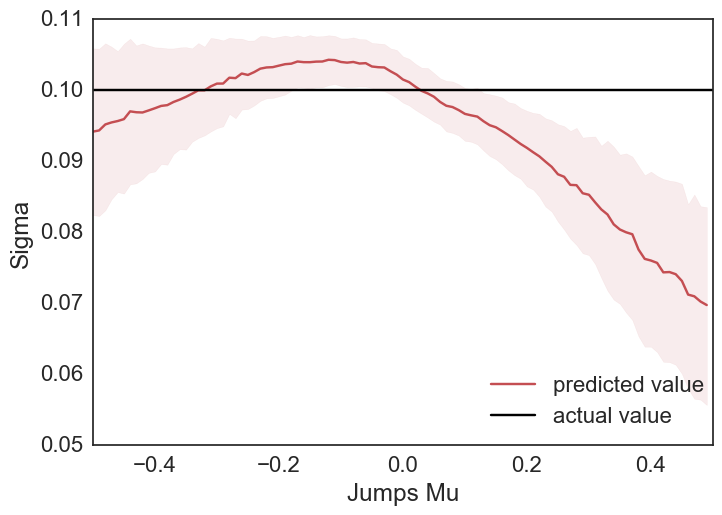

In [244]:
sigmas = np.array(preds_MEAN)[:,0].reshape(100)
sigmas_upper_84 = np.array(preds_Upper_84)[:,0].reshape(100)
sigmas_lower_16 = np.array(preds_Lower_16)[:,0].reshape(100)

fig = pylab.figure()
pylab.plot(jump_mu_s, sigmas, color='r', label="predicted value");
pylab.axhline(y=0.1, color='black', linestyle='-', label="actual value")
pylab.fill_between(jump_mu_s, sigmas_lower_16, sigmas_upper_84, color='r', alpha=0.1, edgecolor='none')
pylab.xlabel("Jumps Mu")
pylab.ylabel("Sigma")
pylab.xlim(-0.5, 0.5)

pylab.legend(bbox_to_anchor=(1, 0.185), loc=0, borderaxespad=0.)
pylab.show();
fig.savefig(ROOT_DIR + "/Images/Output-Sensitivity-Results/ConvolutionalNN-MultipleOutput-ELU/Varying-Jumps_mu/"+"Sigma.png")

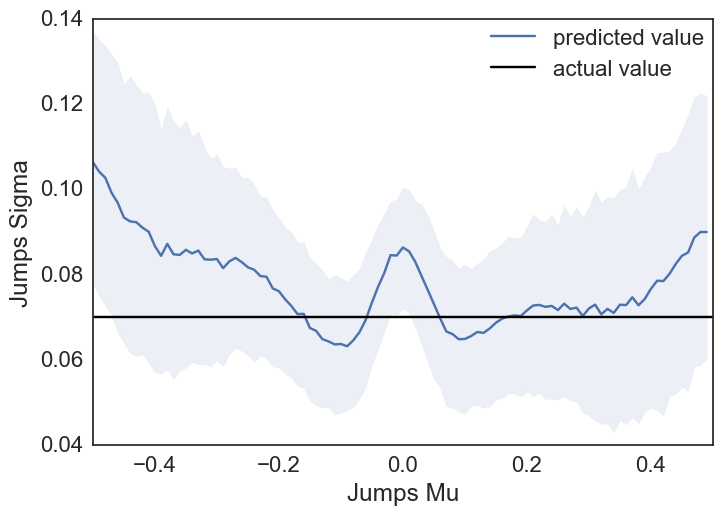

In [251]:
jump_sigmas = np.array(preds_MEAN)[:,2].reshape(100)
jump_sigmas_upper_84 = np.array(preds_Upper_84)[:,2].reshape(100)
jump_sigmas_lower_16 = np.array(preds_Lower_16)[:,2].reshape(100)

fig = pylab.figure()
pylab.plot(jump_mu_s, jump_sigmas, color='b', label="predicted value");
pylab.axhline(y=0.07, color='black', linestyle='-', label="actual value")
pylab.fill_between(jump_mu_s, jump_sigmas_lower_16, jump_sigmas_upper_84, color='b', alpha=0.1, edgecolor='none')
pylab.xlabel("Jumps Mu")
pylab.ylabel("Jumps Sigma")
pylab.xlim(-0.5, 0.5)

pylab.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0.)
pylab.show();
fig.savefig(ROOT_DIR + "/Images/Output-Sensitivity-Results/ConvolutionalNN-MultipleOutput-ELU/Varying-Jumps_mu/"+"Jumps_Sigma.png")

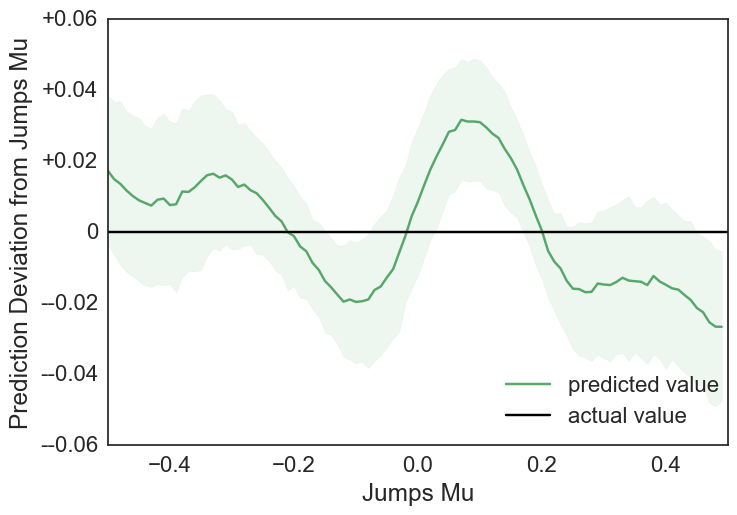

In [255]:
jump_mus = np.array(preds_MEAN)[:,3].reshape(100)
jump_mus_upper_84 = np.array(preds_Upper_84)[:,3].reshape(100)
jump_mus_lower_16 = np.array(preds_Lower_16)[:,3].reshape(100)

fig = pylab.figure()
pylab.plot(jump_mu_s, jump_mus-jump_mu_s, color='g', label="predicted value");
pylab.axhline(y=0, color='black', linestyle='-', label="actual value")

#pylab.plot(jump_mu_s, jump_mu_s, color='black', label="actual value");
pylab.fill_between(jump_mu_s, jump_mus_lower_16-jump_mu_s, jump_mus_upper_84-jump_mu_s, color='g', alpha=0.1, edgecolor='none')
pylab.xlabel("Jumps Mu")
pylab.ylabel("Prediction Deviation from Jumps Mu")
pylab.xlim(-0.5, 0.5)
ax = pylab.gca()
vals = ax.get_yticks()
ax.set_yticklabels(['-'+str(x) for x in vals[vals<0]] + [0] + ['+'+str(x) for x in vals[vals>0]])


pylab.legend(bbox_to_anchor=(1, 0.185), loc=1, borderaxespad=0.)
pylab.show();
fig.savefig(ROOT_DIR + "/Images/Output-Sensitivity-Results/ConvolutionalNN-MultipleOutput-ELU/Varying-Jumps_mu/"+"Jumps_Mu.png")

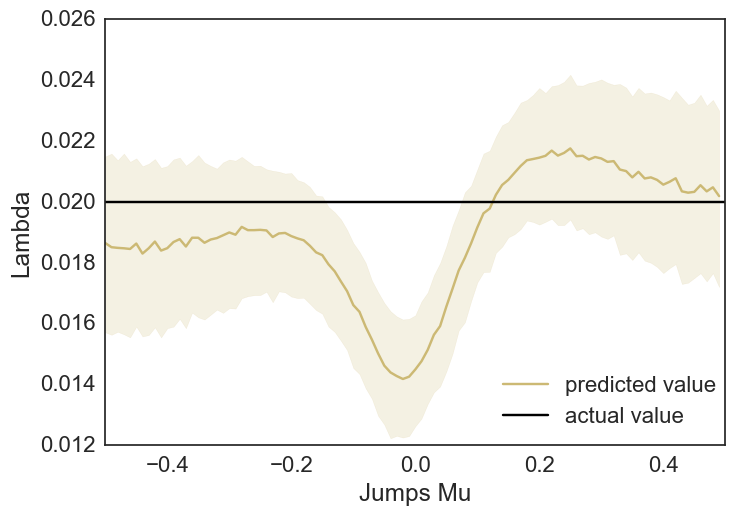

In [254]:
lambdas = np.array(preds_MEAN)[:,4].reshape(100)
lambdas_upper_84 = np.array(preds_Upper_84)[:,4].reshape(100)
lambdas_lower_16 = np.array(preds_Lower_16)[:,4].reshape(100)

fig = pylab.figure()
pylab.plot(jump_mu_s, lambdas, color='y', label="predicted value");
pylab.axhline(y=0.02, color='black', linestyle='-', label="actual value")
pylab.fill_between(jump_mu_s, lambdas_lower_16, lambdas_upper_84, color='y', alpha=0.2, edgecolor='none')
pylab.xlabel("Jumps Mu")
pylab.ylabel("Lambda")
pylab.xlim(-0.5, 0.5)

pylab.legend(bbox_to_anchor=(1, 0.185), loc=1, borderaxespad=0.)
pylab.show();
fig.savefig(ROOT_DIR + "/Images/Output-Sensitivity-Results/ConvolutionalNN-MultipleOutput-ELU/Varying-Jumps_mu/"+"Lambda.png")

# Sensitivity Test - Lambda

In [45]:
jump_lambda_s = []
preds_MEAN = []
preds_Upper_84 = []
preds_Lower_16 = []
mp = test_set_model_params()

for j in range(100):
    #covnet_mo_elu = covnet_multiple_output_with_ELUs()
    #covnet_mo_elu.load_weights(H5_DIR_COVNET_MULTIPLE_ELU)
    covnet_mo_elu = load_model("FULLMODEL_RELAXED_ELU_COVNET.h5")
    
    mp.lamda = 0.0001 + j*(0.025 - 0.0001)/100
    test_set = []
    
    print(j)
    
    print("GENERATION...")
    test_set_pred = standard_convolutional_test_set()
    
    
    print("PREDICTION...\n")
    predictions_elu = covnet_mo_elu.predict(test_set_pred)
    
    print(np.transpose(np.mean(predictions_elu, axis = 1)))
    print("   sigma,    mu,      jump_sigma,      jump_mu,    lambda")
    print("   0.1      0.05       0.07              0.05       "+str(mp.lamda))
    preds_MEAN.append(np.mean(predictions_elu, axis = 1))
    jump_lambda_s.append(mp.lamda)
    preds_Upper_84.append(np.percentile(predictions_elu, 84, axis = 1))
    preds_Lower_16.append(np.percentile(predictions_elu, 16, axis = 1))
    
np.save("Sensitivity_Test-Covnet_MO_Lambda_preds_Upper_84.npy", preds_Upper_84)
np.save("Sensitivity_Test-Covnet_MO_Lambda_preds_Lower_16.npy", preds_Lower_16)
    
np.save("Sensitivity_Test-Covnet_MO_Lambda_jump_lambda_s.npy", jump_lambda_s)
np.save("Sensitivity_Test-Covnet_MO_Lambda_preds_MEAN.npy", preds_MEAN)

KeyboardInterrupt: 

In [231]:
preds_Upper_84 = np.load("Sensitivity_Test-Covnet_MO_Lambda_preds_Upper_84.npy")
preds_Lower_16 = np.load("Sensitivity_Test-Covnet_MO_Lambda_preds_Lower_16.npy")
    
jump_lambda_s = np.load("Sensitivity_Test-Covnet_MO_Lambda_jump_lambda_s.npy")
preds_MEAN = np.load("Sensitivity_Test-Covnet_MO_Lambda_preds_MEAN.npy")

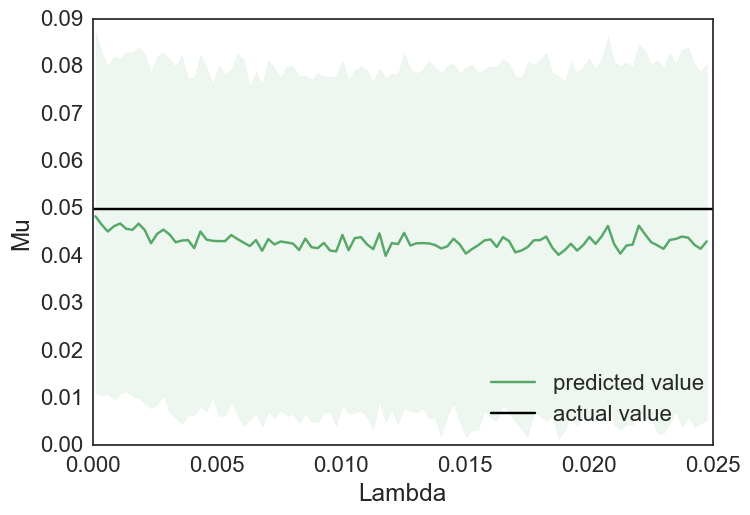

In [232]:
mus_ = np.array(preds_MEAN)[:,1].reshape(100)
mus_upper_84 = np.array(preds_Upper_84)[:,1].reshape(100)
mus_lower_16 = np.array(preds_Lower_16)[:,1].reshape(100)

fig = pylab.figure()
pylab.plot(jump_lambda_s, mus_, color='g', label="predicted value");
pylab.axhline(y=0.05, color='black', linestyle='-', label="actual value")
pylab.fill_between(jump_lambda_s, mus_lower_16, mus_upper_84, color='g', alpha=0.1, edgecolor='none')
pylab.xlabel("Lambda")
pylab.ylabel("Mu")

pylab.legend(bbox_to_anchor=(1, 0.19), loc=1, borderaxespad=0.)
pylab.show();
fig.savefig(ROOT_DIR + "/Images/Output-Sensitivity-Results/ConvolutionalNN-MultipleOutput-ELU/Varying-Lambda/"+"Mu.png")

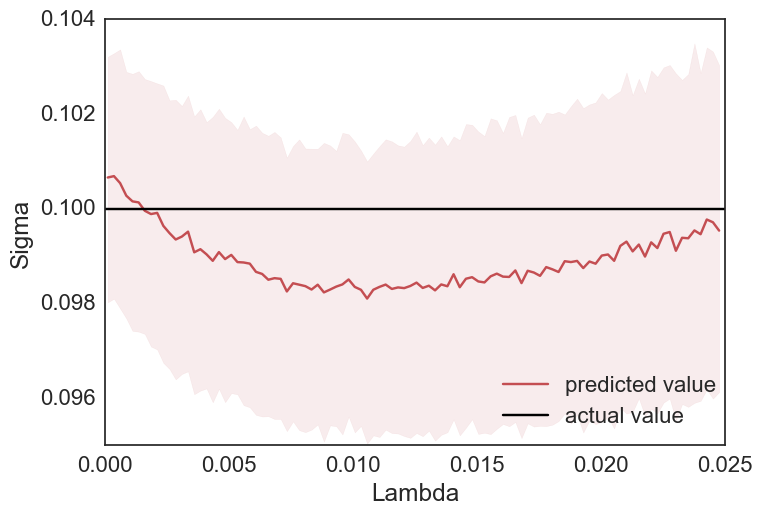

In [233]:
sigmas = np.array(preds_MEAN)[:,0].reshape(100)
sigmas_upper_84 = np.array(preds_Upper_84)[:,0].reshape(100)
sigmas_lower_16 = np.array(preds_Lower_16)[:,0].reshape(100)

fig = pylab.figure()
pylab.plot(jump_lambda_s, sigmas, color='r', label="predicted value");
pylab.axhline(y=0.1, color='black', linestyle='-', label="actual value")
pylab.fill_between(jump_lambda_s, sigmas_lower_16, sigmas_upper_84, color='r', alpha=0.1, edgecolor='none')
pylab.xlabel("Lambda")
pylab.ylabel("Sigma")

pylab.legend(bbox_to_anchor=(1, 0.185), loc=0, borderaxespad=0.)
pylab.show();
fig.savefig(ROOT_DIR + "/Images/Output-Sensitivity-Results/ConvolutionalNN-MultipleOutput-ELU/Varying-Lambda/"+"Sigma.png")

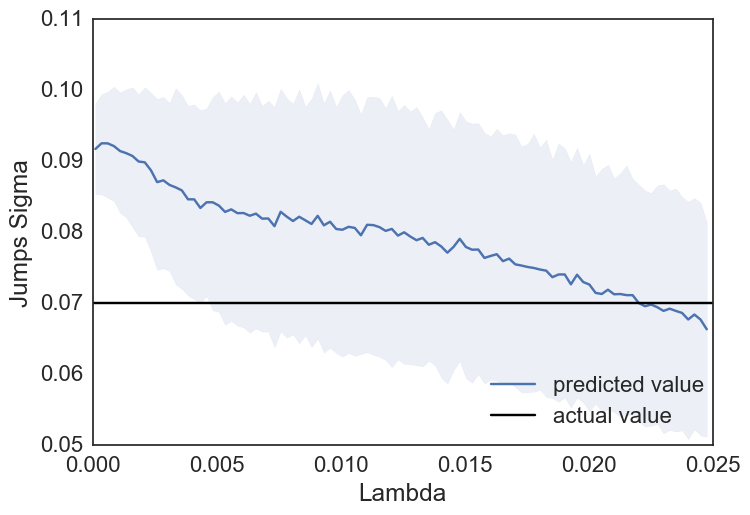

In [234]:
jump_sigmas = np.array(preds_MEAN)[:,2].reshape(100)
jump_sigmas_upper_84 = np.array(preds_Upper_84)[:,2].reshape(100)
jump_sigmas_lower_16 = np.array(preds_Lower_16)[:,2].reshape(100)

fig = pylab.figure()
pylab.plot(jump_lambda_s, jump_sigmas, color='b', label="predicted value");
pylab.axhline(y=0.07, color='black', linestyle='-', label="actual value")
pylab.fill_between(jump_lambda_s, jump_sigmas_lower_16, jump_sigmas_upper_84, color='b', alpha=0.1, edgecolor='none')
pylab.xlabel("Lambda")
pylab.ylabel("Jumps Sigma")

pylab.legend(bbox_to_anchor=(1, 0.185), loc=1, borderaxespad=0.)
pylab.show();
fig.savefig(ROOT_DIR + "/Images/Output-Sensitivity-Results/ConvolutionalNN-MultipleOutput-ELU/Varying-Lambda/"+"Jumps_Sigma.png")

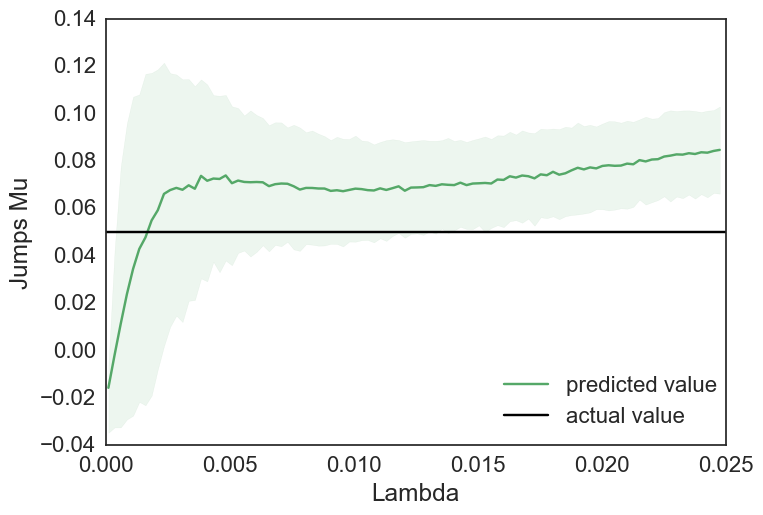

In [235]:
jump_mus = np.array(preds_MEAN)[:,3].reshape(100)
jump_mus_upper_84 = np.array(preds_Upper_84)[:,3].reshape(100)
jump_mus_lower_16 = np.array(preds_Lower_16)[:,3].reshape(100)

fig = pylab.figure()
pylab.plot(jump_lambda_s, jump_mus, color='g', label="predicted value");
pylab.axhline(y=0.05, color='black', linestyle='-', label="actual value")
pylab.fill_between(jump_lambda_s, jump_mus_lower_16, jump_mus_upper_84, color='g', alpha=0.1, edgecolor='none')
pylab.xlabel("Lambda")
pylab.ylabel("Jumps Mu")

pylab.legend(bbox_to_anchor=(1, 0.185), loc=1, borderaxespad=0.)
pylab.show();
fig.savefig(ROOT_DIR + "/Images/Output-Sensitivity-Results/ConvolutionalNN-MultipleOutput-ELU/Varying-Lambda/"+"Jumps_Mu.png")

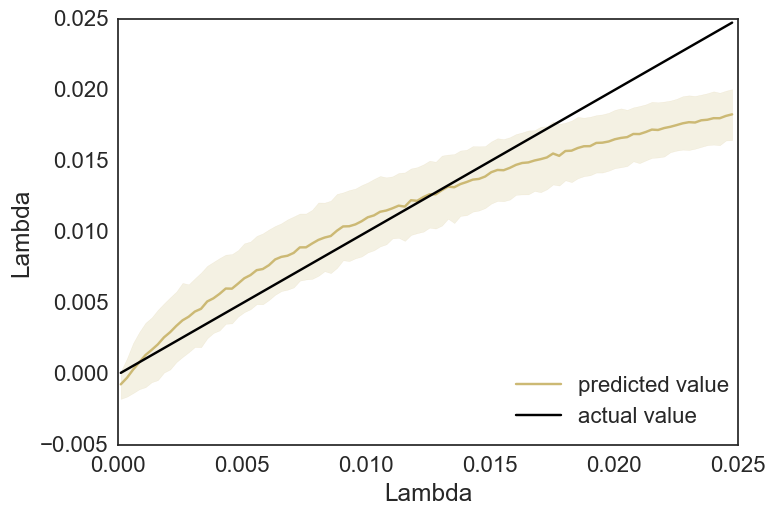

In [236]:
lambdas = np.array(preds_MEAN)[:,4].reshape(100)
lambdas_upper_84 = np.array(preds_Upper_84)[:,4].reshape(100)
lambdas_lower_16 = np.array(preds_Lower_16)[:,4].reshape(100)

fig = pylab.figure()
pylab.plot(jump_lambda_s, lambdas, color='y', label="predicted value");
pylab.plot(jump_lambda_s, jump_lambda_s, color='black', label="actual value");
pylab.fill_between(jump_lambda_s, lambdas_lower_16, lambdas_upper_84, color='y', alpha=0.2, edgecolor='none')
pylab.xlabel("Lambda")
pylab.ylabel("Lambda")

pylab.legend(bbox_to_anchor=(1, 0.185), loc=1, borderaxespad=0.)
pylab.show();
fig.savefig(ROOT_DIR + "/Images/Output-Sensitivity-Results/ConvolutionalNN-MultipleOutput-ELU/Varying-Lambda/"+"Lambda.png")

# Sensitivity Tests

### Sensitivity Test: Mu

In [98]:
mu_s = []
preds_MEAN = []
preds_Lower_16 = []
preds_Upper_84 = []


preds_SO_MEAN = []
preds_SINGLE_LAMBDA_Lower_16 = []
preds_SINGLE_LAMBDA_Upper_84 = []

In [95]:
covnet_jump_mu = load_model("covnet_jump_mu_FULLMODEL.h5", custom_objects={"r2":r2})
covnet_jump_sigma = load_model("covnet_jump_sigma_FULLMODEL.h5", custom_objects={"r2":r2})
covnet_lambda = covnet_single_ReLUs_6_layers()
covnet_lambda.load_weights(H5_DIR_COVNET_LAMBDA)

In [101]:
for j in range(100):
    mp.gbm_mu = -1 + float(j)/50
    test_set = []
    
    print(j)
    
    print("GENERATION...")
    test_set_pred = standard_convolutional_test_set()
    
    
    print("PREDICTION...\n")
    predictions_lambda = covnet_lambda.predict(test_set_pred)
    predictions_jump_mu = covnet_jump_mu.predict(test_set_pred)
    predictions_jump_sigma = covnet_jump_sigma.predict(test_set_pred)
    predictions_sigma = covnet_sigma.predict(test_set_pred)
    predictions_mu = covnet_mu.predict(test_set_pred)
    
    predictions_so = [predictions_sigma, predictions_mu, predictions_jump_sigma, predictions_jump_mu, predictions_lambda]
    
    preds_SO_MEAN.append(np.mean(predictions_so, axis = 1))
    preds_SO_Upper_84.append(np.percentile(predictions_so, 84, axis = 1))
    preds_SO_Lower_16.append(np.percentile(predictions_so, 16, axis = 1))
    
    mu_s.append(mp.gbm_mu)
    
    predictions_elu = covnet_lambda.predict(test_set_pred)
    
    preds_MEAN.append(np.mean(predictions_elu, axis = 1))
    preds_Upper_84.append(np.percentile(predictions_elu, 84, axis = 1))
    preds_Lower_16.append(np.percentile(predictions_elu, 16, axis = 1))
    
    print(np.transpose(np.mean(predictions_so, axis = 1)))
    print("   sigma,       mu,      jump_sigma,   jump_mu,    lambda")
    print("    0.1         "+str(mp.gbm_mu)+"     0.07              0.05       0.02")
    print(np.transpose(np.mean(predictions_elu, axis = 1)))
    
np.save("Sensitivity_Test-covnet_SO-Mu_preds_Upper_84.npy", preds_SO_Upper_84)
np.save("Sensitivity_Test-covnet_SO-Mu_preds_Lower_16.npy", preds_SO_Lower_16)
np.save("Sensitivity_Test-covnet_SO-Mu_preds_MEAN.npy", preds_SO_MEAN)
    
np.save("Sensitivity_Test-covnet_MultipleO-Mu_preds_Upper_84.npy", preds_Upper_84)
np.save("Sensitivity_Test-covnet_MultipleO-Mu_preds_Lower_16.npy", preds_Lower_16)
np.save("Sensitivity_Test-covnet_MultipleO-Mu_preds_MEAN.npy", preds_MEAN)
    
np.save("Sensitivity_Test-covnet_lambda_Mu_mu_s.npy", mu_s)

0
GENERATION...
0
100
200
300
400
500
600
700
800
900
PREDICTION...

[[ 0.06709065  0.06438147  0.01741698]]
   jump_sigma,   jump_mu,    lambda,     mu
     0.07          0.05       0.02      -1.0
1
GENERATION...
0
100
200
300
400
500
600
700
800
900
PREDICTION...

[[ 0.0668092   0.06249462  0.01754359]]
   jump_sigma,   jump_mu,    lambda,     mu
     0.07          0.05       0.02      -0.98
2
GENERATION...
0
100
200
300
400
500
600
700
800
900
PREDICTION...

[[ 0.06638885  0.06348196  0.01758975]]
   jump_sigma,   jump_mu,    lambda,     mu
     0.07          0.05       0.02      -0.96
3
GENERATION...
0
100
200
300
400
500
600
700
800
900
PREDICTION...

[[ 0.06670684  0.06399854  0.0174769 ]]
   jump_sigma,   jump_mu,    lambda,     mu
     0.07          0.05       0.02      -0.94
4
GENERATION...
0
100
200
300
400
500
600
700
800
900
PREDICTION...

[[ 0.06668436  0.06370483  0.01754515]]
   jump_sigma,   jump_mu,    lambda,     mu
     0.07          0.05       0.02      -0.92
5
GENE

In [110]:
preds_Upper_84 = np.load("Sensitivity_Test-covnet_lambda_Mu_preds_Upper_84.npy")
preds_Lower_16 = np.load("Sensitivity_Test-covnet_lambda_Mu_preds_Lower_16.npy")
    
mu_s = np.load("Sensitivity_Test-covnet_lambda_Mu_mu_s.npy")
preds_MEAN = np.load("Sensitivity_Test-covnet_lambda_Mu_preds_MEAN.npy")

In [111]:
jump_sigmas = np.array(preds_MEAN)[3:,0].reshape(100)
jump_sigmas_upper_84 = np.array(preds_Upper_84)[3:,0].reshape(100)
jump_sigmas_lower_16 = np.array(preds_Lower_16)[3:,0].reshape(100)

In [112]:
mu_s = mu_s[3:]

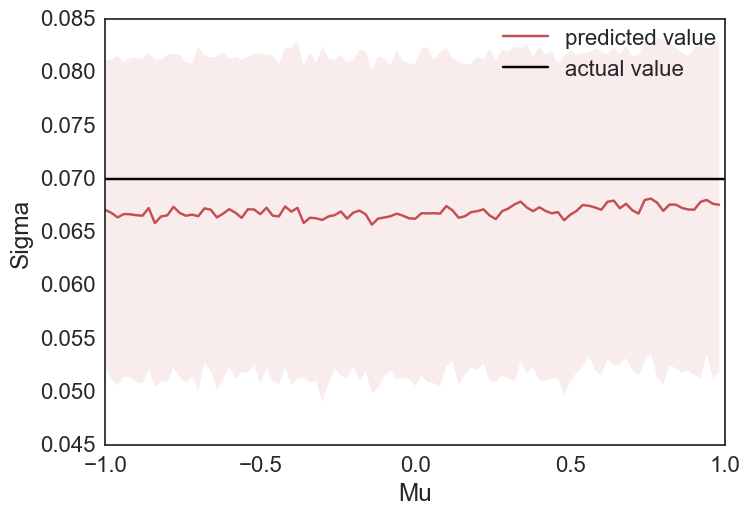

In [114]:
fig = pylab.figure()
pylab.plot(mu_s, jump_sigmas, color='r', label="predicted value");
pylab.axhline(y=0.07, color='black', linestyle='-', label="actual value")
pylab.fill_between(mu_s, jump_sigmas_lower_16, jump_sigmas_upper_84, color='r', alpha=0.1, edgecolor='none')
pylab.xlabel("Mu")
pylab.ylabel("Sigma")

pylab.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0.)
pylab.show();
fig.savefig(ROOT_DIR + "/Images/Output-Sensitivity-Results/ConvolutionalNN-MultipleOutput-ELU/Varying-Mu/"+"sigma.png")

In [115]:
jump_sigmas = np.array(preds_MEAN)[3:,0].reshape(100)
jump_sigmas_upper_84 = np.array(preds_Upper_84)[3:,0].reshape(100)
jump_sigmas_lower_16 = np.array(preds_Lower_16)[3:,0].reshape(100)

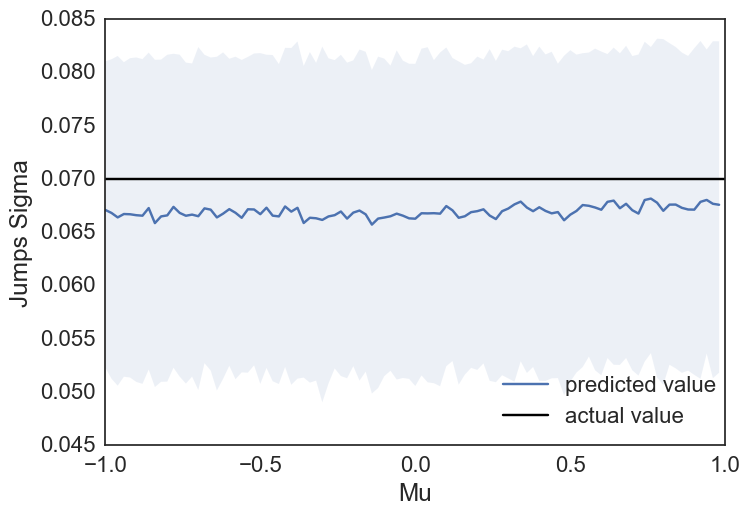

In [123]:
plt.plot(mu_s, jump_sigmas, color='b', label="predicted value");
plt.axhline(y=0.07, color='black', linestyle='-', label="actual value")
plt.fill_between(mu_s, jump_sigmas_lower_16, jump_sigmas_upper_84, color='b', alpha=0.1, edgecolor='none')
plt.xlabel("Mu")
plt.ylabel("Jumps Sigma")

plt.legend(bbox_to_anchor=(1, 0.185), loc=1, borderaxespad=0.)
plt.show();

In [124]:
jump_mus = np.array(preds_MEAN)[3:,1].reshape(100)
jump_mus_upper_84 = np.array(preds_Upper_84)[3:,1].reshape(100)
jump_mus_lower_16 = np.array(preds_Lower_16)[3:,1].reshape(100)

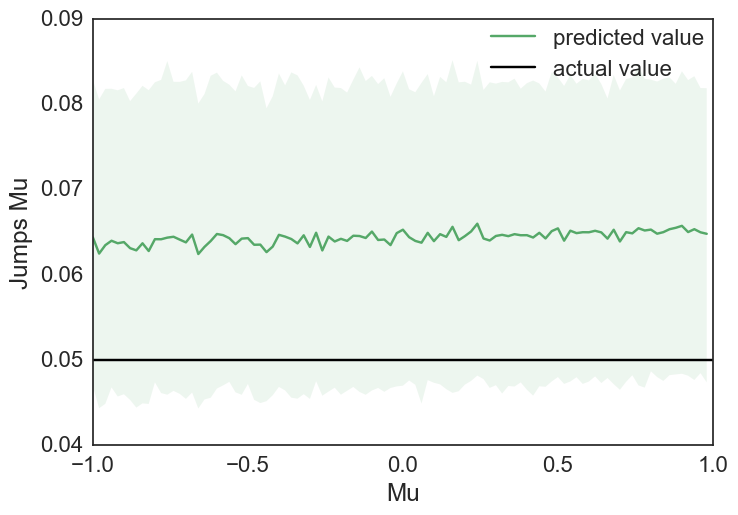

In [125]:
plt.plot(mu_s, jump_mus, color='g', label="predicted value");
plt.axhline(y=0.05, color='black', linestyle='-', label="actual value")
plt.fill_between(mu_s, jump_mus_lower_16, jump_mus_upper_84, color='g', alpha=0.1, edgecolor='none')
plt.xlabel("Mu")
plt.ylabel("Jumps Mu")

plt.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0.)
plt.show();

In [126]:
lambdas = np.array(preds_MEAN)[3:,2].reshape(100)
lambdas_upper_84 = np.array(preds_Upper_84)[3:,2].reshape(100)
lambdas_lower_16 = np.array(preds_Lower_16)[3:,2].reshape(100)

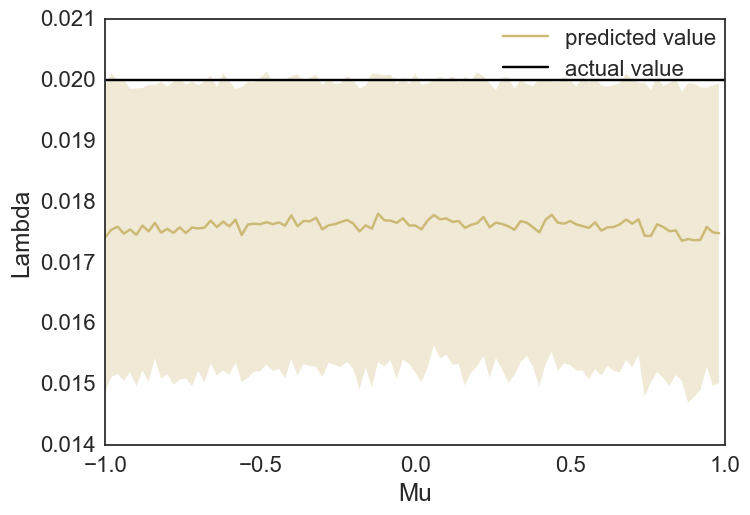

In [130]:
plt.plot(mu_s, lambdas, color='y', label="predicted value");
plt.axhline(y=0.02, color='black', linestyle='-', label="actual value")
plt.fill_between(mu_s, lambdas_lower_16, lambdas_upper_84, color='y', alpha=0.3, edgecolor='none')
plt.xlabel("Mu")
plt.ylabel("Lambda")

plt.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0.)
plt.show();

In [30]:
mus_ = np.array(preds_MEAN)[:,1].reshape(100)
mus_upper_84 = np.array(preds_Upper_84)[:,1].reshape(100)
mus_lower_16 = np.array(preds_Lower_16)[:,1].reshape(100)

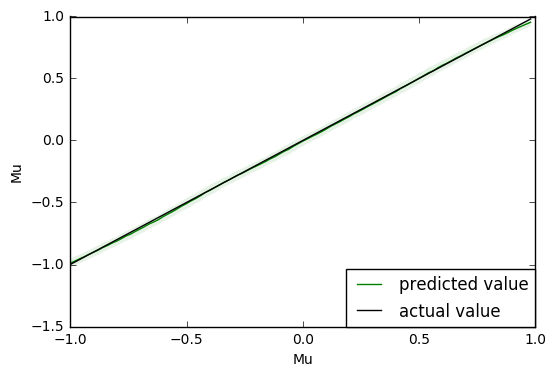

In [31]:
plt.plot(mu_s, mus_, color='g', label="predicted value");
plt.plot(mu_s, mu_s, color='black', label="actual value");
plt.fill_between(mu_s, mus_lower_16, mus_upper_84, color='g', alpha=0.1, edgecolor='none')
plt.xlabel("Mu")
plt.ylabel("Mu")

plt.legend(bbox_to_anchor=(1, 0.185), loc=1, borderaxespad=0.)
plt.show();

### Sensitivity Test: Sigma

In [131]:
sigma_s = []
preds_MEAN = []
preds_Lower_16 = []
preds_Upper_84 = []


preds_SINGLE_LAMBDA_MEAN = []
preds_SINGLE_LAMBDA_Lower_16 = []
preds_SINGLE_LAMBDA_Upper_84 = []

In [132]:
covnet_jump_mu = load_model("covnet_jump_mu_FULLMODEL.h5", custom_objects={"r2":r2})
covnet_jump_sigma = load_model("covnet_jump_sigma_FULLMODEL.h5", custom_objects={"r2":r2})
covnet_lambda = covnet_single_ReLUs_6_layers()
covnet_lambda.load_weights(H5_DIR_COVNET_LAMBDA)

In [133]:
mp = test_set_model_params()
for j in range(100):
    
    mp.all_sigma = 0.001 + j*(0.2 - 0.001)/100
    print(j)
    
    print("GENERATION...")
    test_set_pred = standard_convolutional_test_set(mp=mp)
    
    
    print("PREDICTION...\n")
    predictions_lambda = covnet_lambda.predict(test_set_pred)
    predictions_jump_mu = covnet_jump_mu.predict(test_set_pred)
    predictions_jump_sigma = covnet_jump_sigma.predict(test_set_pred)
    
    #predictions_lambda = covnet_lambda.predict(test_set_pred)
    predictions_elu = [predictions_jump_sigma, predictions_jump_mu, predictions_lambda]
    
    print(np.transpose(np.mean(predictions_elu, axis = 1)))
    print("   jump_sigma,   jump_mu,    lambda,     sigma")
    print("     0.07          0.05       0.02      "+str(mp.all_sigma))
    
    preds_MEAN.append(np.mean(predictions_elu, axis = 1))
    sigma_s.append(mp.all_sigma)
    preds_Upper_84.append(np.percentile(predictions_elu, 84, axis = 1))
    preds_Lower_16.append(np.percentile(predictions_elu, 16, axis = 1))
    
np.save("Sensitivity_Test-covnet_lambda_SIGMA_preds_Upper_84.npy", preds_Upper_84)
np.save("Sensitivity_Test-covnet_lambda_SIGMA_preds_Lower_16.npy", preds_Lower_16)
    
np.save("Sensitivity_Test-covnet_lambda_SIGMA_all_sigma.npy", all_sigma)
np.save("Sensitivity_Test-covnet_lambda_SIGMA_preds_MEAN.npy", preds_MEAN)

#np.save("Sensitivity_Test-preds_VaryingMu_SINGLE_LAMBDA_MEAN.npy", preds_SINGLE_LAMBDA_MEAN)
#np.save("Sensitivity_Test-preds_VaryingMu_preds_SINGLE_LAMBDA_Lower_16", preds_SINGLE_LAMBDA_Lower_16)
#np.save("Sensitivity_Test-preds_VaryingMu_preds_SINGLE_LAMBDA_Upper_84", preds_SINGLE_LAMBDA_Upper_84)

0
GENERATION...
0
100
200
300
400
500
600
700
800
900
PREDICTION...

[[ 0.07248122  0.06428636  0.01847146]]
   jump_sigma,   jump_mu,    lambda,     sigma
     0.07          0.05       0.02      0.001
1
GENERATION...
0
100
200
300
400
500
600
700
800
900
PREDICTION...

[[ 0.07341293  0.06416358  0.01848663]]
   jump_sigma,   jump_mu,    lambda,     sigma
     0.07          0.05       0.02      0.00299
2
GENERATION...
0
100
200
300
400
500
600
700
800
900
PREDICTION...

[[ 0.07253976  0.06382641  0.01851454]]
   jump_sigma,   jump_mu,    lambda,     sigma
     0.07          0.05       0.02      0.00498
3
GENERATION...
0
100
200
300
400
500
600
700
800
900
PREDICTION...

[[ 0.07290635  0.06522841  0.01846983]]
   jump_sigma,   jump_mu,    lambda,     sigma
     0.07          0.05       0.02      0.00697
4
GENERATION...
0
100
200
300
400
500
600
700
800
900
PREDICTION...

[[ 0.07253142  0.06448686  0.01850066]]
   jump_sigma,   jump_mu,    lambda,     sigma
     0.07          0.05       

NameError: name 'all_sigma' is not defined

In [ ]:
np.save("Sensitivity_Test-covnet_lambda_SIGMA_sigma_s.npy", sigma_s)
np.save("Sensitivity_Test-covnet_lambda_SIGMA_preds_MEAN.npy", preds_MEAN)

In [111]:
jump_sigmas = np.array(preds_MEAN)[:,0].reshape(100)
jump_sigmas_upper_84 = np.array(preds_Upper_84)[:,0].reshape(100)
jump_sigmas_lower_16 = np.array(preds_Lower_16)[:,0].reshape(100)

In [112]:
mu_s = mu_s[3:]

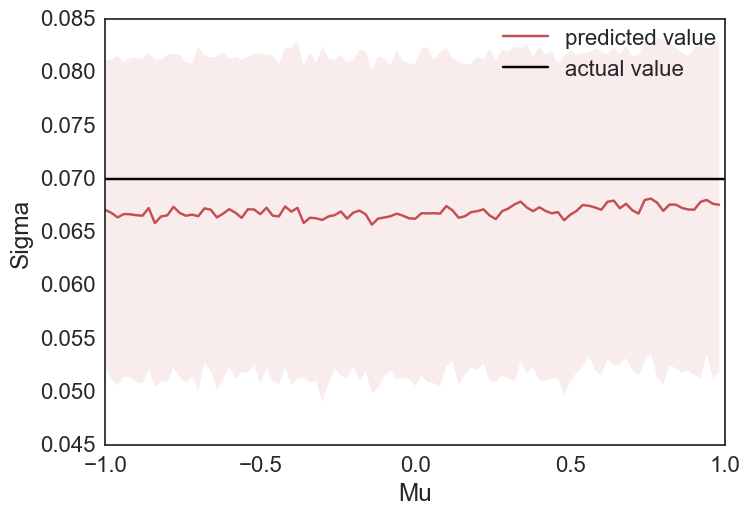

In [114]:
fig = pylab.figure()
pylab.plot(mu_s, jump_sigmas, color='r', label="predicted value");
pylab.axhline(y=0.07, color='black', linestyle='-', label="actual value")
pylab.fill_between(mu_s, jump_sigmas_lower_16, jump_sigmas_upper_84, color='r', alpha=0.1, edgecolor='none')
pylab.xlabel("Mu")
pylab.ylabel("Sigma")

pylab.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0.)
pylab.show();
fig.savefig(ROOT_DIR + "/Images/Output-Sensitivity-Results/ConvolutionalNN-MultipleOutput-ELU/Varying-Mu/"+"sigma.png")

In [115]:
jump_sigmas = np.array(preds_MEAN)[3:,0].reshape(100)
jump_sigmas_upper_84 = np.array(preds_Upper_84)[3:,0].reshape(100)
jump_sigmas_lower_16 = np.array(preds_Lower_16)[3:,0].reshape(100)

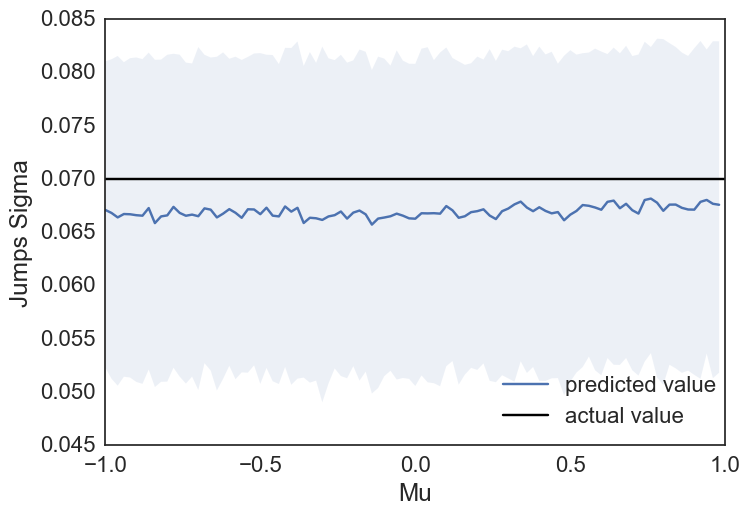

In [123]:
plt.plot(mu_s, jump_sigmas, color='b', label="predicted value");
plt.axhline(y=0.07, color='black', linestyle='-', label="actual value")
plt.fill_between(mu_s, jump_sigmas_lower_16, jump_sigmas_upper_84, color='b', alpha=0.1, edgecolor='none')
plt.xlabel("Mu")
plt.ylabel("Jumps Sigma")

plt.legend(bbox_to_anchor=(1, 0.185), loc=1, borderaxespad=0.)
plt.show();

In [124]:
jump_mus = np.array(preds_MEAN)[3:,1].reshape(100)
jump_mus_upper_84 = np.array(preds_Upper_84)[3:,1].reshape(100)
jump_mus_lower_16 = np.array(preds_Lower_16)[3:,1].reshape(100)

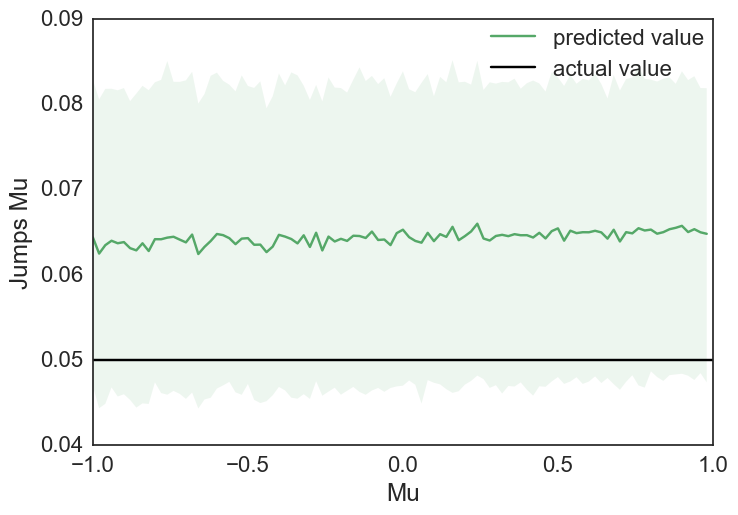

In [125]:
plt.plot(mu_s, jump_mus, color='g', label="predicted value");
plt.axhline(y=0.05, color='black', linestyle='-', label="actual value")
plt.fill_between(mu_s, jump_mus_lower_16, jump_mus_upper_84, color='g', alpha=0.1, edgecolor='none')
plt.xlabel("Mu")
plt.ylabel("Jumps Mu")

plt.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0.)
plt.show();

In [126]:
lambdas = np.array(preds_MEAN)[3:,2].reshape(100)
lambdas_upper_84 = np.array(preds_Upper_84)[3:,2].reshape(100)
lambdas_lower_16 = np.array(preds_Lower_16)[3:,2].reshape(100)

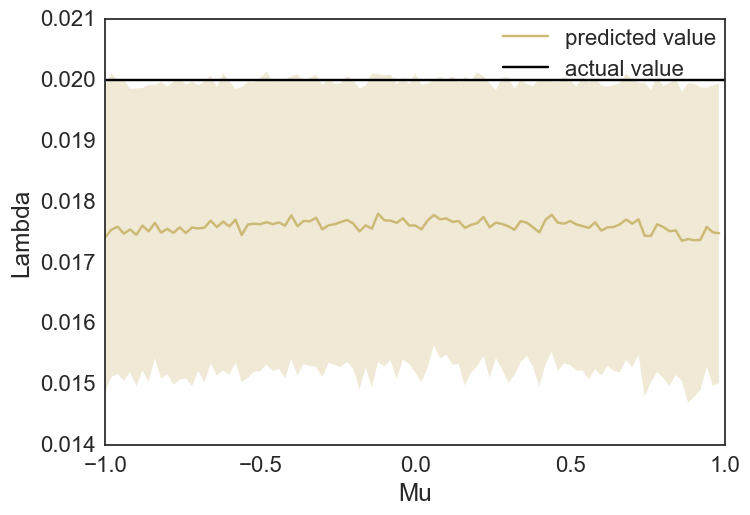

In [130]:
plt.plot(mu_s, lambdas, color='y', label="predicted value");
plt.axhline(y=0.02, color='black', linestyle='-', label="actual value")
plt.fill_between(mu_s, lambdas_lower_16, lambdas_upper_84, color='y', alpha=0.3, edgecolor='none')
plt.xlabel("Mu")
plt.ylabel("Lambda")

plt.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0.)
plt.show();

In [30]:
mus_ = np.array(preds_MEAN)[:,1].reshape(100)
mus_upper_84 = np.array(preds_Upper_84)[:,1].reshape(100)
mus_lower_16 = np.array(preds_Lower_16)[:,1].reshape(100)

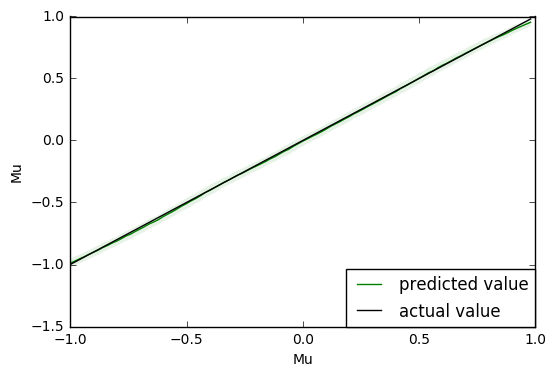

In [31]:
plt.plot(mu_s, mus_, color='g', label="predicted value");
plt.plot(mu_s, mu_s, color='black', label="actual value");
plt.fill_between(mu_s, mus_lower_16, mus_upper_84, color='g', alpha=0.1, edgecolor='none')
plt.xlabel("Mu")
plt.ylabel("Mu")

plt.legend(bbox_to_anchor=(1, 0.185), loc=1, borderaxespad=0.)
plt.show();

# Sensitivity Test - Sigma

In [ ]:
sigma_s = []
preds_MEAN = []
preds_Lower_16 = []
preds_Upper_84 = []

for j in range(100):
    covnet_lambda = covnet_multiple_output_with_ELUs()
    covnet_lambda.load_weights(H5_DIR_COVNET_MULTIPLE_ELU)
    
    mp.all_sigma = 0.001 + j*(0.2 - 0.001)/100
    test_set = []
    
    print(j)
    
    print("GENERATION...")
    test_set_pred = standard_convolutional_test_set()
    
    print("PREDICTION...\n")
    predictions_elu = covnet_lambda.predict(test_set_pred)
    
    print(np.transpose(np.mean(predictions_elu, axis = 1)))
    print("   sigma,    mu,      jump_sigma,      jump_mu,    lambda")
    print("   "+str(mp.all_sigma)+"      0.05       0.07              0.05       0.02")
    print(np.mean(predictions_elu, axis = 1)+np.std(predictions_elu, axis = 1))
    print(np.percentile(predictions_elu, 84, axis = 1))
    preds_MEAN.append(np.mean(predictions_elu, axis = 1))
    preds_Upper_84.append(np.percentile(predictions_elu, 84, axis = 1))
    preds_Lower_16.append(np.percentile(predictions_elu, 16, axis = 1))
    sigma_s.append(mp.all_sigma)
    
np.save("Sensitivity_Test-covnet_lambda_Sigma_sigma_s.npy", sigma_s)
np.save("Sensitivity_Test-covnet_lambda_Sigma_preds_MEAN.npy", preds_MEAN)
np.save("Sensitivity_Test-covnet_lambda_Sigma_preds_Upper_84.npy", preds_Upper_84)
np.save("Sensitivity_Test-covnet_lambda_Sigma_preds_Lower_16.npy", preds_Lower_16)

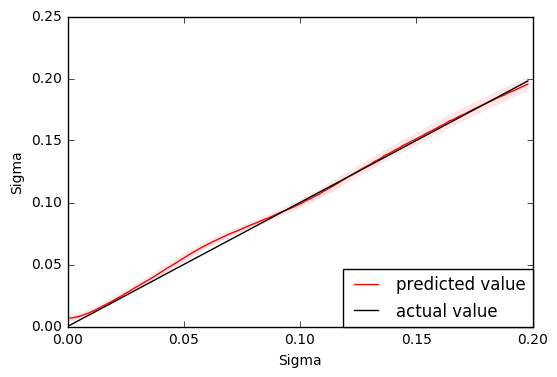

In [33]:
sigmas = np.array(preds_MEAN)[:,0].reshape(100)
sigma_upper_84 = np.array(preds_Upper_84)[:,0].reshape(100)
sigma_lower_16 = np.array(preds_Lower_16)[:,0].reshape(100)

plt.plot(sigma_s, sigmas, color='r', label="predicted value");
plt.plot(sigma_s, sigma_s, color='black', label="actual value");
plt.fill_between(sigma_s, sigma_lower_16, sigma_upper_84, color='r', alpha=0.1, edgecolor='none')
plt.xlabel("Sigma")
plt.ylabel("Sigma")

plt.legend(bbox_to_anchor=(1, 0.185), loc=0, borderaxespad=0.)
plt.show();

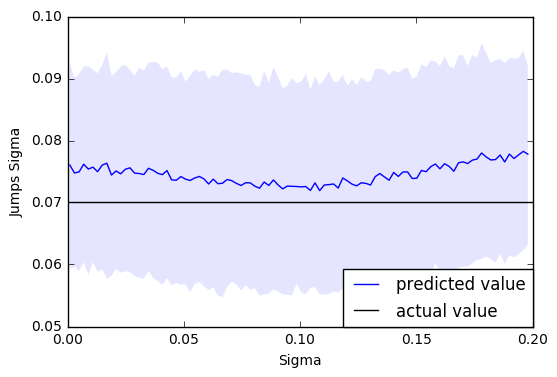

In [34]:
jump_sigmas = np.array(preds_MEAN)[:,2].reshape(100)
jump_sigmas_upper_84 = np.array(preds_Upper_84)[:,2].reshape(100)
jump_sigmas_lower_16 = np.array(preds_Lower_16)[:,2].reshape(100)

plt.plot(sigma_s, jump_sigmas, color='b', label="predicted value");
plt.axhline(y=0.07, color='black', linestyle='-', label="actual value")
plt.fill_between(sigma_s, jump_sigmas_lower_16, jump_sigmas_upper_84, color='b', alpha=0.1, edgecolor='none')
plt.xlabel("Sigma")
plt.ylabel("Jumps Sigma")

plt.legend(bbox_to_anchor=(1, 0.185), loc=1, borderaxespad=0.)
plt.show();

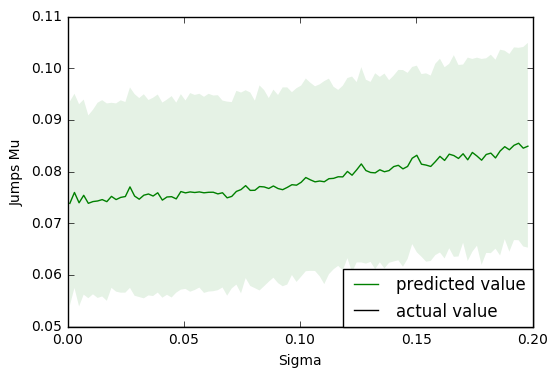

In [35]:
jump_mus = np.array(preds_MEAN)[:,3].reshape(100)
jump_mus_upper_84 = np.array(preds_Upper_84)[:,3].reshape(100)
jump_mus_lower_16 = np.array(preds_Lower_16)[:,3].reshape(100)

plt.plot(sigma_s, jump_mus, color='g', label="predicted value");
plt.axhline(y=0.05, color='black', linestyle='-', label="actual value")
plt.fill_between(sigma_s, jump_mus_lower_16, jump_mus_upper_84, color='g', alpha=0.1, edgecolor='none')
plt.xlabel("Sigma")
plt.ylabel("Jumps Mu")

plt.legend(bbox_to_anchor=(1, 0.185), loc=1, borderaxespad=0.)
plt.show();

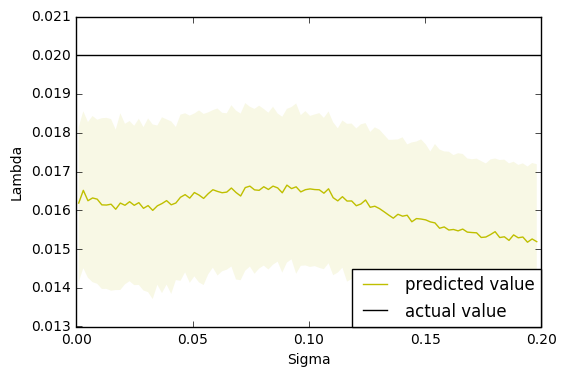

In [37]:
lambdas = np.array(preds_MEAN)[:,4].reshape(100)
lambdas_upper_84 = np.array(preds_Upper_84)[:,4].reshape(100)
lambdas_lower_16 = np.array(preds_Lower_16)[:,4].reshape(100)

plt.plot(sigma_s, lambdas, color='y', label="predicted value");
plt.axhline(y=0.02, color='black', linestyle='-', label="actual value")
plt.fill_between(sigma_s, lambdas_lower_16, lambdas_upper_84, color='y', alpha=0.1, edgecolor='none')
plt.xlabel("Sigma")
plt.ylabel("Lambda")

plt.legend(bbox_to_anchor=(1, 0.185), loc=1, borderaxespad=0.)
plt.show();

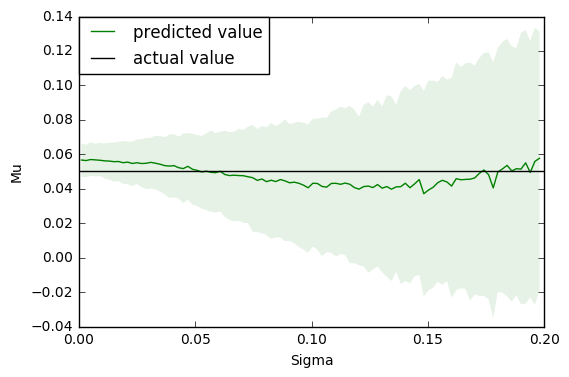

In [38]:
mus_ = np.array(preds_MEAN)[:,1].reshape(100)
mus_upper_84 = np.array(preds_Upper_84)[:,1].reshape(100)
mus_lower_16 = np.array(preds_Lower_16)[:,1].reshape(100)

plt.plot(sigma_s, mus_, color='g', label="predicted value");
plt.axhline(y=0.05, color='black', linestyle='-', label="actual value")
plt.fill_between(sigma_s, mus_lower_16, mus_upper_84, color='g', alpha=0.1, edgecolor='none')
plt.xlabel("Sigma")
plt.ylabel("Mu")

plt.legend(bbox_to_anchor=(0.4085, 1), loc=1, borderaxespad=0.)
plt.show();

# Sensitivity Test - Jumps Sigma

In [ ]:
jump_sigma_s = []
preds_MEAN = []
preds_Lower_16 = []
preds_Upper_84 = []

mp = test_set_model_params()
for j in range(100):
    
    mp.jumps_sigma = 0.001 + j*(0.2 - 0.001)/100
    print(j)
    
    print("GENERATION...")
    test_set_pred = standard_convolutional_test_set(mp=mp)
    
    
    print("PREDICTION...\n")
    predictions_lambda = covnet_lambda.predict(test_set_pred)
    predictions_jump_mu = covnet_jump_mu.predict(test_set_pred)
    predictions_jump_sigma = covnet_jump_sigma.predict(test_set_pred)
    
    #predictions_lambda = covnet_lambda.predict(test_set_pred)
    predictions_elu = [predictions_jump_sigma, predictions_jump_mu, predictions_lambda]
    
    print(np.transpose(np.mean(predictions_elu, axis = 1)))
    print("   jump_sigma,   jump_mu,    lambda")
    print("     "+str(mp.jumps_sigma)"          0.05       0.02")
    
    preds_MEAN.append(np.mean(predictions_elu, axis = 1))
    jump_sigma_s.append(mp.jumps_sigma)
    preds_Upper_84.append(np.percentile(predictions_elu, 84, axis = 1))
    preds_Lower_16.append(np.percentile(predictions_elu, 16, axis = 1))
    
np.save("Sensitivity_Test-covnet_lambda_JUMPSIGMA_preds_Upper_84.npy", preds_Upper_84)
np.save("Sensitivity_Test-covnet_lambda_JUMPSIGMA_preds_Lower_16.npy", preds_Lower_16)
    
np.save("Sensitivity_Test-covnet_lambda_JUMPSIGMA_jump_sigma_s.npy", jump_sigma_s)
np.save("Sensitivity_Test-covnet_lambda_JUMPSIGMA_preds_MEAN.npy", preds_MEAN)

#np.save("Sensitivity_Test-preds_VaryingMu_SINGLE_LAMBDA_MEAN.npy", preds_SINGLE_LAMBDA_MEAN)
#np.save("Sensitivity_Test-preds_VaryingMu_preds_SINGLE_LAMBDA_Lower_16", preds_SINGLE_LAMBDA_Lower_16)
#np.save("Sensitivity_Test-preds_VaryingMu_preds_SINGLE_LAMBDA_Upper_84", preds_SINGLE_LAMBDA_Upper_84)

In [ ]:


for j in range(100):
    covnet_lambda = covnet_multiple_output_with_ELUs()
    covnet_lambda.load_weights(H5_DIR_COVNET_MULTIPLE_ELU)
    
    mp.jumps_sigma = 0.001 + j*(0.2 - 0.001)/100
    test_set = []
    
    print(j)
    
    print("GENERATION...")
    test_set_pred = standard_convolutional_test_set()
    
    
    print("PREDICTION...\n")
    predictions_elu = covnet_lambda.predict(test_set_pred)
    
    print(np.transpose(np.mean(predictions_elu, axis = 1)))
    print("   sigma,    mu,      jump_sigma,      jump_mu,    lambda")
    print("   0.1      0.05       "+str(mp.jumps_sigma)+"              0.05       0.02")
    preds_MEAN.append(np.mean(predictions_elu, axis = 1))
    jump_sigma_s.append(mp.jumps_sigma)
    preds_Upper_84.append(np.percentile(predictions_elu, 84, axis = 1))
    preds_Lower_16.append(np.percentile(predictions_elu, 16, axis = 1))
    
np.save("Sensitivity_Test-covnet_lambda_JumpSigma_preds_Upper_84.npy", preds_Upper_84)
np.save("Sensitivity_Test-covnet_lambda_JumpSigma_preds_Lower_16.npy", preds_Lower_16)
np.save("Sensitivity_Test-covnet_lambda_JumpSigma_jump_sigma_s.npy", jump_sigma_s)
np.save("Sensitivity_Test-covnet_lambda_JumpSigma_preds_MEAN.npy", preds_MEAN)

KeyboardInterrupt: 

In [39]:
preds_Upper_84 = np.load("Sensitivity_Test-covnet_lambda_JumpSigma_preds_Upper_84.npy")
preds_Lower_16 = np.load("Sensitivity_Test-covnet_lambda_JumpSigma_preds_Lower_16.npy")
jump_sigma_s = np.load("Sensitivity_Test-covnet_lambda_JumpSigma_jump_sigma_s.npy")
preds_MEAN = np.load("Sensitivity_Test-covnet_lambda_JumpSigma_preds_MEAN.npy")

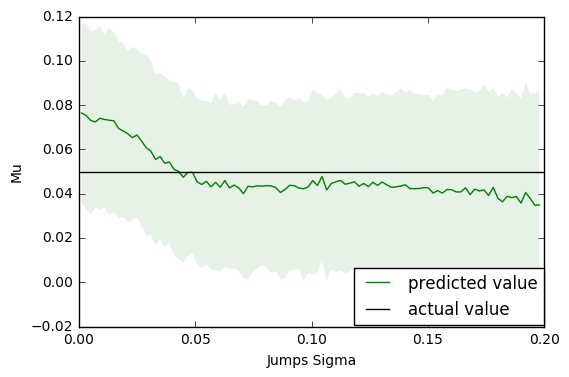

In [40]:
mus_ = np.array(preds_MEAN)[:,1].reshape(100)
mus_upper_84 = np.array(preds_Upper_84)[:,1].reshape(100)
mus_lower_16 = np.array(preds_Lower_16)[:,1].reshape(100)

plt.plot(jump_sigma_s, mus_, color='g', label="predicted value");
plt.axhline(y=0.05, color='black', linestyle='-', label="actual value")
plt.fill_between(jump_sigma_s, mus_lower_16, mus_upper_84, color='g', alpha=0.1, edgecolor='none')
plt.xlabel("Jumps Sigma")
plt.ylabel("Mu")

plt.legend(bbox_to_anchor=(1, 0.19), loc=1, borderaxespad=0.)
plt.show();

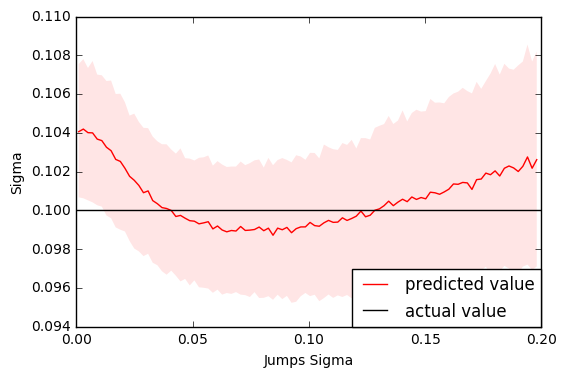

In [41]:
sigmas = np.array(preds_MEAN)[:,0].reshape(100)
sigmas_upper_84 = np.array(preds_Upper_84)[:,0].reshape(100)
sigmas_lower_16 = np.array(preds_Lower_16)[:,0].reshape(100)

plt.plot(jump_sigma_s, sigmas, color='r', label="predicted value");
plt.axhline(y=0.1, color='black', linestyle='-', label="actual value")
plt.fill_between(jump_sigma_s, sigmas_lower_16, sigmas_upper_84, color='r', alpha=0.1, edgecolor='none')
plt.xlabel("Jumps Sigma")
plt.ylabel("Sigma")

plt.legend(bbox_to_anchor=(1, 0.185), loc=0, borderaxespad=0.)
plt.show();

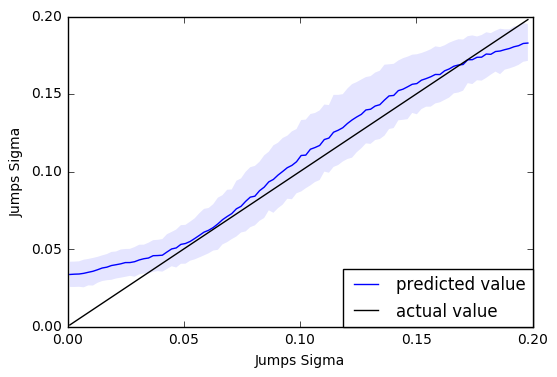

In [42]:
jump_sigmas = np.array(preds_MEAN)[:,2].reshape(100)
jump_sigmas_upper_84 = np.array(preds_Upper_84)[:,2].reshape(100)
jump_sigmas_lower_16 = np.array(preds_Lower_16)[:,2].reshape(100)

plt.plot(jump_sigma_s, jump_sigmas, color='b', label="predicted value");
plt.plot(jump_sigma_s, jump_sigma_s, color='black', label="actual value");
plt.fill_between(jump_sigma_s, jump_sigmas_lower_16, jump_sigmas_upper_84, color='b', alpha=0.1, edgecolor='none')
plt.xlabel("Jumps Sigma")
plt.ylabel("Jumps Sigma")

plt.legend(bbox_to_anchor=(1, 0.185), loc=1, borderaxespad=0.)
plt.show();

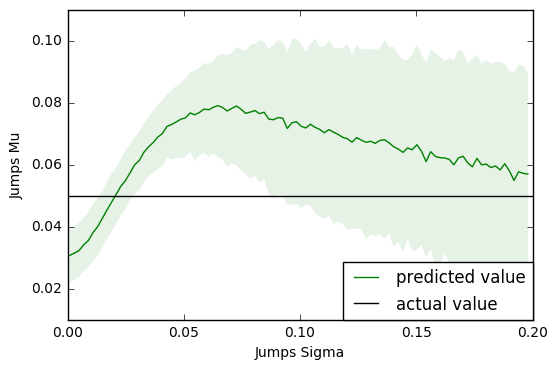

In [43]:
jump_mus = np.array(preds_MEAN)[:,3].reshape(100)
jump_mus_upper_84 = np.array(preds_Upper_84)[:,3].reshape(100)
jump_mus_lower_16 = np.array(preds_Lower_16)[:,3].reshape(100)

plt.plot(jump_sigma_s, jump_mus, color='g', label="predicted value");
plt.axhline(y=0.05, color='black', linestyle='-', label="actual value")
plt.fill_between(jump_sigma_s, jump_mus_lower_16, jump_mus_upper_84, color='g', alpha=0.1, edgecolor='none')
plt.xlabel("Jumps Sigma")
plt.ylabel("Jumps Mu")

plt.legend(bbox_to_anchor=(1, 0.185), loc=1, borderaxespad=0.)
plt.show();

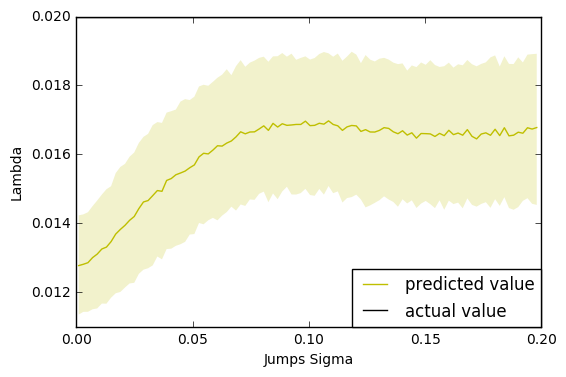

In [44]:
lambdas = np.array(preds_MEAN)[:,4].reshape(100)
lambdas_upper_84 = np.array(preds_Upper_84)[:,4].reshape(100)
lambdas_lower_16 = np.array(preds_Lower_16)[:,4].reshape(100)

plt.plot(jump_sigma_s, lambdas, color='y', label="predicted value");
plt.axhline(y=0.02, color='black', linestyle='-', label="actual value")
plt.fill_between(jump_sigma_s, lambdas_lower_16, lambdas_upper_84, color='y', alpha=0.2, edgecolor='none')
plt.xlabel("Jumps Sigma")
plt.ylabel("Lambda")

plt.legend(bbox_to_anchor=(1, 0.185), loc=1, borderaxespad=0.)
plt.show();

# Sensitivity Test - Jumps Mu

In [ ]:
jump_mu_s = []
preds_MEAN = []
preds_Lower_16 = []
preds_Upper_84 = []

mp = test_set_model_params()
for j in range(100):
    
    mp.jumps_mu = -0.5 + j/100
    print(j)
    
    print("GENERATION...")
    test_set_pred = standard_convolutional_test_set(mp=mp)
    
    
    print("PREDICTION...\n")
    predictions_lambda = covnet_lambda.predict(test_set_pred)
    predictions_jump_mu = covnet_jump_mu.predict(test_set_pred)
    predictions_jump_sigma = covnet_jump_sigma.predict(test_set_pred)
    
    #predictions_lambda = covnet_lambda.predict(test_set_pred)
    predictions_elu = [predictions_jump_sigma, predictions_jump_mu, predictions_lambda]
    
    print(np.transpose(np.mean(predictions_elu, axis = 1)))
    print("   jump_sigma,   jump_mu,    lambda")
    print("     0.07          "+str(mp.jumps_mu)"       0.02")
    
    preds_MEAN.append(np.mean(predictions_elu, axis = 1))
    jump_mu_s.append(mp.jumps_mu)
    preds_Upper_84.append(np.percentile(predictions_elu, 84, axis = 1))
    preds_Lower_16.append(np.percentile(predictions_elu, 16, axis = 1))
    
np.save("Sensitivity_Test-covnet_lambda_JUMPMU_preds_Upper_84.npy", preds_Upper_84)
np.save("Sensitivity_Test-covnet_lambda_JUMPMU_preds_Lower_16.npy", preds_Lower_16)
    
np.save("Sensitivity_Test-covnet_lambda_JUMPMU_jump_mu_s.npy", jump_mu_s)
np.save("Sensitivity_Test-covnet_lambda_JUMPMU_preds_MEAN.npy", preds_MEAN)

#np.save("Sensitivity_Test-preds_VaryingMu_SINGLE_LAMBDA_MEAN.npy", preds_SINGLE_LAMBDA_MEAN)
#np.save("Sensitivity_Test-preds_VaryingMu_preds_SINGLE_LAMBDA_Lower_16", preds_SINGLE_LAMBDA_Lower_16)
#np.save("Sensitivity_Test-preds_VaryingMu_preds_SINGLE_LAMBDA_Upper_84", preds_SINGLE_LAMBDA_Upper_84)

In [115]:
jump_mu_s = []
preds_MEAN = []
preds_Upper_84 = []
preds_Lower_16 = []

for j in range(100):
    covnet_lambda = covnet_multiple_output_with_ELUs()
    covnet_lambda.load_weights(H5_DIR_COVNET_MULTIPLE_ELU)
    
    mp.jumps_mu = -0.5 + j/100
    test_set = []
    
    print(j)
    
    print("GENERATION...")
    test_set_pred = standard_convolutional_test_set()
    
    
    print("PREDICTION...\n")
    predictions_elu = covnet_lambda.predict(test_set_pred)
    
    print(np.transpose(np.mean(predictions_elu, axis = 1)))
    print("   sigma,    mu,      jump_sigma,      jump_mu,    lambda")
    print("   0.1      0.05       0.07              "+str(mp.jumps_mu)+"       0.02")
    preds_MEAN.append(np.mean(predictions_elu, axis = 1))
    jump_mu_s.append(mp.jumps_mu)
    preds_Upper_84.append(np.percentile(predictions_elu, 84, axis = 1))
    preds_Lower_16.append(np.percentile(predictions_elu, 16, axis = 1))
    
np.save("Sensitivity_Test-covnet_lambda_JumpMu_preds_Upper_84.npy", preds_Upper_84)
np.save("Sensitivity_Test-covnet_lambda_JumpMu_preds_Lower_16.npy", preds_Lower_16)
    
np.save("Sensitivity_Test-covnet_lambda_JumpMu_jump_mu_s.npy", jump_mu_s)
np.save("Sensitivity_Test-covnet_lambda_JumpMu_preds_MEAN.npy", preds_MEAN)

0
GENERATION...
PREDICTION...

[[ 0.09358801  0.02716708  0.10604782 -0.48250023  0.01862055]]
   sigma,    mu,      jump_sigma,      jump_mu,    lambda
   0.1      0.05       0.07              -0.5       0.02
1
GENERATION...
PREDICTION...

[[ 0.09472806  0.02322231  0.10443371 -0.47442847  0.01849458]]
   sigma,    mu,      jump_sigma,      jump_mu,    lambda
   0.1      0.05       0.07              -0.49       0.02
2
GENERATION...
PREDICTION...

[[ 0.09470364  0.02547242  0.10327458 -0.46566382  0.0184239 ]]
   sigma,    mu,      jump_sigma,      jump_mu,    lambda
   0.1      0.05       0.07              -0.48       0.02
3
GENERATION...
PREDICTION...

[[ 0.09509647  0.02195476  0.09701471 -0.45873681  0.01851395]]
   sigma,    mu,      jump_sigma,      jump_mu,    lambda
   0.1      0.05       0.07              -0.47       0.02
4
GENERATION...
PREDICTION...

[[ 0.09548972  0.02388027  0.09710168 -0.4484601   0.01838682]]
   sigma,    mu,      jump_sigma,      jump_mu,    lambda
   0

KeyboardInterrupt: 

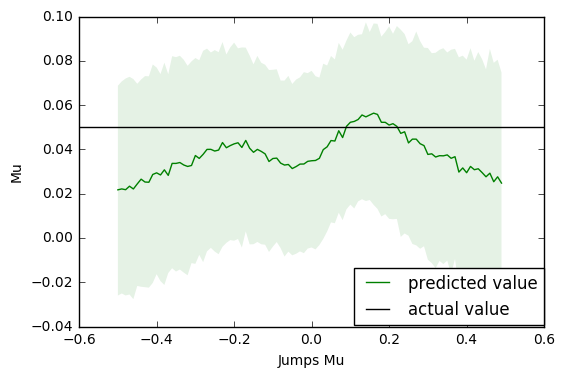

In [46]:
mus_ = np.array(preds_MEAN)[:,1].reshape(100)
mus_upper_84 = np.array(preds_Upper_84)[:,1].reshape(100)
mus_lower_16 = np.array(preds_Lower_16)[:,1].reshape(100)

plt.plot(jump_mu_s, mus_, color='g', label="predicted value");
plt.axhline(y=0.05, color='black', linestyle='-', label="actual value")
plt.fill_between(jump_mu_s, mus_lower_16, mus_upper_84, color='g', alpha=0.1, edgecolor='none')
plt.xlabel("Jumps Mu")
plt.ylabel("Mu")

plt.legend(bbox_to_anchor=(1, 0.19), loc=1, borderaxespad=0.)
plt.show();

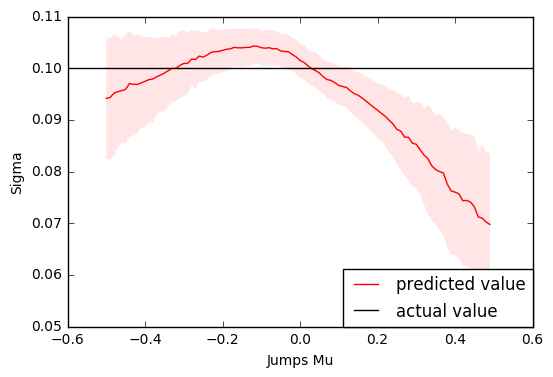

In [47]:
sigmas = np.array(preds_MEAN)[:,0].reshape(100)
sigmas_upper_84 = np.array(preds_Upper_84)[:,0].reshape(100)
sigmas_lower_16 = np.array(preds_Lower_16)[:,0].reshape(100)

plt.plot(jump_mu_s, sigmas, color='r', label="predicted value");
plt.axhline(y=0.1, color='black', linestyle='-', label="actual value")
plt.fill_between(jump_mu_s, sigmas_lower_16, sigmas_upper_84, color='r', alpha=0.1, edgecolor='none')
plt.xlabel("Jumps Mu")
plt.ylabel("Sigma")

plt.legend(bbox_to_anchor=(1, 0.185), loc=0, borderaxespad=0.)
plt.show();

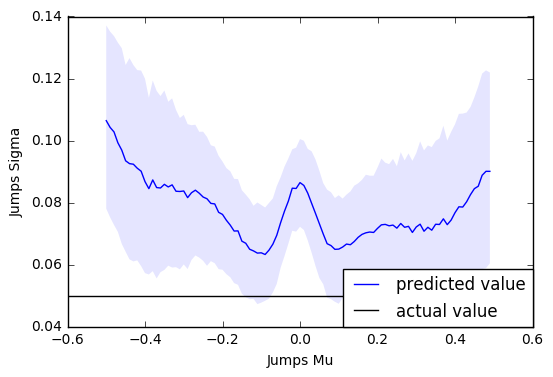

In [48]:
jump_sigmas = np.array(preds_MEAN)[:,2].reshape(100)
jump_sigmas_upper_84 = np.array(preds_Upper_84)[:,2].reshape(100)
jump_sigmas_lower_16 = np.array(preds_Lower_16)[:,2].reshape(100)

plt.plot(jump_mu_s, jump_sigmas, color='b', label="predicted value");
plt.axhline(y=0.05, color='black', linestyle='-', label="actual value")
plt.fill_between(jump_mu_s, jump_sigmas_lower_16, jump_sigmas_upper_84, color='b', alpha=0.1, edgecolor='none')
plt.xlabel("Jumps Mu")
plt.ylabel("Jumps Sigma")

plt.legend(bbox_to_anchor=(1, 0.185), loc=1, borderaxespad=0.)
plt.show();

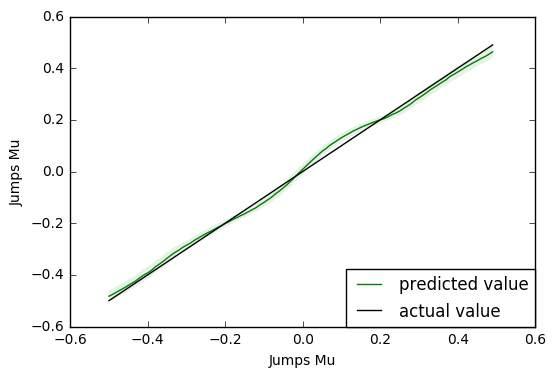

In [49]:
jump_mus = np.array(preds_MEAN)[:,3].reshape(100)
jump_mus_upper_84 = np.array(preds_Upper_84)[:,3].reshape(100)
jump_mus_lower_16 = np.array(preds_Lower_16)[:,3].reshape(100)

plt.plot(jump_mu_s, jump_mus, color='g', label="predicted value");
plt.plot(jump_mu_s, jump_mu_s, color='black', label="actual value");
plt.fill_between(jump_mu_s, jump_mus_lower_16, jump_mus_upper_84, color='g', alpha=0.1, edgecolor='none')
plt.xlabel("Jumps Mu")
plt.ylabel("Jumps Mu")

plt.legend(bbox_to_anchor=(1, 0.185), loc=1, borderaxespad=0.)
plt.show();

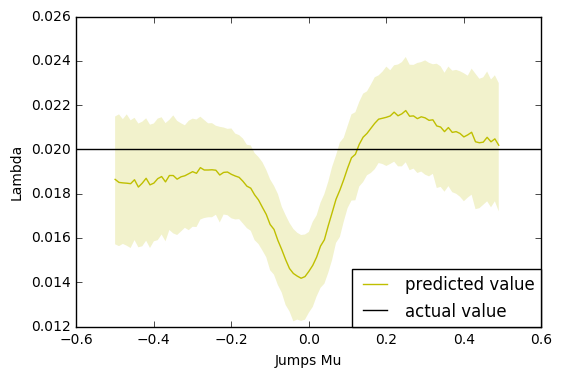

In [51]:
lambdas = np.array(preds_MEAN)[:,4].reshape(100)
lambdas_upper_84 = np.array(preds_Upper_84)[:,4].reshape(100)
lambdas_lower_16 = np.array(preds_Lower_16)[:,4].reshape(100)

plt.plot(jump_mu_s, lambdas, color='y', label="predicted value");
plt.axhline(y=0.02, color='black', linestyle='-', label="actual value")
plt.fill_between(jump_mu_s, lambdas_lower_16, lambdas_upper_84, color='y', alpha=0.2, edgecolor='none')
plt.xlabel("Jumps Mu")
plt.ylabel("Lambda")

plt.legend(bbox_to_anchor=(1, 0.185), loc=1, borderaxespad=0.)
plt.show();

# Sensitivity Test - Lambda

In [ ]:
jump_lambda_s = []
preds_MEAN = []
preds_Lower_16 = []
preds_Upper_84 = []

mp = test_set_model_params()
for j in range(100):
    
    mp.lamda = 0.0001 + j*(0.025 - 0.0001)/100
    print(j)
    
    print("GENERATION...")
    test_set_pred = standard_convolutional_test_set(mp=mp)
    
    
    print("PREDICTION...\n")
    predictions_lambda = covnet_lambda.predict(test_set_pred)
    predictions_jump_mu = covnet_jump_mu.predict(test_set_pred)
    predictions_jump_sigma = covnet_jump_sigma.predict(test_set_pred)
    
    #predictions_lambda = covnet_lambda.predict(test_set_pred)
    predictions_elu = [predictions_jump_sigma, predictions_jump_mu, predictions_lambda]
    
    print(np.transpose(np.mean(predictions_elu, axis = 1)))
    print("   jump_sigma,   jump_mu,    lambda")
    print("     0.07          0.05       "+str(mp.lamda))
    
    preds_MEAN.append(np.mean(predictions_elu, axis = 1))
    jump_lambda_s.append(mp.lamda)
    preds_Upper_84.append(np.percentile(predictions_elu, 84, axis = 1))
    preds_Lower_16.append(np.percentile(predictions_elu, 16, axis = 1))
    
np.save("Sensitivity_Test-covnet_lambda_LAMBDA_preds_Upper_84.npy", preds_Upper_84)
np.save("Sensitivity_Test-covnet_lambda_LAMBDA_preds_Lower_16.npy", preds_Lower_16)
    
np.save("Sensitivity_Test-covnet_lambda_LAMBDA_jump_lambda_s.npy", jump_lambda_s)
np.save("Sensitivity_Test-covnet_lambda_LAMBDA_preds_MEAN.npy", preds_MEAN)

#np.save("Sensitivity_Test-preds_VaryingMu_SINGLE_LAMBDA_MEAN.npy", preds_SINGLE_LAMBDA_MEAN)
#np.save("Sensitivity_Test-preds_VaryingMu_preds_SINGLE_LAMBDA_Lower_16", preds_SINGLE_LAMBDA_Lower_16)
#np.save("Sensitivity_Test-preds_VaryingMu_preds_SINGLE_LAMBDA_Upper_84", preds_SINGLE_LAMBDA_Upper_84)

In [116]:
jump_lambda_s = []
preds_MEAN = []
preds_Upper_84 = []
preds_Lower_16 = []

for j in range(100):
    covnet_lambda = covnet_multiple_output_with_ELUs()
    covnet_lambda.load_weights(H5_DIR_COVNET_MULTIPLE_ELU)
    
    mp.lamda = 0.0001 + j*(0.025 - 0.0001)/100
    test_set = []
    
    print(j)
    
    print("GENERATION...")
    test_set_pred = standard_convolutional_test_set()
    
    
    print("PREDICTION...\n")
    predictions_elu = covnet_lambda.predict(test_set_pred)
    
    print(np.transpose(np.mean(predictions_elu, axis = 1)))
    print("   sigma,    mu,      jump_sigma,      jump_mu,    lambda")
    print("   0.1      0.05       0.07              0.05       "+str(mp.lamda))
    preds_MEAN.append(np.mean(predictions_elu, axis = 1))
    jump_lambda_s.append(mp.lamda)
    preds_Upper_84.append(np.percentile(predictions_elu, 84, axis = 1))
    preds_Lower_16.append(np.percentile(predictions_elu, 16, axis = 1))
    
np.save("Sensitivity_Test-covnet_lambda_Lambda_preds_Upper_84.npy", preds_Upper_84)
np.save("Sensitivity_Test-covnet_lambda_Lambda_preds_Lower_16.npy", preds_Lower_16)
    
np.save("Sensitivity_Test-covnet_lambda_Lambda_jump_lambda_s.npy", jump_lambda_s)
np.save("Sensitivity_Test-covnet_lambda_Lambda_preds_MEAN.npy", preds_MEAN)

KeyboardInterrupt: 

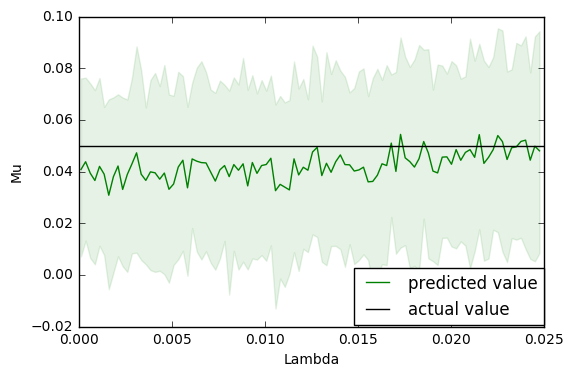

In [17]:
mus_ = np.array(preds_MEAN)[:,1].reshape(100)
mus_upper_84 = np.array(preds_Upper_84)[:,1].reshape(100)
mus_lower_16 = np.array(preds_Lower_16)[:,1].reshape(100)

plt.plot(jump_lambda_s, mus_, color='g', label="predicted value");
plt.axhline(y=0.05, color='black', linestyle='-', label="actual value")
plt.fill_between(jump_lambda_s, mus_lower_16, mus_upper_84, color='g', alpha=0.1, edgecolor='none')
plt.xlabel("Lambda")
plt.ylabel("Mu")

plt.legend(bbox_to_anchor=(1, 0.19), loc=1, borderaxespad=0.)
plt.show();

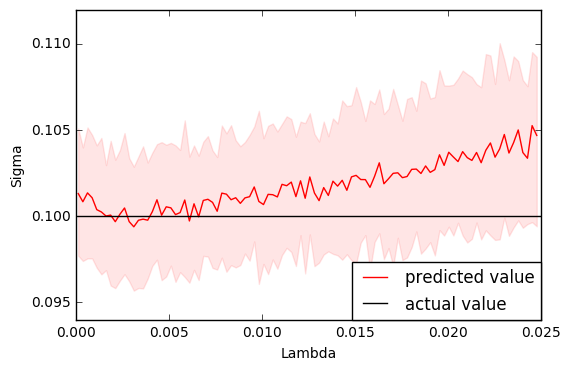

In [18]:
sigmas = np.array(preds_MEAN)[:,0].reshape(100)
sigmas_upper_84 = np.array(preds_Upper_84)[:,0].reshape(100)
sigmas_lower_16 = np.array(preds_Lower_16)[:,0].reshape(100)

plt.plot(jump_lambda_s, sigmas, color='r', label="predicted value");
plt.axhline(y=0.1, color='black', linestyle='-', label="actual value")
plt.fill_between(jump_lambda_s, sigmas_lower_16, sigmas_upper_84, color='r', alpha=0.1, edgecolor='none')
plt.xlabel("Lambda")
plt.ylabel("Sigma")

plt.legend(bbox_to_anchor=(1, 0.185), loc=0, borderaxespad=0.)
plt.show();

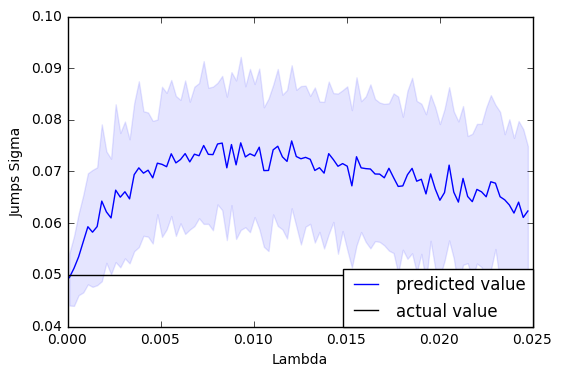

In [19]:
jump_sigmas = np.array(preds_MEAN)[:,2].reshape(100)
jump_sigmas_upper_84 = np.array(preds_Upper_84)[:,2].reshape(100)
jump_sigmas_lower_16 = np.array(preds_Lower_16)[:,2].reshape(100)

plt.plot(jump_lambda_s, jump_sigmas, color='b', label="predicted value");
plt.axhline(y=0.05, color='black', linestyle='-', label="actual value")
plt.fill_between(jump_lambda_s, jump_sigmas_lower_16, jump_sigmas_upper_84, color='b', alpha=0.1, edgecolor='none')
plt.xlabel("Lambda")
plt.ylabel("Jumps Sigma")

plt.legend(bbox_to_anchor=(1, 0.185), loc=1, borderaxespad=0.)
plt.show();

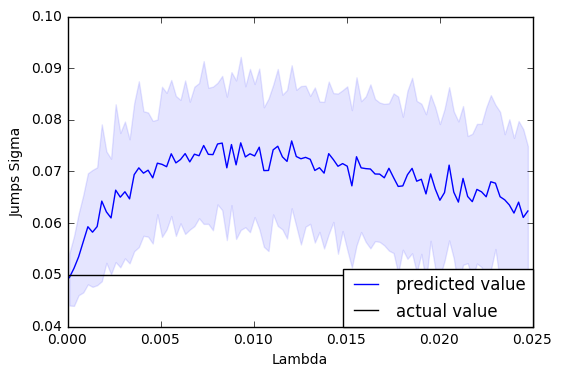

In [19]:
jump_sigmas = np.array(preds_MEAN)[:,2].reshape(100)
jump_sigmas_upper_84 = np.array(preds_Upper_84)[:,2].reshape(100)
jump_sigmas_lower_16 = np.array(preds_Lower_16)[:,2].reshape(100)


plt.plot(jump_lambda_s, jump_sigmas, color='b', label="predicted value");
plt.axhline(y=0.05, color='black', linestyle='-', label="actual value")
plt.fill_between(jump_lambda_s, jump_sigmas_lower_16, jump_sigmas_upper_84, color='b', alpha=0.1, edgecolor='none')
plt.xlabel("Lambda")
plt.ylabel("Jumps Sigma")

plt.legend(bbox_to_anchor=(1, 0.185), loc=1, borderaxespad=0.)
plt.show();

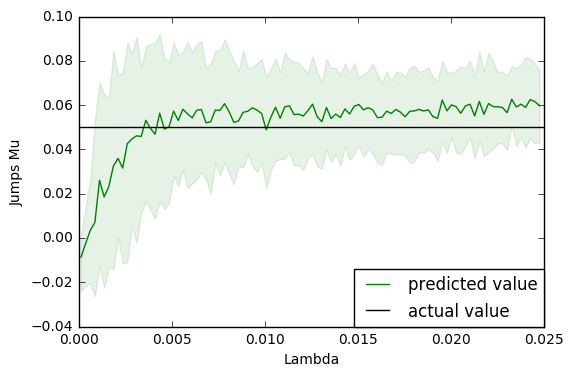

In [20]:
jump_mus = np.array(preds_MEAN)[:,3].reshape(100)
jump_mus_upper_84 = np.array(preds_Upper_84)[:,3].reshape(100)
jump_mus_lower_16 = np.array(preds_Lower_16)[:,3].reshape(100)

plt.plot(jump_lambda_s, jump_mus, color='g', label="predicted value");
plt.axhline(y=0.05, color='black', linestyle='-', label="actual value")
plt.fill_between(jump_lambda_s, jump_mus_lower_16, jump_mus_upper_84, color='g', alpha=0.1, edgecolor='none')
plt.xlabel("Lambda")
plt.ylabel("Jumps Mu")

plt.legend(bbox_to_anchor=(1, 0.185), loc=1, borderaxespad=0.)
plt.show();

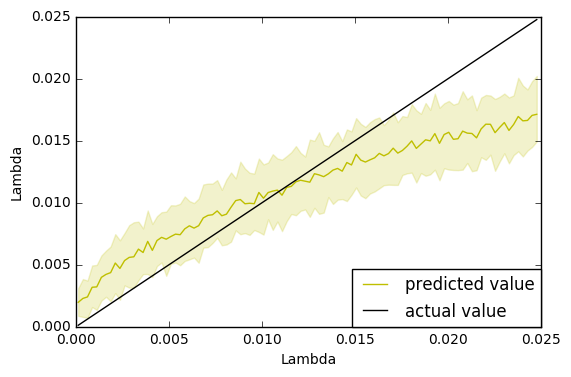

In [23]:
lambdas = np.array(preds_MEAN)[:,4].reshape(100)
lambdas_upper_84 = np.array(preds_Upper_84)[:,4].reshape(100)
lambdas_lower_16 = np.array(preds_Lower_16)[:,4].reshape(100)

plt.plot(jump_lambda_s, lambdas, color='y', label="predicted value");
plt.plot(jump_lambda_s, jump_lambda_s, color='black', label="actual value");
plt.fill_between(jump_lambda_s, lambdas_lower_16, lambdas_upper_84, color='y', alpha=0.2, edgecolor='none')
plt.xlabel("Lambda")
plt.ylabel("Lambda")

plt.legend(bbox_to_anchor=(1, 0.185), loc=1, borderaxespad=0.)
plt.show();

# Tests

In [16]:
test_set_pred, train_statistics = standard_test_sets()

0
100
200
300
400
500
600
700
800
900


In [17]:
#predictions = covnet_mo.predict(test_set_pred)
predictions_elu = covnet_mo_elu.predict(test_set_pred)

In [18]:
predictions_ff = feedforward.predict(train_statistics)

In [29]:
np.mean(predictions_ff, axis = 1)

array([[ 0.08518287],
       [ 0.37828639],
       [ 0.07916097],
       [-0.08705545],
       [ 0.00680225]], dtype=float32)

In [30]:
np.mean(predictions_elu, axis = 1)

array([[ 0.09537385],
       [ 0.06136218],
       [ 0.07741082],
       [ 0.06782658],
       [ 0.01615281]], dtype=float32)

In [50]:
sigmas = predictions[0]

In [51]:
from PIL import Image

In [20]:
def predictions_hist(predictions, true_value, plot_title = "model", param_name = "param", min_edge = None, max_edge = None, y_lim = (None, None), bin_size = 0.0025, img_subdir = "/Images/", save_to_file = True):
    
    if min_edge == None:
        min_edge = np.min(predictions)
    
    if max_edge == None:
        max_edge = np.max(predictions)
    
    bin_size = (max_edge-min_edge)/50
    N = (max_edge-min_edge)/bin_size; Nplus1 = N + 1
    bin_list = np.linspace(min_edge, max_edge, Nplus1)

    fig = pylab.figure();
    l = pylab.hist(predictions, bins=bin_list);
    #pylab.title(plot_title);
    pylab.axvline(x = true_value, c='k');
    pylab.xlim(min_edge, max_edge);
    
    if y_lim != (None, None):
        pylab.ylim(y_lim[0], y_lim[1])
    
    fig.set_dpi(120)     # draw the canvas, cache the renderer
    
    def fig2data ( fig ):
        """
        @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
        @param fig a matplotlib figure
        @return a numpy 3D array of RGBA values
        """
        # draw the renderer
        fig.canvas.draw ( )

        # Get the RGBA buffer from the figure
        w,h = fig.canvas.get_width_height()
        buf = numpy.fromstring ( fig.canvas.tostring_argb(), dtype=numpy.uint8 )
        buf.shape = ( w, h,4 )

        # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
        buf = numpy.roll ( buf, 3, axis = 2 )
        return buf

    def fig2img ( fig ):
        """
        @brief Convert a Matplotlib figure to a PIL Image in RGBA format and return it
        @param fig a matplotlib figure
        @return a Python Imaging Library ( PIL ) image
        """
        # put the figure pixmap into a numpy array
        buf = fig2data ( fig )
        w, h, d = buf.shape
        return Image.frombytes( "RGBA", ( w ,h ), buf.tostring( ) )
    
    #width, height = fig.get_size_inches() * fig.get_dpi()
    #img = (np.fromstring(fig.canvas.tostring_rgb(), dtype='uint8', sep='')).reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    if save_to_file:
        fig.savefig(ROOT_DIR + img_subdir + plot_title + "_" + param_name + ".png");
    return fig, l

In [23]:
mp = test_set_model_params()

/Users/Rayno/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


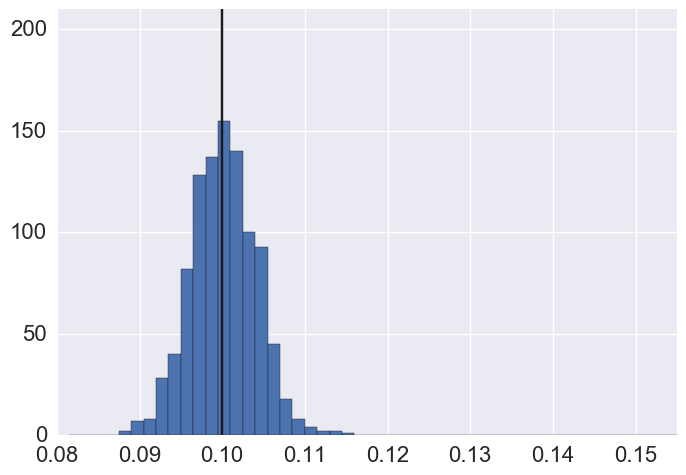

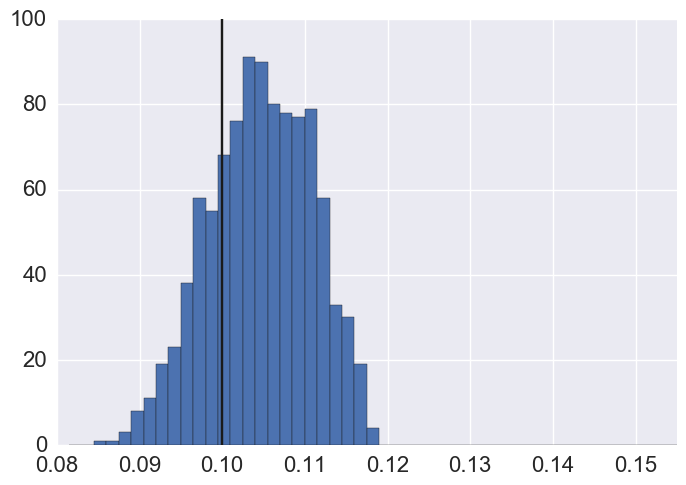

In [24]:
"""predictions_hist(predictions[0], mp.all_sigma, 
                 "Convolutional Architecture - Multiple Output - ReLU", 
                 "Sigma",
                 min_edge = 0.08,
                 max_edge = 0.155,
                 y_lim = (0, 210),
                 img_subdir = "/Images/Parameter-Prediction-Results/ConvolutionalNN-MultipleOutput-ReLU/");
"""
predictions_hist(predictions_elu[0], mp.all_sigma, 
                 "Convolutional Architecture - Multiple Output - ELU", 
                 "Sigma",
                 min_edge = 0.08,
                 max_edge = 0.155,
                 y_lim = (0, 210),
                 img_subdir = "/Images/Parameter-Prediction-Results/ConvolutionalNN-MultipleOutput-ELU/");

predictions_hist(predictions_ff[0], mp.all_sigma, 
                 "Fully Connected Architecture - Multiple Output - ELU", 
                 "Sigma",
                 min_edge = 0.08,
                 max_edge = 0.155,
                 img_subdir = "/Images/Parameter-Prediction-Results/FullyConnected-MultipleOutput-ELU/");

/Users/Rayno/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


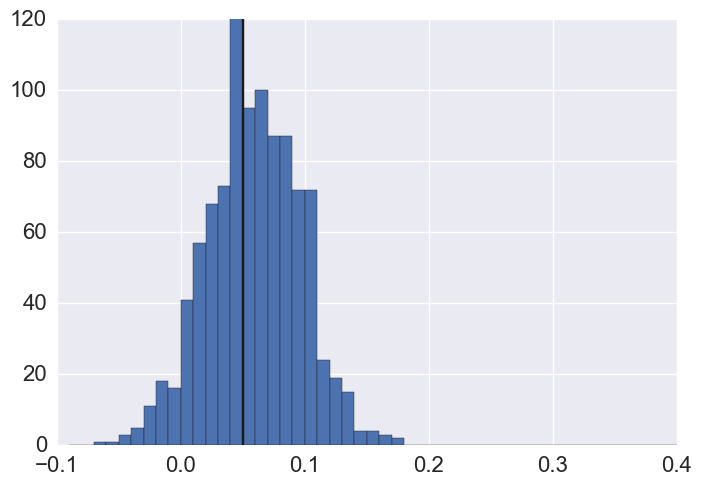

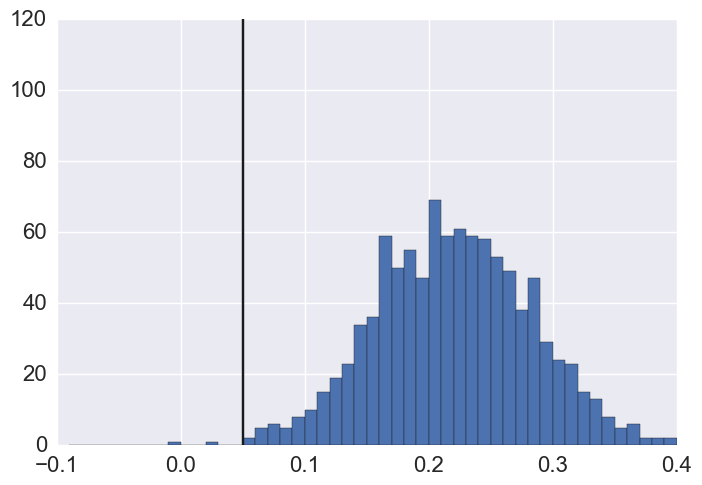

In [25]:
"""predictions_hist(predictions[1], mp.gbm_mu, 
                 "Convolutional Architecture - Multiple Output - ReLU", 
                 "Mu",
                 min_edge = -0.1,
                 max_edge = 0.4,
                 y_lim = (0, 120),
                 img_subdir = "/Images/Parameter-Prediction-Results/ConvolutionalNN-MultipleOutput-ReLU/");
"""
predictions_hist(predictions_elu[1], mp.gbm_mu, 
                 "Convolutional Architecture - Multiple Output - ELU", 
                 "Mu",
                 min_edge = -0.1,
                 max_edge = 0.4,
                 y_lim = (0, 120),
                 img_subdir = "/Images/Parameter-Prediction-Results/ConvolutionalNN-MultipleOutput-ELU/");

predictions_hist(predictions_ff[1], mp.gbm_mu, 
                 "Fully Connected Architecture - Multiple Output - ELU", 
                 "Mu",
                 min_edge = -0.1,
                 max_edge = 0.4,
                 y_lim = (0, 120),
                 img_subdir = "/Images/Parameter-Prediction-Results/FullyConnected-MultipleOutput-ELU/");

/Users/Rayno/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


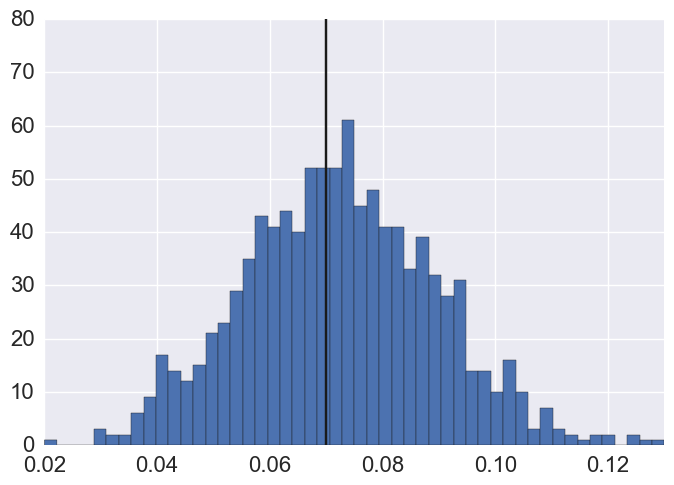

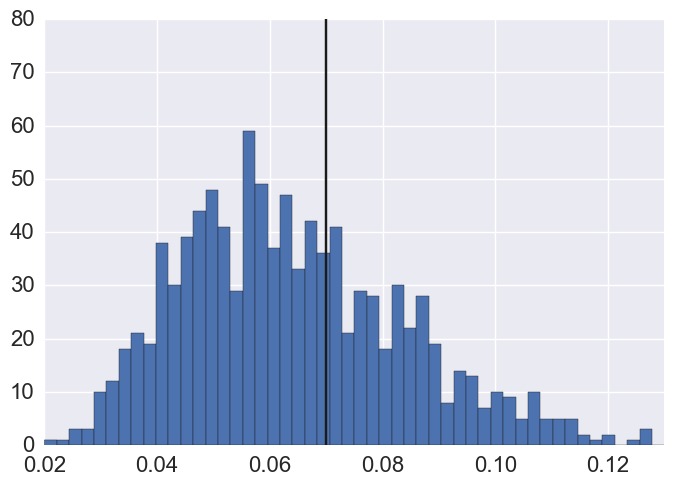

In [26]:
"""predictions_hist(predictions[2], mp.jumps_sigma, 
                 "Convolutional Architecture - Multiple Output - ReLU", 
                 "Jumps Sigma",
                 min_edge = 0.02,
                 max_edge = 0.13,
                 y_lim = (0, 80),
                 img_subdir = "/Images/Parameter-Prediction-Results/ConvolutionalNN-MultipleOutput-ReLU/");
"""
predictions_hist(predictions_elu[2], mp.jumps_sigma, 
                 "Convolutional Architecture - Multiple Output - ELU", 
                 "Jumps Sigma",
                 min_edge = 0.02,
                 max_edge = 0.13,
                 y_lim = (0, 80),
                 img_subdir = "/Images/Parameter-Prediction-Results/ConvolutionalNN-MultipleOutput-ELU/");

"""predictions_hist(predictions_ff[2], mp.jumps_sigma, 
                 "Fully Connected Architecture - Multiple Output - ELU", 
                 "Jumps Sigma",
                 min_edge = 0.02,
                 max_edge = 0.13,
                 img_subdir = "/Images/Parameter-Prediction-Results/FullyConnected-MultipleOutput-ELU/");"""

preds_so = covnet_jump_sigma.predict(test_set_pred)
predictions_hist(preds_so, mp.jumps_sigma, 
                 "Convolutional Architecture - Multiple Output - ELU", 
                 "Jumps Sigma",
                 min_edge = 0.02,
                 max_edge = 0.13,
                 y_lim = (0, 80),
                 img_subdir = "/Images/Parameter-Prediction-Results/ConvolutionalNN-MultipleOutput-ELU/");

/Users/Rayno/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


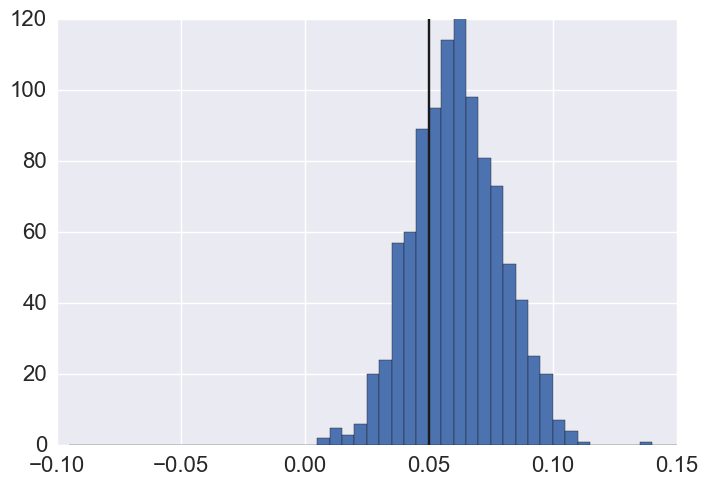

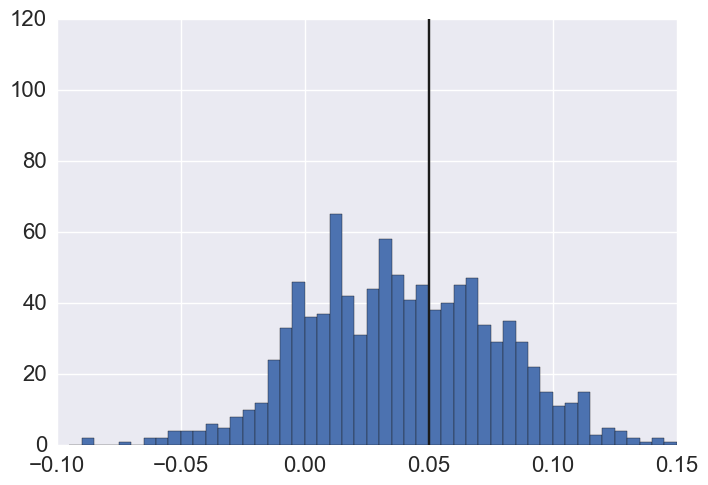

In [27]:
"""predictions_hist(predictions[3], mp.jumps_mu, 
                 "Convolutional Architecture - Multiple Output - ReLU", 
                 "Jumps Mu",
                 min_edge = -0.1,
                 max_edge = 0.15,
                 y_lim = (0, 120),
                 img_subdir = "/Images/Parameter-Prediction-Results/ConvolutionalNN-MultipleOutput-ReLU/");
"""
predictions_hist(predictions_elu[3], mp.jumps_mu, 
                 "Convolutional Architecture - Multiple Output - ELU", 
                 "Jumps Mu",
                 min_edge = -0.1,
                 max_edge = 0.15,
                 y_lim = (0, 120),
                 img_subdir = "/Images/Parameter-Prediction-Results/ConvolutionalNN-MultipleOutput-ELU/");

predictions_hist(predictions_ff[3], mp.jumps_mu, 
                 "Fully Connected Architecture - Multiple Output - ELU", 
                 "Jumps Mu",
                 min_edge = -0.1,
                 max_edge = 0.15,
                 y_lim = (0, 120),
                 img_subdir = "/Images/Parameter-Prediction-Results/FullyConnected-MultipleOutput-ELU/");

In [28]:
predictions_so = covnet_jump_mu.predict(test_set_pred)

In [54]:
predictions_so

array([[  5.02977276],
       [  5.71695042],
       [  6.30309725],
       [  6.54571295],
       [  5.60149765],
       [  7.61915636],
       [  7.59377527],
       [  5.86242867],
       [  8.23993301],
       [  8.5358572 ],
       [  5.33300495],
       [  4.81611633],
       [ 10.07497311],
       [  5.04410219],
       [  8.0665369 ],
       [  5.28865862],
       [  4.8428545 ],
       [  7.52376366],
       [  7.53959846],
       [  7.54267025],
       [  6.35014725],
       [  5.98653936],
       [  7.44900799],
       [  8.96749783],
       [  5.47997379],
       [  6.24627304],
       [  6.2920475 ],
       [  5.3908329 ],
       [  4.93275213],
       [  5.10551071],
       [  7.30753231],
       [ 11.28420639],
       [  8.0478344 ],
       [  6.12012148],
       [  6.93621254],
       [  7.06936359],
       [  5.40357685],
       [  8.16735458],
       [  7.17444611],
       [  4.17714167],
       [  6.23904991],
       [  6.04728174],
       [  5.32885647],
       [  6

/Users/Rayno/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


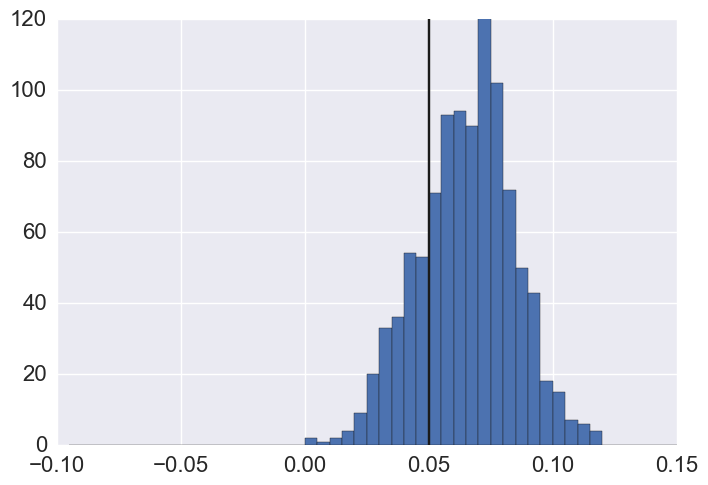

In [29]:
predictions_hist(np.reshape(predictions_so, len(predictions_so)), mp.jumps_mu, 
                 "Fully Connected Architecture - Multiple Output - ELU", 
                 "Jumps Mu",
                 min_edge = -0.1,
                 max_edge = 0.15,
                 y_lim = (0, 120),
                 img_subdir = "/Images/Parameter-Prediction-Results/FullyConnected-MultipleOutput-ELU/");


In [30]:
single_param_predictions_lambda = covnet_lambda.predict(test_set_pred)

In [31]:
""""predictions_hist(predictions[4], mp.lamda, 
                 "Convolutional Architecture - Multiple Output - ReLU", 
                 "Lambda",
                 min_edge = 0.004,
                 max_edge = 0.025,
                 y_lim = (0, 100),
                 img_subdir = "/Images/Parameter-Prediction-Results/ConvolutionalNN-MultipleOutput-ReLU/");
""""

predictions_hist(predictions_elu[4], mp.lamda, 
                 "Convolutional Architecture - Multiple Output - ELU", 
                 "Lambda",
                 min_edge = 0.004,
                 max_edge = 0.025,
                 y_lim = (0, 100),
                 img_subdir = "/Images/Parameter-Prediction-Results/ConvolutionalNN-MultipleOutput-ELU/");

predictions_hist(predictions_ff[4], mp.lamda, 
                 "Fully Connected Architecture - Multiple Output - ELU", 
                 "Lambda",
                 min_edge = 0.004,
                 max_edge = 0.025,
                 img_subdir = "/Images/Parameter-Prediction-Results/FullyConnected-MultipleOutput-ELU/");

predictions_hist(single_param_predictions_lambda, mp.lamda, 
                 "Convolutional Architecture - Single Output - ELU", 
                 "Lambda",
                 min_edge = 0.004,
                 max_edge = 0.025,
                 img_subdir = "/Images/Parameter-Prediction-Results/ConvolutionalNN-SingleOutput/");

SyntaxError: EOL while scanning string literal (<ipython-input-31-194c23ebd904>, line 8)

In [230]:
predictionset = []
for return_set in test_set:
    prediction = []
    output1 = covnet_mo.predict(np.array([return_set]))
    output2 = covnet_lambda.predict(np.array([return_set]))
    output3 = covnet_jump_mu.predict(np.array([return_set]))
    output4 = covnet_jump_sigma.predict(np.array([return_set]))
    for output in output1:
        prediction.append(output[0][0])
    prediction.append(output2[0][0])
    prediction.append(output3[0][0])
    prediction.append(output4[0][0])
    predictionset.append(prediction)
        

ValueError: Error when checking : expected input_1 to have 4 dimensions, but got array with shape (1, 2000)

In [140]:
preds = ff_ensembling.predict(np.array(predictionset))
np.transpose(preds)[4]

array([ 0.01691603,  0.01632243,  0.01698936,  0.01676064,  0.01561777,
        0.01054441,  0.01768478,  0.01457271,  0.01843683,  0.0168693 ,
        0.01600389,  0.01638517,  0.01507611,  0.01610111,  0.01592271,
        0.01314703,  0.01490481,  0.01501949,  0.01693797,  0.0158531 ,
        0.01357409,  0.01453476,  0.01619878,  0.01712601,  0.01705366,
        0.01701345,  0.01510824,  0.01401103,  0.01599672,  0.01452127,
        0.01559582,  0.01589513,  0.01460927,  0.01527657,  0.01505311,
        0.01708319,  0.01674977,  0.01409111,  0.01417134,  0.01625022,
        0.01263396,  0.01482027,  0.01782426,  0.01611951,  0.01677342,
        0.01678674,  0.01415386,  0.01049334,  0.01216156,  0.01326275,
        0.01669437,  0.01207872,  0.01877503,  0.01535229,  0.01533715,
        0.01729877,  0.01627471,  0.01411244,  0.01586549,  0.01619226,
        0.01433229,  0.01356581,  0.01351994,  0.01609074,  0.0183733 ,
        0.01745659,  0.01566325,  0.01088837,  0.01553585,  0.01

In [94]:
lambdas = np.transpose(preds)[4]

bin_size = 0.0005; min_edge = np.min(lambdas)-0.003; max_edge = np.max(lambdas)
N = (max_edge-min_edge)/bin_size; Nplus1 = N + 1
bin_list = np.linspace(min_edge, max_edge, Nplus1)

plt.hist(lambdas, bins=bin_list);
plt.title("Single Output:  Lambda with true value = "+str(mp.lamda));
plt.axvline(x=mp.lamda, c='k')
plt.show();

NameError: name 'preds' is not defined

In [95]:
jump_mus = np.transpose(preds)[3]

bin_size = 0.0025; min_edge = np.min(jump_mus)-0.03; max_edge = np.max(jump_mus)
N = (max_edge-min_edge)/bin_size; Nplus1 = N + 1
bin_list = np.linspace(min_edge, max_edge, Nplus1)

plt.hist(jump_mus, bins=bin_list);
plt.axvline(x=mp.jumps_mu, c='k')
plt.title("Multiple Output: Mu_jumps with true value = "+str(mp.jumps_mu));
plt.show();

NameError: name 'preds' is not defined

In [96]:
jump_sigmas = np.transpose(preds)[2]

bin_size = 0.0025; min_edge = np.min(jump_sigmas)-0.025; max_edge = np.max(jump_sigmas)
N = (max_edge-min_edge)/bin_size; Nplus1 = N + 1
bin_list = np.linspace(min_edge, max_edge, Nplus1)

plt.hist(jump_sigmas, bins=bin_list);
plt.title("Multiple Output: Sigma_jumps with true value = "+str(mp.jumps_sigma));
plt.axvline(x=mp.jumps_sigma, c='k')
plt.show();

NameError: name 'preds' is not defined

In [97]:
preds

NameError: name 'preds' is not defined

In [144]:

output1 = covnet_mo.predict(np.array([return_set]))
output2 = covnet_lambda.predict(np.array([return_set]))
output3 = covnet_jump_mu.predict(np.array([return_set]))
output4 = covnet_jump_sigma.predict(np.array([return_set]))
prediction = []

for output in output1:
    prediction.append(output[0][0])
prediction.append(output2[0][0])
prediction.append(output3[0][0])
prediction.append(output4[0][0])    

NameError: name 'covnet_mo' is not defined

In [154]:
import sys

In [165]:
int(str(random_seed)[4:])

921358190

In [160]:
import time

In [205]:
best_case_params = []
best_case_seed = 0
best_MSE = float('inf')

worst_case_params = []
worst_case_seed = 0
worst_MSE = -float('inf')

for i in range(1000):
    print(i)
    random_seed = int(round(time.time() * 1000))
    random_seed = int(str(random_seed)[4:])
    
    mp = test_set_model_params()

    #print(mp.all_sigma, mp.gbm_mu, mp.lamda, mp.jumps_mu, mp.jumps_sigma)
    nrand.seed(random_seed)
    random.seed(random_seed)
    RETURNS_1 = geometric_brownian_motion_jump_diffusion_log_returns(mp)

    path1 = [1]
    for i in range(len(RETURNS_)):
        path1.append(path1[i]*np.exp(RETURNS_1[i]))

    nrand.seed(random_seed)
    random.seed(random_seed)
    return_set = np.reshape(np.array(geometric_brownian_motion_jump_diffusion_log_returns(mp)), (40, 50, 1))

    preds = covnet_mo_elu.predict(np.array([return_set]))
    
    est_mp = test_set_model_params()
    est_mp.all_sigma = preds[0][0][0]
    est_mp.gbm_mu = preds[1][0][0]
    est_mp.jumps_sigma = preds[2][0][0]
    est_mp.jumps_mu = preds[3][0][0]
    est_mp.lamda = preds[4][0][0]
    
    #print(np.reshape(preds, 5))

    nrand.seed(random_seed)
    random.seed(random_seed)
    RETURNS_2 = geometric_brownian_motion_jump_diffusion_log_returns(est_mp)
    
    path2 = [1]
    for i in range(len(RETURNS_)):
        path2.append(path2[i]*np.exp(RETURNS_2[i]))
    
    #plt.plot(path2);
    #plt.plot(path1);
    #plt.show();
    
    moments1 = stats.moment(RETURNS_1, moment = range(0,10))
    moments2 = stats.moment(RETURNS_2, moment = range(0,10))
    
    RET_MSE = ((np.array(path2) - np.array(path1)) ** 2).mean(axis=0)/1000000000
    MSE = ((moments1 - moments2) ** 2).mean(axis=0) + RET_MSE
    print(MSE)
    
    if MSE > worst_MSE:
        worst_MSE = MSE
        worst_case_params = preds
        worst_case_seed = random_seed
        
    if MSE < best_MSE:
        best_MSE = MSE
        best_case_params = preds
        best_case_seed = random_seed

0
2.26845333412e-08
1
8.46518471214e-09
2
4.10989514677e-08
3
6.20525826304e-08
4
5.17765661709e-08
5
3.74147782915e-09
6
2.35583184369e-06
7
9.99629417792e-06
8
7.94110335916e-08
9
9.76830774734e-09
10
7.14765252336e-10
11
1.16300846242e-06
12
1.71697028682e-09
13
1.80003115972e-09
14
1.07229718818e-09
15
1.00341060447e-05
16
4.9875455379e-09
17
1.02865337639e-09
18
2.05607093541e-09
19
2.45026786187e-10
20
3.54984526102e-08
21
3.47426127046e-10
22
9.83899468293e-08
23
7.22846409216e-11
24
2.92052987112e-09
25
6.46807428524e-10
26
4.15366478572e-09
27
5.47807841269e-08
28
1.49518523394e-09
29
1.82156067512e-09
30
7.75278233441e-10
31
2.34602456553e-09
32
6.46974531982e-10
33
7.85698743523e-10
34
5.02617688136e-09
35
8.65524272159e-10
36
1.72810848521e-07
37
9.62277966941e-10
38
1.85363373203e-10
39
7.79897770753e-09
40
1.22219983631e-08
41
1.86825108279e-09
42
4.94549009052e-10
43
6.59700415529e-10
44
1.63860606655e-09
45
2.28237888928e-07
46
7.28499195766e-10
47
3.4035285966e-09
48
2

KeyboardInterrupt: 

0.1 0.05 0.02 0.05 0.07
[ 0.09241344  0.05936308  0.07461458  0.11601435  0.01922408]


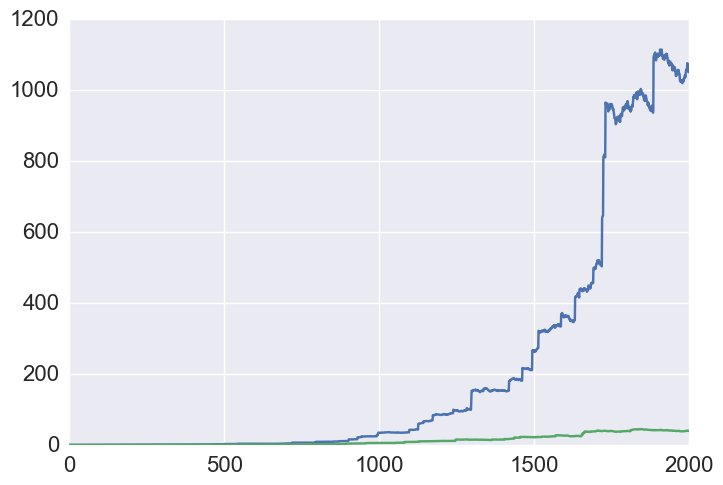

In [208]:
random_seed = worst_case_seed

mp = test_set_model_params()

print(mp.all_sigma, mp.gbm_mu, mp.lamda, mp.jumps_mu, mp.jumps_sigma)
nrand.seed(random_seed)
random.seed(random_seed)
RETURNS_1 = geometric_brownian_motion_jump_diffusion_log_returns(mp)

path1 = [1]
for i in range(len(RETURNS_)):
    path1.append(path1[i]*np.exp(RETURNS_1[i]))

nrand.seed(random_seed)
random.seed(random_seed)
return_set = np.reshape(np.array(geometric_brownian_motion_jump_diffusion_log_returns(mp)), (40, 50, 1))

preds = covnet_mo_elu.predict(np.array([return_set]))

est_mp = test_set_model_params()
est_mp.all_sigma = preds[0][0][0]
est_mp.gbm_mu = preds[1][0][0]
est_mp.jumps_sigma = preds[2][0][0]
est_mp.jumps_mu = preds[3][0][0]
est_mp.lamda = preds[4][0][0]

print(np.reshape(preds, 5))

nrand.seed(random_seed)
random.seed(random_seed)
RETURNS_2 = geometric_brownian_motion_jump_diffusion_log_returns(est_mp)

path2 = [1]
for i in range(len(RETURNS_)):
    path2.append(path2[i]*np.exp(RETURNS_2[i]))

plt.plot(path2);
plt.plot(path1);
plt.show();

0.1 0.05 0.02 0.05 0.07
[ 0.09335255  0.06450465  0.07495692  0.04866205  0.01893705]


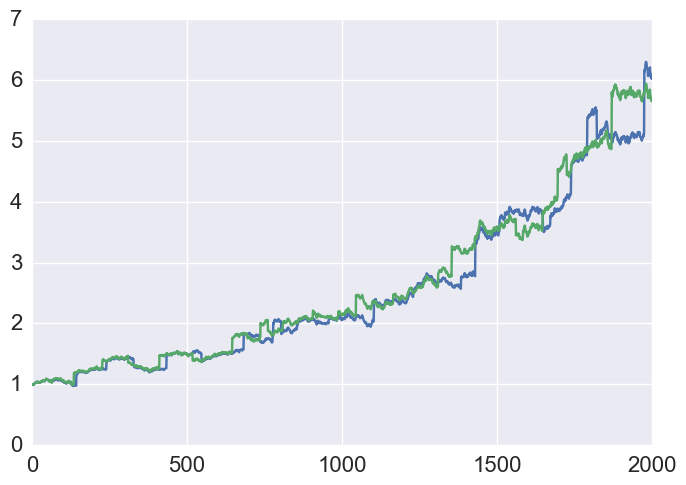

In [209]:
random_seed = best_case_seed

mp = test_set_model_params()

print(mp.all_sigma, mp.gbm_mu, mp.lamda, mp.jumps_mu, mp.jumps_sigma)

nrand.seed(random_seed)
random.seed(random_seed)
RETURNS_1 = geometric_brownian_motion_jump_diffusion_log_returns(mp)

path1 = [1]
for i in range(len(RETURNS_)):
    path1.append(path1[i]*np.exp(RETURNS_1[i]))

nrand.seed(random_seed)
random.seed(random_seed)
return_set = np.reshape(np.array(geometric_brownian_motion_jump_diffusion_log_returns(mp)), (40, 50, 1))

preds = covnet_mo_elu.predict(np.array([return_set]))

est_mp = test_set_model_params()
est_mp.all_sigma = preds[0][0][0]
est_mp.gbm_mu = preds[1][0][0]
est_mp.jumps_sigma = preds[2][0][0]
est_mp.jumps_mu = preds[3][0][0]
est_mp.lamda = preds[4][0][0]

print(np.reshape(preds, 5))

nrand.seed(random_seed)
random.seed(random_seed)
RETURNS_2 = geometric_brownian_motion_jump_diffusion_log_returns(est_mp)

path2 = [1]
for i in range(len(RETURNS_)):
    path2.append(path2[i]*np.exp(RETURNS_2[i]))

plt.plot(path2);
plt.plot(path1);
plt.show();

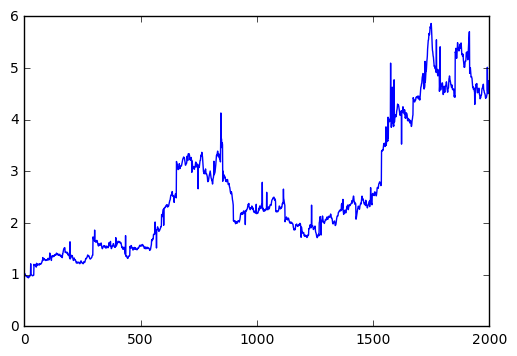

In [29]:
from scipy.optimize import differential_evolution
from scipy.stats import norm

In [90]:
def fdy(dy, dt, lamda, mu, sigma, muq, sigmaq):
    mu1 = (mu - (sigma**2)/2) * dt
    mu2 = (mu - (sigma**2)/2) * dt + muq
    sig1 = sigma * math.sqrt(dt)
    sig2 = math.sqrt((sigma**2)*dt + (sigmaq**2))
    dy1 = (dy-mu1)/sig1
    dy2 = (dy-mu2)/sig2
    pdf1 = norm.pdf(dy1)
    pdf2 = norm.pdf(dy2)
    pdf = (1 - lamda*dt) * pdf1 + (lamda*dt) * pdf2
    return(pdf)

In [91]:
def negloglik(theta, dy, dt):
    L = fdy(dy = dy, dt = dt, lamda = theta[0], mu = theta[1], sigma = theta[2], muq = theta[3], sigmaq = theta[4])
    nll = -sum(np.log(L))
    
    if math.isnan(nll):
        nll = 1e10
        
    return nll

In [128]:
mp = test_set_model_params()
path = geometric_brownian_motion_jump_diffusion_log_returns(mp)

In [129]:
path[0]

-0.0036448104367353515

In [130]:
dt = 1/255

In [131]:
bounds = [(0.0001,mp.lamda*255), (-1,1), (0.001,0.2), (-0.5,0.5), (0.001, 0.2)]
result = differential_evolution(negloglik, bounds, args = (path, dt), tol = 0.0000000000000001)

In [126]:
print(result.x)

[  2.55000000e-03  -9.15431667e-05   2.00000000e-01   2.08300937e-05
   1.99999999e-01]


In [127]:
print(mp.lamda*255, mp.gbm_mu, mp.all_sigma, mp.jumps_mu, mp.jumps_sigma)

0.00255 0.05 0.1 0.05 0.07
